# Petfinder Adoption Prediction - article


<b>Author: </b> Dawid Wisniewski

<b>Goal of the project:</b> The goal of the project is to predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder site. Our additional yet important objective is to identify the best practices that positively impact the adoption speed so that the future pet profiles are created to speed up the adoption speed

<b>Data:</b> The data included text, tabular, and image data. See below for details.

<b>Project description and data:</b> https://www.kaggle.com/c/petfinder-adoption-prediction

<b>Date: </b> 2020-06-08

# 0. Import libraries

In [4]:
# File manipulation and caggle
import os
import psutil #for getting the numnber of processor cores
from kaggle.api.kaggle_api_extended import KaggleApi #requires 
import zipfile
import json

# Data manipulation
import pandas as pd
import numpy as np
import re
import math

# Picture handling
from keras.preprocessing.image import img_to_array, load_img
from PIL import Image

# Charts
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Statistical tests
from scipy.stats import shapiro
from scipy.stats import f_oneway

# Clustering
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples
from matplotlib import cm

# pipeline construction
from sklearn.pipeline import FeatureUnion, Pipeline # Feature Union - łączenie featurów
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from copy import deepcopy # copying a fitted model/pipeline

# data processing
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

# models trainng
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost.sklearn import XGBClassifier

# models validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score, confusion_matrix, classification_report

# model visualisation
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree
from dtreeviz.trees import dtreeviz 

# random distributions
from scipy.stats import randint, uniform

# timing
import timeit
from datetime import datetime

# remove annoying warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Data imports
Import integrated data pre-processed and combined earlier

In [5]:
folder = "Processed_data"
train = pd.read_csv(f'{folder}/train.csv').drop('Unnamed: 0', axis=1) #the file has the old indexes in the first column
final_test = pd.read_csv(f'{folder}/final_test.csv').drop('Unnamed: 0', axis=1) #the file has the old indexes in the first column

Creating X and Y datasets and splitting into train and test sets

In [6]:
# creating the dependent and features datasets
y = train['AdoptionSpeed']
X = train.drop('AdoptionSpeed', axis=1)

In [7]:
# splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123, stratify=y)

# 2. Data Exploration

## 2.1 The dependent variable

In [5]:
pd.DataFrame({'count': y_train.value_counts(), 'freq': y_train.value_counts(normalize=True)})

count      freq
4   3357  0.279890
2   3230  0.269301
3   2607  0.217359
1   2472  0.206103
0    328  0.027347

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

We will turn the problem into binnary classification where "fast addoption classess" - classes 0-1 will be coded as 1 representing "fast addoption", i.e. addoption within 30 days from profile being listed, and all other classess as 0 representing "slow addoption", i.e. addoption in more than 30 days.

In [7]:
(y_train<3).value_counts(normalize=True)

True     0.502751
False    0.497249
Name: AdoptionSpeed, dtype: float64

## 2.2 Independent variables
We will first have a general overview of the data, and investigate in more details categorical and numeric variables separately

### 2.2.1 General information on the data

In [8]:
X_train.head()

Type                        Name  Age               Breed1       Breed2  \
1888  Dog                       Wolfe   72  German Shepherd Dog        Spitz   
723   Dog     Save Me Or I'll Die #20   12          Mixed Breed      Terrier   
4694  Dog                     Brownie   24          Mixed Breed           na   
4940  Cat                       Boboy    1  Domestic Short Hair           na   
9214  Dog  Olaf, Lyn And Little White    3          Mixed Breed  Mixed Breed   

     Gender Color1  Color2  Color3 MaturitySize  ... green_9 blue_9  \
1888   Male  Brown  Golden  Yellow       Medium  ...   139.0  172.0   
723    Male  Black   Brown   Cream       Medium  ...   179.0  211.0   
4694   Male  Black   Brown      na       Medium  ...    34.0   37.0   
4940   Male   Gray   White      na        Small  ...     NaN    NaN   
9214  Mixed  Black   Brown  Golden       Medium  ...   234.0  211.0   

     color_pixel_share_9 main_picture_x_start main_picture_y_start  \
1888            0.004788                  0.0                  0.0   
723             0.003692                  0.0                  0.0   
4694            0.000087                  0.0                  0.0   
4940                 NaN                  NaN                  NaN   
9214            0.027411                  0.0                  0.0   

      main_picture_x_end  main_picture_y_end  width height  dimensions  
1888               308.0               399.0  309.0  400.0     309x400  
723                266.0               399.0  267.0  400.0     267x400  
4694               299.0               399.0  300.0  400.0     300x400  
4940                 NaN                 NaN    NaN    NaN         NaN  
9214               359.0               479.0  360.0  480.0     360x480  

[5 rows x 99 columns]

We should notice that even categorical variables might have missing information which is not classified as missing. Example: Breed2 where na is string, but the information is missing.

Let's have a closer look at mixed breed dogs later, but we can already see thatsome mixed breed animals have Mixed Breed in Bread1

Let's try to understand what information is behind Gender - Mixed

Let's also have a closer look at colors later, missing information is marked as na (Color 3)

In [10]:
# let's see what data types we are dealing with
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11994 entries, 1888 to 13092
Data columns (total 99 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Type                  11994 non-null  object 
 1   Name                  10997 non-null  object 
 2   Age                   11994 non-null  int64  
 3   Breed1                11994 non-null  object 
 4   Breed2                11994 non-null  object 
 5   Gender                11994 non-null  object 
 6   Color1                11994 non-null  object 
 7   Color2                11994 non-null  object 
 8   Color3                11994 non-null  object 
 9   MaturitySize          11994 non-null  object 
 10  FurLength             11994 non-null  object 
 11  Vaccinated            11994 non-null  object 
 12  Dewormed              11994 non-null  object 
 13  Sterilized            11994 non-null  object 
 14  Health                11994 non-null  object 
 15  Quantity        

Majority of the columns are numeric. <br>
Let's start looking at the categorical variables first. <br>
With numeric variable there are is a lot of missing information for many variables so let's decide what to do with it

### 2.2.2 Non-numeric columns

In [9]:
# getting a list of categorical columns
non_numeric_columns = X_train.select_dtypes(exclude=np.number).columns
non_numeric_columns

Index(['Type', 'Name', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'State', 'RescuerID', 'Description', 'PetID',
       'description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'full_description', 'description_9', 'dimensions'],
      dtype='object')

In [10]:
len(non_numeric_columns)

30

Column: Type
All values: 11994 out of 11994. (0.00% are missing)
Number of missing values: 0
Number of "na" values: 0
Unique values: 2


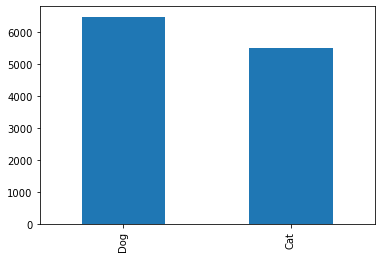

     count     freq
Dog   6486  0.54077
Cat   5508  0.45923
---------------------------------------------------------------
Column: Name
All values: 10997 out of 11994. (8.31% are missing)
Number of missing values: 997
Number of "na" values: 0
Unique values: 7470
         count      freq
Lucky       54  0.004910
Baby        50  0.004547
Brownie     46  0.004183
No Name     45  0.004092
Blackie     44  0.004001
Mimi        43  0.003910
Puppy       39  0.003546
Kitty       34  0.003092
Kittens     33  0.003001
Max         27  0.002455
Angel       27  0.002455
Coco        26  0.002364
Tiger       26  0.002364
Kiki        26  0.002364
Milo        25  0.002273
Tom         25  0.002273
Bobby       24  0.002182
Prince      24  0.002182
Lucy        23  0.002091
Puppies     23  0.002091
---------------------------------------------------------------
Column: Breed1
All values: 11990 out of 11994. (0.03% are missing)
Number of missing values: 0
Number of "na" values: 4
Unique values: 170
        

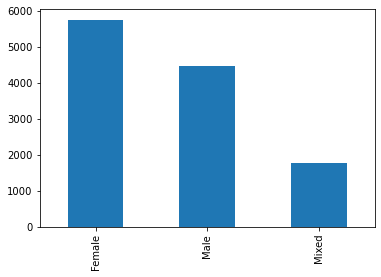

        count      freq
Female   5762  0.480407
Male     4467  0.372436
Mixed    1765  0.147157
---------------------------------------------------------------
Column: Color1
All values: 11994 out of 11994. (0.00% are missing)
Number of missing values: 0
Number of "na" values: 0
Unique values: 7


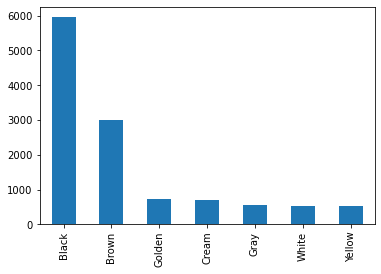

        count      freq
Black    5955  0.496498
Brown    2986  0.248958
Golden    735  0.061281
Cream     708  0.059030
Gray      558  0.046523
White     530  0.044189
Yellow    522  0.043522
---------------------------------------------------------------
Column: Color2
All values: 8459 out of 11994. (29.47% are missing)
Number of missing values: 0
Number of "na" values: 3535
Unique values: 7


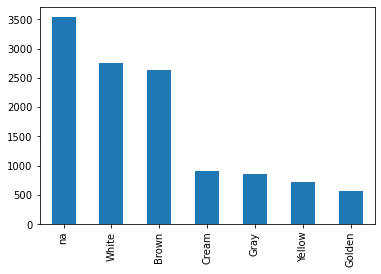

        count      freq
na       3535  0.294731
White    2758  0.229948
Brown    2639  0.220027
Cream     909  0.075788
Gray      866  0.072203
Yellow    714  0.059530
Golden    573  0.047774
---------------------------------------------------------------
Column: Color3
All values: 3548 out of 11994. (70.42% are missing)
Number of missing values: 0
Number of "na" values: 8446
Unique values: 6


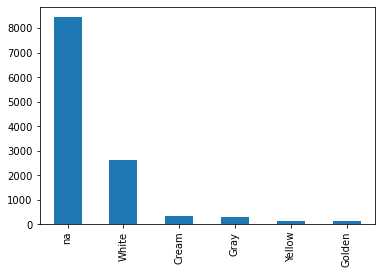

        count      freq
na       8446  0.704185
White    2613  0.217859
Cream     336  0.028014
Gray      310  0.025846
Yellow    151  0.012590
Golden    138  0.011506
---------------------------------------------------------------
Column: MaturitySize
All values: 11994 out of 11994. (0.00% are missing)
Number of missing values: 0
Number of "na" values: 0
Unique values: 4


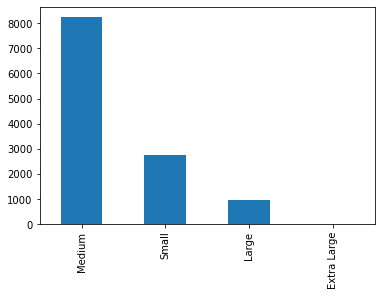

             count      freq
Medium        8238  0.686843
Small         2749  0.229198
Large          982  0.081874
Extra Large     25  0.002084
---------------------------------------------------------------
Column: FurLength
All values: 11994 out of 11994. (0.00% are missing)
Number of missing values: 0
Number of "na" values: 0
Unique values: 3


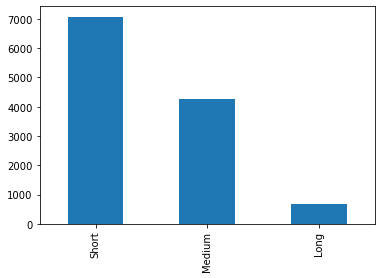

        count      freq
Short    7075  0.589878
Medium   4258  0.355011
Long      661  0.055111
---------------------------------------------------------------
Column: Vaccinated
All values: 11994 out of 11994. (0.00% are missing)
Number of missing values: 0
Number of "na" values: 0
Unique values: 3


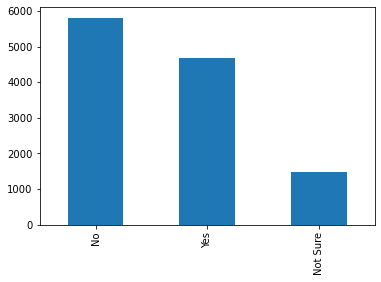

          count      freq
No         5818  0.485076
Yes        4694  0.391362
Not Sure   1482  0.123562
---------------------------------------------------------------
Column: Dewormed
All values: 11994 out of 11994. (0.00% are missing)
Number of missing values: 0
Number of "na" values: 0
Unique values: 3


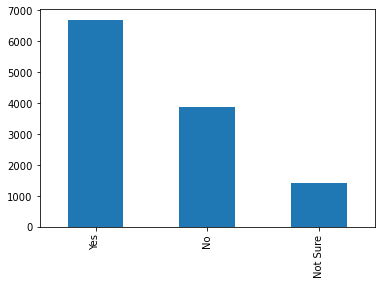

          count      freq
Yes        6703  0.558863
No         3876  0.323162
Not Sure   1415  0.117976
---------------------------------------------------------------
Column: Sterilized
All values: 11994 out of 11994. (0.00% are missing)
Number of missing values: 0
Number of "na" values: 0
Unique values: 3


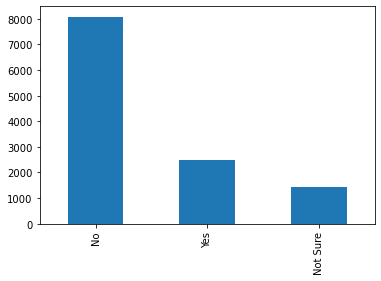

          count      freq
No         8081  0.673754
Yes        2480  0.206770
Not Sure   1433  0.119476
---------------------------------------------------------------
Column: Health
All values: 11994 out of 11994. (0.00% are missing)
Number of missing values: 0
Number of "na" values: 0
Unique values: 3


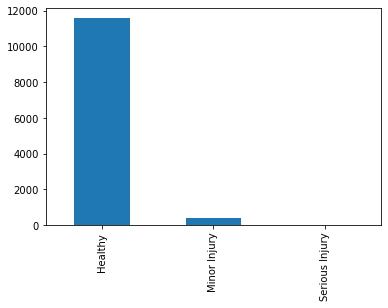

                count      freq
Healthy         11579  0.965399
Minor Injury      388  0.032350
Serious Injury     27  0.002251
---------------------------------------------------------------
Column: State
All values: 11994 out of 11994. (0.00% are missing)
Number of missing values: 0
Number of "na" values: 0
Unique values: 14


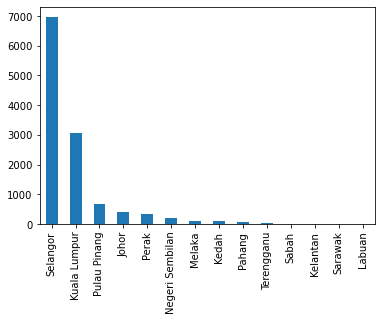

                 count      freq
Selangor          6968  0.580957
Kuala Lumpur      3075  0.256378
Pulau Pinang       684  0.057029
Johor              408  0.034017
Perak              324  0.027014
Negeri Sembilan    204  0.017009
Melaka              99  0.008254
Kedah               92  0.007671
Pahang              72  0.006003
Terengganu          23  0.001918
Sabah               18  0.001501
Kelantan            13  0.001084
Sarawak             11  0.000917
Labuan               3  0.000250
---------------------------------------------------------------
Column: RescuerID
All values: 11994 out of 11994. (0.00% are missing)
Number of missing values: 0
Number of "na" values: 0
Unique values: 4800
                                  count      freq
fa90fa5b1ee11c86938398b60abc32cb    360  0.030015
aa66486163b6cbc25ea62a34b11c9b91    251  0.020927
c00756f2bdd8fa88fc9f07a8309f7d5d    196  0.016342
b53c34474d9e24574bcec6a3d3306a0d    176  0.014674
ee2747ce26468ec44c7194e7d1d9dad9    130  0.01083

In [11]:
# a loop to go through the variables and show key information about it
many_categories = 20
total_rows = X_train.shape[0]
for column in non_numeric_columns:
    number_of_unique_categories = len(X_train[column].unique())
    print(f'Column: {column}')
    
    # missing value information
    all_values=X_train[column]
    nan_values = X_train[column].isna().sum()
    na_values = (X_train[column]=="na").sum()
    all_missing = nan_values + na_values 
    print(f'All values: {total_rows - all_missing} out of {total_rows}. ({all_missing/total_rows:.2%} are missing)')
    print(f'Number of missing values: {nan_values}')
    print(f'Number of "na" values: {na_values}')
    print(f'Unique values: {number_of_unique_categories}')
    
    # unique value and their frequencies
    if number_of_unique_categories < many_categories: # draw bar chart only for variables with a few categories 
        X_train[column].value_counts().plot.bar()
        plt.show()
    print(pd.DataFrame({'count': X_train[column].value_counts(), 'freq': X_train[column].value_counts(normalize=True)}).head(20))
    print('---------------------------------------------------------------')


Observations:
* Type - no special transformations seem to be needed
* Name - there is a huge number of variants, even the most popular variant is less than 1%. The only useful information seems to be if there is any => we will create a has_name variable informing, if the animal has a name, and drop the original Name variable. 
* Breed 1 - There are only 4 profiles with "na" value - we will keep it as is because also aggregate the less popular categories.
* Breed 2 - we will analyze further for grouping of breeds (below). after this we will tokenize the breeds.
* Gender - we will investigate below what the mixed gender is and decide what to do
* Color1 - we will keep it is, we will interpret this as the dominant color
* Color2, Color3 - many missing information, we need to investigate them further
* Maturity size - small number of Extra Large, we will consider aggregate it with Large
* Fur Length -  the smallest category still has over 500 observations so does not seem require transformations
* Vaccinated - can be kept as is - relatively balanced distribution between categories
* Dewormed - can be kept as is - relatively balanced distribution between categories 
* Sterilized - can be kept as is - relatively balanced distribution between categories 
* Health - small number of Serious Injoury, we will aggregate it with Minor Injoury
* State - small number of some states, we will consider aggregate them
* RescuerID - drop from analysis - since this information is hashed, it should not have any impact on AdoptionSpeed
* Description - we will tokenize it
* PetID - drop from the analysis - each pet's unique ID is not needed once the data is merged
* description_0 - 9 - since it's based on Google Vision, none of the variables seems to be adding much value as a standalone. We will drop them and use full_description instead
* full_description - combines the information from description_0 - 9. We will tokenize it (token separator is ;)
* dimensions - very lagre number of categories so some gruping will be required. Missing values will need to be handled. On top of the dimensions themselves some additional information can be pulled from this data, such as:
    * if the image is small, medium or large
    * if the image is horizontal, vertical or square

Note that all those variables require binear encoding or tokenization. Some of them will require handling missing data.

#### Breed2
Let's have a closer look at Breed2 variable

In [15]:
X_train.Breed2.value_counts(normalize=True)

na                      0.716525
Mixed Breed             0.114057
Domestic Short Hair     0.040854
Domestic Medium Hair    0.021594
Tabby                   0.009338
                          ...   
Chausie                 0.000083
Norfolk Terrier         0.000083
Siberian                0.000083
Turkish Angora          0.000083
Shiba Inu               0.000083
Name: Breed2, Length: 126, dtype: float64

Majority of profiles have "na" information.

In [17]:
X_train.Breed2.size

11994

In [25]:
print(f'{(X_train.Breed2 == "na").sum()} have "na" value')
print(f'{(X_train.Breed2 == X_train.Breed1).sum()} have the same value as Breed1')
print(f'{((X_train.Breed2 != "na") & (X_train.Breed2 != X_train.Breed1)).sum()} have different value than Breed1')

8594 have "na" value
1203 have the same value as Breed1
2197 have different value than Breed1


Let's look at cases where Breed2 has incremental information to Breed1

In [27]:
X_train[(X_train.Breed1 != X_train.Breed2) & (X_train.Breed2  != 'na')]

Type                     Name  Age                Breed1  \
1888   Dog                    Wolfe   72   German Shepherd Dog   
723    Dog  Save Me Or I'll Die #20   12           Mixed Breed   
13778  Dog          2 Lucky Puppies    1  Jack Russell Terrier   
588    Cat         Shatam & Tam Tam    2               Persian   
10083  Dog                    Angel    4           Mixed Breed   
...    ...                      ...  ...                   ...   
3629   Cat                    Simba    8    Domestic Long Hair   
646    Dog                    Puppy    6      Golden Retriever   
12887  Cat                     Punk    2         Tortoiseshell   
711    Cat                   Robert    2  Domestic Medium Hair   
11314  Cat                    Ziggy  144             Tonkinese   

                    Breed2  Gender  Color1  Color2  Color3 MaturitySize  ...  \
1888                 Spitz    Male   Brown  Golden  Yellow       Medium  ...   
723                Terrier    Male   Black   Brown   Cream       Medium  ...   
13778          Mixed Breed  Female   Black   Brown   White       Medium  ...   
588    Domestic Short Hair   Mixed   Black   Brown      na        Large  ...   
10083                Husky  Female   Black   Brown      na       Medium  ...   
...                    ...     ...     ...     ...     ...          ...  ...   
3629   Domestic Short Hair    Male  Golden  Yellow   White        Large  ...   
646             Rottweiler  Female   Black      na      na       Medium  ...   
12887  Domestic Short Hair  Female   Black   Brown      na        Small  ...   
711                 Birman    Male   Brown   Cream   White       Medium  ...   
11314    British Shorthair    Male  Golden      na      na        Large  ...   

      green_9 blue_9 color_pixel_share_9 main_picture_x_start  \
1888    139.0  172.0            0.004788                  0.0   
723     179.0  211.0            0.003692                  0.0   
13778    22.0   12.0            0.006996                  0.0   
588      23.0   11.0            0.000874                  0.0   
10083    27.0   14.0            0.005310                  0.0   
...       ...    ...                 ...                  ...   
3629     75.0   28.0            0.006866                  0.0   
646      65.0   39.0            0.000142                  0.0   
12887    88.0   99.0            0.004131                  0.0   
711      19.0   17.0            0.002398                  0.0   
11314   186.0  211.0            0.001648                  0.0   

      main_picture_y_start  main_picture_x_end  main_picture_y_end  width  \
1888                   0.0               308.0               399.0  309.0   
723                    0.0               266.0               399.0  267.0   
13778                  0.0               268.0               399.0  269.0   
588                    0.0               399.0               266.0  400.0   
10083                  0.0               269.0               479.0  270.0   
...                    ...                 ...                 ...    ...   
3629                   0.0               399.0               238.0  400.0   
646                    0.0               639.0               479.0  640.0   
12887                  0.0               265.0               399.0  266.0   
711                    0.0               239.0               399.0  240.0   
11314                  0.0               399.0               299.0  400.0   

      height  dimensions  
1888   400.0     309x400  
723    400.0     267x400  
13778  400.0     269x400  
588    267.0     400x267  
10083  480.0     270x480  
...      ...         ...  
3629   239.0     400x239  
646    480.0     640x480  
12887  400.0     266x400  
711    400.0     240x400  
11314  300.0     400x300  

[2197 rows x 99 columns]

The best way to move forward seems to be to create a new column concats Breed1 and Breed2 conditionally, Breed2 component is used if it is not 'na' and different than Breed1, otherwise it's only Breed1

With Breed2 we will:
* Create new variable Breeds based on Breed1 and Breed2
* drop Breeds2

#### Gender
What does mixed gender mean?
Let's see what other information "mixed gender" have

In [38]:
# since there are many columns in the set, we will look at 10 columns at a time
start = 0
end = 10
while end < X_train.shape[1]:
    print(X_train[X_train['Gender']=='Mixed'].iloc[:,start:end])
    start = end
    end = end + 10

      Type                        Name  Age                Breed1  \
9214   Dog  Olaf, Lyn And Little White    3           Mixed Breed   
588    Cat            Shatam & Tam Tam    2               Persian   
626    Dog                        Miko    1           Mixed Breed   
10209  Cat                         NaN    2   Domestic Short Hair   
14360  Cat                     Kittens   34   Oriental Short Hair   
...    ...                         ...  ...                   ...   
10700  Cat                         NaN   24   Domestic Short Hair   
5909   Cat           Mommy & 2 Kittens    1   Domestic Short Hair   
2746   Cat                       Kitty    2  Domestic Medium Hair   
379    Dog           Willow And Shadow    1           Mixed Breed   
2103   Cat           Sara, Billy & Joe    6                 Tabby   

                    Breed2 Gender Color1  Color2  Color3 MaturitySize  
9214           Mixed Breed  Mixed  Black   Brown  Golden       Medium  
588    Domestic Short Hair 

It seems that mixed gender applies whene there are more than 1 animals in one profile. Let's have a closer look.

In [39]:
X_train[['Quantity', 'Gender', 'PetID']].pivot_table(index = 'Quantity', columns = 'Gender', aggfunc='count')

PetID               
Gender    Female    Male  Mixed
Quantity                       
1         5106.0  4100.0    NaN
2          377.0   233.0  527.0
3          139.0    71.0  391.0
4           56.0    36.0  338.0
5           26.0    19.0  223.0
6           31.0     2.0  127.0
7           11.0     1.0   60.0
8            4.0     2.0   37.0
9            2.0     NaN   23.0
10           2.0     2.0   10.0
11           1.0     NaN    6.0
12           1.0     NaN    5.0
13           NaN     NaN    1.0
14           NaN     NaN    2.0
15           1.0     NaN    3.0
16           NaN     NaN    3.0
17           NaN     NaN    3.0
20           5.0     1.0    6.0

Mixed gender applies to cases that have more than 1 animal in one profile. However there are profiles whith single gender that have more than one animal.
Let's consider creating an additional variable identifying if for multiple animals in one profile, are same gender 

In [40]:
def create_multiple_gender(data: pd.DataFrame) -> pd.DataFrame:
    data.loc[data.Quantity == 1, 'multiple_gender'] = 'single animal'
    data.loc[(data.Quantity != 1) & (data.Gender != 'Mixed'), 'multiple_gender'] = 'multiple animals, same gender'
    data.loc[(data.Quantity != 1) & (data.Gender == 'Mixed'), 'multiple_gender'] = 'multiple animals, different genders'
    return data

In [41]:
X_train = create_multiple_gender(X_train)

In [42]:
X_train.multiple_gender.value_counts()

single animal                          9206
multiple animals, different genders    1765
multiple animals, same gender          1023
Name: multiple_gender, dtype: int64

All in all we will:
- keep the gender as is
- create a new variable that informs for multiple animals in one profile, if the are same gender or different  - multiple_gender

#### Color2 & Color3
Let's look at missing information first

In [43]:
(X_train['Color2'] == 'na').sum(), X_train['Color2'].isna().sum(),\
    (X_train['Color3'] == 'na').sum(), X_train['Color3'].isna().sum()


(3535, 0, 8446, 0)

The plan of handling colors:
* Color1 - keep as is as dominant color
* Create a new variable based on all 3 colors
* Color2, Color3 - drop variable

### 2.2.3 Numeric columns
Now let's take a closer look at the numeric columns

In [28]:
numeric_columns = X_train.select_dtypes(include=np.number).columns
numeric_columns

Index(['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'sentiment',
       'magnitude', 'combined_sentiment', 'number_of_sentences',
       'avg_sentence_score', 'min_sentence_score', 'max_sentence_score',
       'sum_sentence_score', 'score_0', 'score_1', 'score_2', 'score_3',
       'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9',
       'red_0', 'green_0', 'blue_0', 'color_pixel_share_0', 'red_1', 'green_1',
       'blue_1', 'color_pixel_share_1', 'red_2', 'green_2', 'blue_2',
       'color_pixel_share_2', 'red_3', 'green_3', 'blue_3',
       'color_pixel_share_3', 'red_4', 'green_4', 'blue_4',
       'color_pixel_share_4', 'red_5', 'green_5', 'blue_5',
       'color_pixel_share_5', 'red_6', 'green_6', 'blue_6',
       'color_pixel_share_6', 'red_7', 'green_7', 'blue_7',
       'color_pixel_share_7', 'red_8', 'green_8', 'blue_8',
       'color_pixel_share_8', 'red_9', 'green_9', 'blue_9',
       'color_pixel_share_9', 'main_picture_x_start', 'main_picture_y_start'

In [29]:
X_train.describe().shape

(8, 69)

In [31]:
X_train.describe()

Age      Quantity           Fee      VideoAmt      PhotoAmt  \
count  11994.000000  11994.000000  11994.000000  11994.000000  11994.000000   
mean      10.393113      1.592880     21.048191      0.059530      3.902118   
std       18.168297      1.511043     79.132164      0.361987      3.483916   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        2.000000      1.000000      0.000000      0.000000      2.000000   
50%        3.000000      1.000000      0.000000      0.000000      3.000000   
75%       11.000000      1.000000      0.000000      0.000000      5.000000   
max      255.000000     20.000000   3000.000000      8.000000     30.000000   

          sentiment     magnitude  combined_sentiment  number_of_sentences  \
count  11557.000000  11557.000000        11557.000000         11557.000000   
mean       0.279207      2.144493            0.613088             5.164056   
std        0.276652      2.070145            0.760286             4.891900   
min       -0.900000      0.000000           -1.890000             1.000000   
25%        0.100000      0.800000            0.040000             2.000000   
50%        0.200000      1.700000            0.420000             4.000000   
75%        0.400000      2.800000            0.850000             7.000000   
max        0.900000     32.000000            9.100000            84.000000   

       avg_sentence_score  ...         red_9       green_9        blue_9  \
count        11557.000000  ...  11613.000000  11630.000000  11612.000000   
mean             0.291293  ...    132.396969    108.923044     94.885980   
std              0.274029  ...     64.369774     61.781975     61.237156   
min             -0.900000  ...      1.000000      1.000000      1.000000   
25%              0.100000  ...     76.000000     53.000000     41.000000   
50%              0.271429  ...    136.000000    105.000000     85.000000   
75%              0.450000  ...    186.000000    154.000000    137.000000   
max              0.900000  ...    255.000000    255.000000    255.000000   

       color_pixel_share_9  main_picture_x_start  main_picture_y_start  \
count         11632.000000          11721.000000          11721.000000   
mean              0.006966              0.679208              0.037539   
std               0.006866              6.741749              1.375787   
min               0.000053              0.000000              0.000000   
25%               0.001967              0.000000              0.000000   
50%               0.004856              0.000000              0.000000   
75%               0.009807              0.000000              0.000000   
max               0.051681            197.000000             82.000000   

       main_picture_x_end  main_picture_y_end         width        height  
count        11721.000000        11721.000000  11721.000000  11721.000000  
mean           392.209709          395.835680    394.257572    397.277877  
std            124.522539           95.691111    125.125094     95.829691  
min             77.000000           66.000000     78.000000     67.000000  
25%            299.000000          299.000000    300.000000    300.000000  
50%            390.000000          399.000000    399.000000    400.000000  
75%            399.000000          479.000000    400.000000    480.000000  
max            639.000000          639.000000    640.000000    640.000000  

[8 rows x 69 columns]

Let's review each variable in more details.

Column: Age
Number of missing values: 0
Unique values: 102

count    11994.000000
mean        10.393113
std         18.168297
min          0.000000
25%          2.000000
50%          3.000000
75%         11.000000
max        255.000000
Name: Age, dtype: float64

Percentiles: 0.01: 0.0, 0.10: 1.0, 0.90: 25.0, 0.99: 84.0

Top 20 values:
    count      freq
2    2794  0.232950
1    1863  0.155328
3    1568  0.130732
4     884  0.073704
12    773  0.064449
24    526  0.043855
5     476  0.039687
6     447  0.037269
36    327  0.027264
8     256  0.021344
7     226  0.018843
48    196  0.016342
60    153  0.012756
0     147  0.012256
9     142  0.011839
10    135  0.011256
18    124  0.010339
72     86  0.007170
84     79  0.006587
11     77  0.006420

stat=0.542, p=0.000
Probably not Gaussian

stat=56.789, p=0.000
Probably different distributions


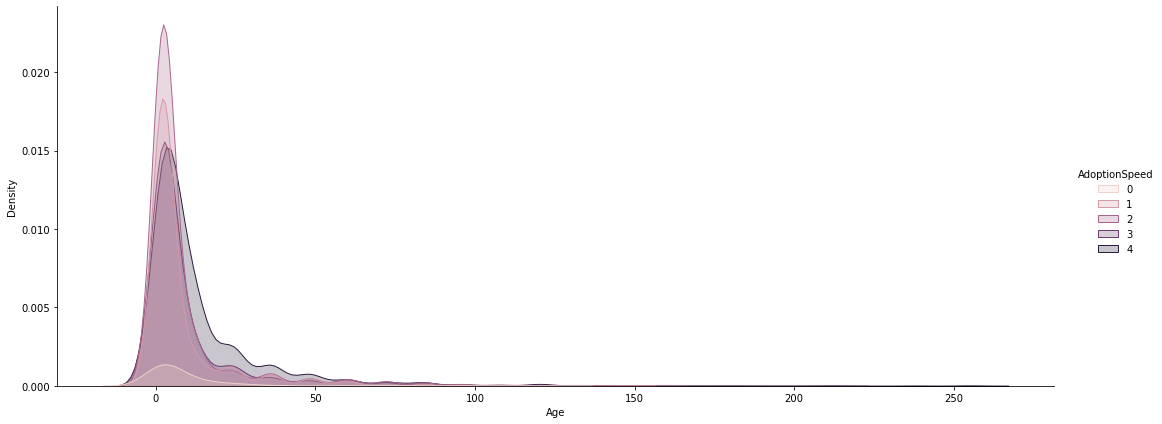

---------------------------------------------------------------
Column: Quantity
Number of missing values: 0
Unique values: 18

count    11994.000000
mean         1.592880
std          1.511043
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         20.000000
Name: Quantity, dtype: float64

Percentiles: 0.01: 1.0, 0.10: 1.0, 0.90: 3.0, 0.99: 7.069999999999709

All values:
    count      freq
1    9206  0.767550
2    1137  0.094797
3     601  0.050108
4     430  0.035851
5     268  0.022345
6     160  0.013340
7      72  0.006003
8      43  0.003585
9      25  0.002084
10     14  0.001167
20     12  0.001001
11      7  0.000584
12      6  0.000500
15      4  0.000334
16      3  0.000250
17      3  0.000250
14      2  0.000167
13      1  0.000083

stat=0.447, p=0.000
Probably not Gaussian

stat=17.997, p=0.000
Probably different distributions


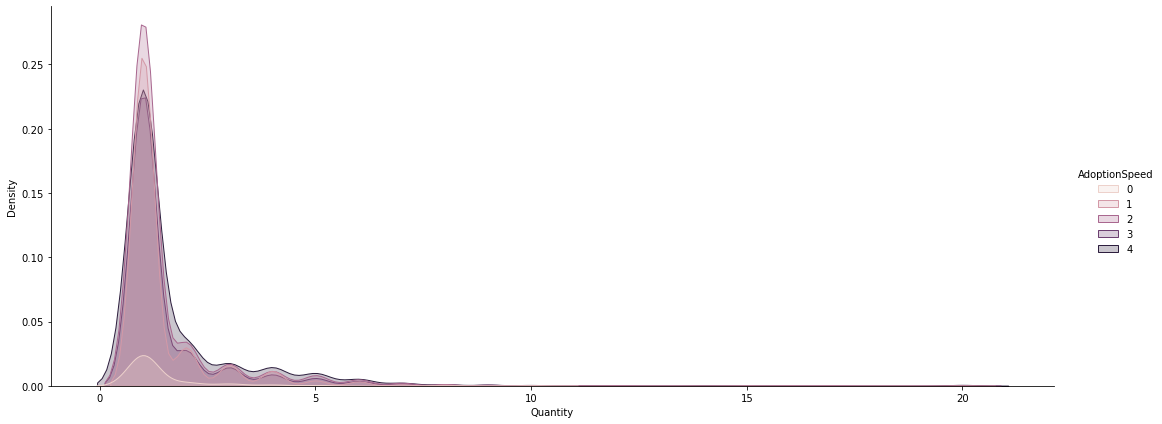

---------------------------------------------------------------
Column: Fee
Number of missing values: 0
Unique values: 69

count    11994.000000
mean        21.048191
std         79.132164
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3000.000000
Name: Fee, dtype: float64

Percentiles: 0.01: 0.0, 0.10: 0.0, 0.90: 50.0, 0.99: 350.0

Top 20 values:
     count      freq
0    10142  0.845589
50     376  0.031349
100    326  0.027180
200    170  0.014174
150    128  0.010672
20     106  0.008838
300     92  0.007671
30      80  0.006670
250     77  0.006420
1       69  0.005753
10      54  0.004502
80      52  0.004336
500     45  0.003752
350     38  0.003168
400     24  0.002001
15      20  0.001668
5       20  0.001668
40      18  0.001501
120     14  0.001167
600     10  0.000834

stat=0.287, p=0.000
Probably not Gaussian

stat=0.605, p=0.612
Probably the same distribution


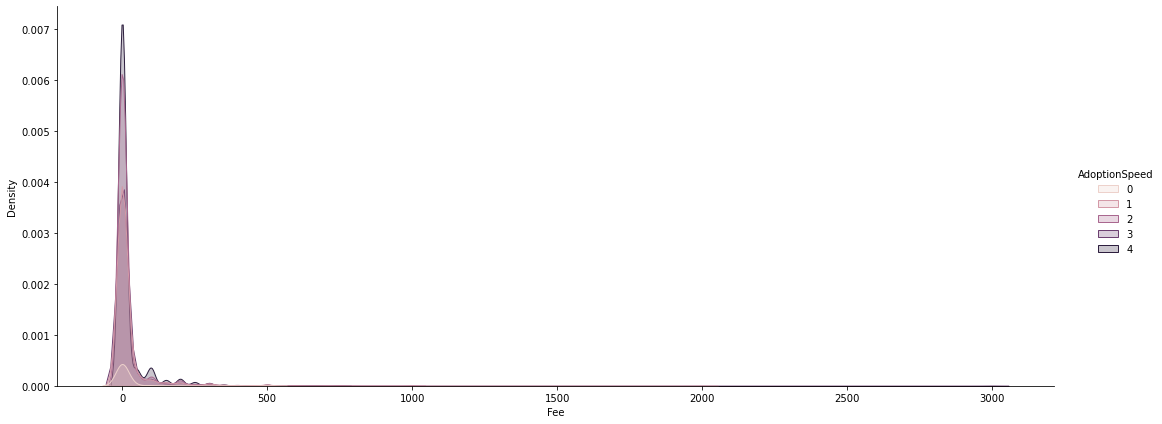

---------------------------------------------------------------
Column: VideoAmt
Number of missing values: 0
Unique values: 9

count    11994.000000
mean         0.059530
std          0.361987
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: VideoAmt, dtype: float64

Percentiles: 0.01: 0.0, 0.10: 0.0, 0.90: 0.0, 0.99: 2.0

All values:
   count      freq
0  11526  0.960980
1    331  0.027597
2     79  0.006587
3     32  0.002668
4     13  0.001084
5      6  0.000500
6      4  0.000334
8      2  0.000167
7      1  0.000083

stat=0.155, p=0.000
Probably not Gaussian

stat=3.609, p=0.013
Probably different distributions


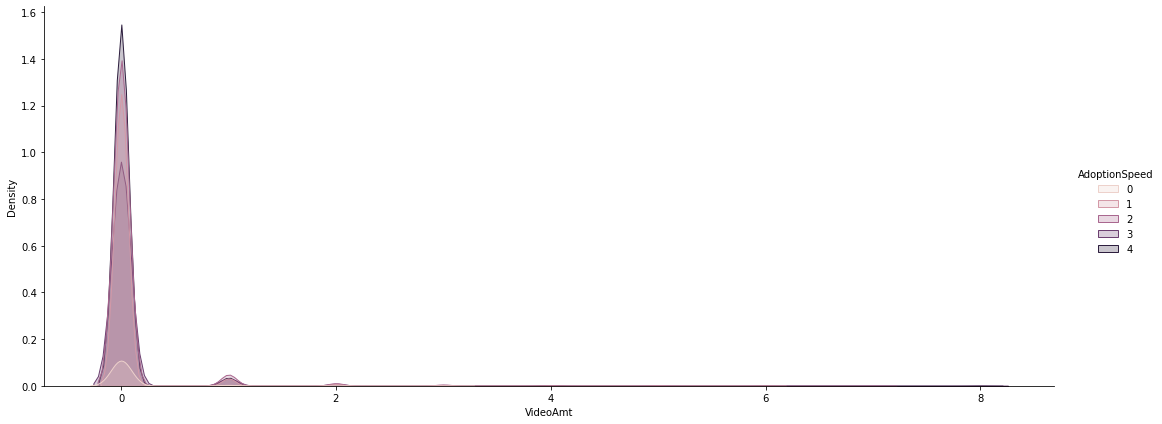

---------------------------------------------------------------
Column: PhotoAmt
Number of missing values: 0
Unique values: 31

count    11994.000000
mean         3.902118
std          3.483916
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         30.000000
Name: PhotoAmt, dtype: float64

Percentiles: 0.01: 0.0, 0.10: 1.0, 0.90: 7.0, 0.99: 19.0

Top 20 values:
      count      freq
1.0    2427  0.202351
3.0    2015  0.168001
2.0    2003  0.167000
5.0    1752  0.146073
4.0    1502  0.125229
6.0     498  0.041521
7.0     355  0.029598
0.0     273  0.022761
8.0     256  0.021344
9.0     177  0.014757
11.0    154  0.012840
10.0    154  0.012840
13.0     67  0.005586
12.0     65  0.005419
14.0     59  0.004919
15.0     43  0.003585
16.0     30  0.002501
17.0     25  0.002084
20.0     23  0.001918
18.0     16  0.001334

stat=0.744, p=0.000
Probably not Gaussian

stat=61.451, p=0.000
Probably different distributions


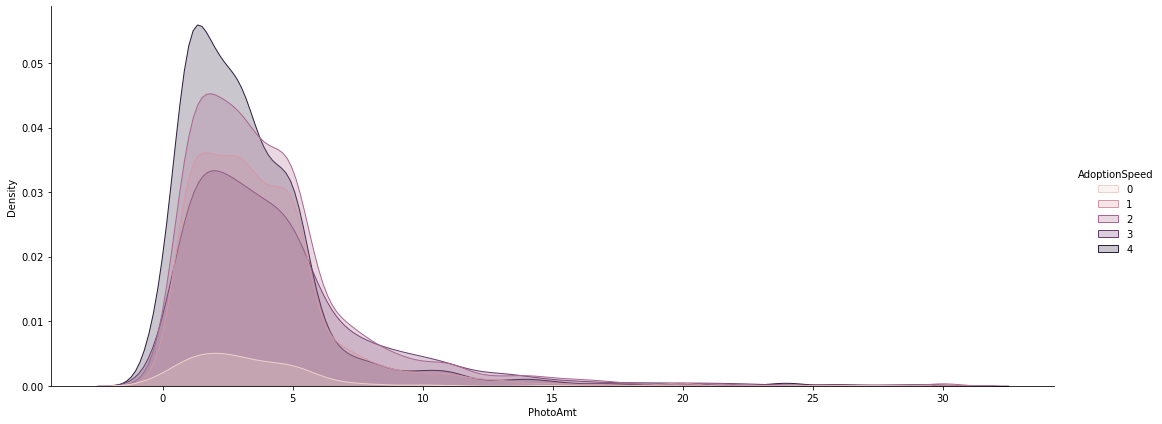

---------------------------------------------------------------
Column: sentiment
Number of missing values: 437
Unique values: 20

count    11557.000000
mean         0.279207
std          0.276652
min         -0.900000
25%          0.100000
50%          0.200000
75%          0.400000
max          0.900000
Name: sentiment, dtype: float64

Percentiles: 0.01: -0.3069999999999993, 0.10: 0.0, 0.90: 0.7, 0.99: 0.9

Top 20 values:
      count      freq
 0.0   1874  0.162153
 0.3   1744  0.150904
 0.2   1738  0.150385
 0.1   1579  0.136627
 0.4   1267  0.109631
 0.5    921  0.079692
 0.6    567  0.049061
 0.9    502  0.043437
 0.8    409  0.035390
 0.7    368  0.031842
-0.1    244  0.021113
-0.2    140  0.012114
-0.3     84  0.007268
-0.4     33  0.002855
-0.5     29  0.002509
-0.6     25  0.002163
-0.7     14  0.001211
-0.8     12  0.001038
-0.9      7  0.000606

stat=0.954, p=0.000
Probably not Gaussian

stat=10.088, p=0.000
Probably different distributions


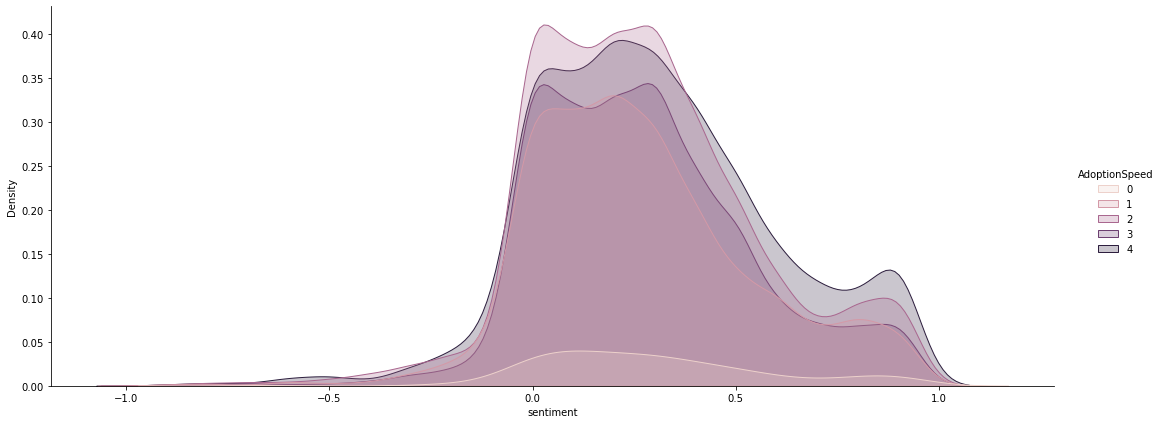

---------------------------------------------------------------
Column: magnitude
Number of missing values: 437
Unique values: 163

count    11557.000000
mean         2.144493
std          2.070145
min          0.000000
25%          0.800000
50%          1.700000
75%          2.800000
max         32.000000
Name: magnitude, dtype: float64

Percentiles: 0.01: 0.0, 0.10: 0.3, 0.90: 4.3, 0.99: 10.0

Top 20 values:
     count      freq
0.9    649  0.056156
0.8    490  0.042399
0.0    465  0.040235
1.1    341  0.029506
1.0    337  0.029160
1.8    334  0.028900
1.2    331  0.028641
1.3    323  0.027948
0.1    322  0.027862
0.7    316  0.027343
1.7    316  0.027343
0.2    305  0.026391
1.6    300  0.025958
1.4    300  0.025958
1.9    290  0.025093
1.5    271  0.023449
0.5    267  0.023103
0.3    262  0.022670
0.6    261  0.022584
2.0    249  0.021545

stat=0.768, p=0.000
Probably not Gaussian

stat=9.554, p=0.000
Probably different distributions


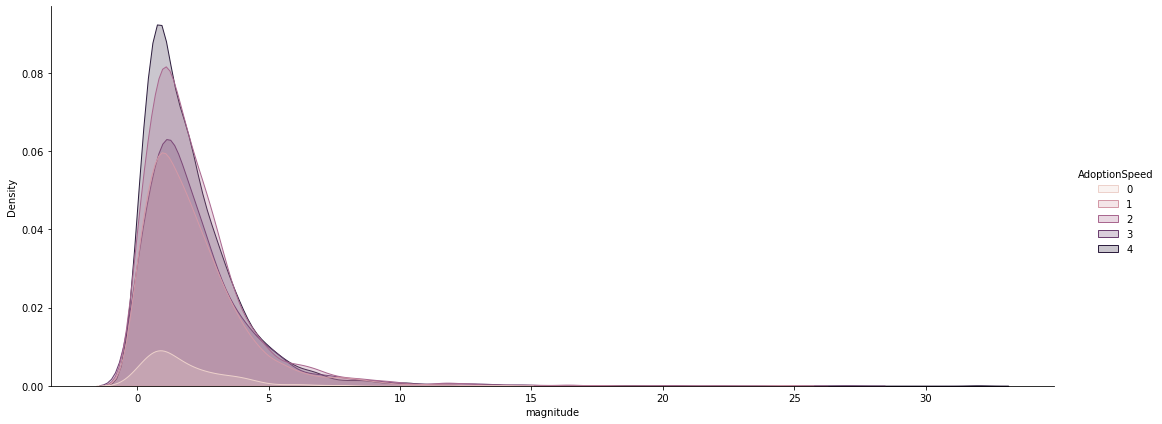

---------------------------------------------------------------
Column: combined_sentiment
Number of missing values: 437
Unique values: 441

count    11557.000000
mean         0.613088
std          0.760286
min         -1.890000
25%          0.040000
50%          0.420000
75%          0.850000
max          9.100000
Name: combined_sentiment, dtype: float64

Percentiles: 0.01: -0.39069999999999994, 0.10: 0.0, 0.90: 1.54, 0.99: 3.2827999999999884

Top 20 values:
      count      freq
0.00   1874  0.162153
0.81    432  0.037380
0.36    321  0.027775
0.64    296  0.025612
0.01    202  0.017479
0.04    180  0.015575
0.16    156  0.013498
0.50    152  0.013152
0.09    142  0.012287
0.18    133  0.011508
0.48    122  0.010556
0.32    119  0.010297
0.25    115  0.009951
0.49    114  0.009864
0.30    113  0.009778
1.08    111  0.009605
0.24    106  0.009172
0.33    105  0.009085
0.22    102  0.008826
0.26    102  0.008826

stat=0.820, p=0.000
Probably not Gaussian

stat=3.639, p=0.012
Probably d

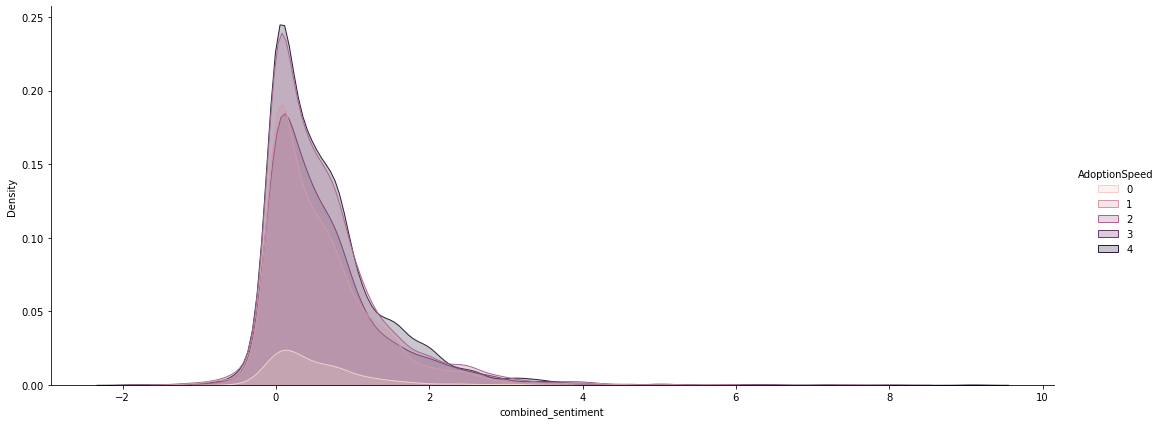

---------------------------------------------------------------
Column: number_of_sentences
Number of missing values: 437
Unique values: 54

count    11557.000000
mean         5.164056
std          4.891900
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         84.000000
Name: number_of_sentences, dtype: float64

Percentiles: 0.01: 1.0, 0.10: 1.0, 0.90: 10.0, 0.99: 24.0

Top 20 values:
      count      freq
1.0    2079  0.179891
3.0    1526  0.132041
2.0    1498  0.129618
4.0    1392  0.120446
5.0    1142  0.098815
6.0     943  0.081596
7.0     745  0.064463
8.0     512  0.044302
9.0     351  0.030371
10.0    277  0.023968
11.0    218  0.018863
12.0    176  0.015229
13.0    121  0.010470
14.0     97  0.008393
15.0     82  0.007095
16.0     61  0.005278
18.0     45  0.003894
17.0     43  0.003721
19.0     32  0.002769
21.0     29  0.002509

stat=0.711, p=0.000
Probably not Gaussian

stat=15.662, p=0.000
Probably different distributions


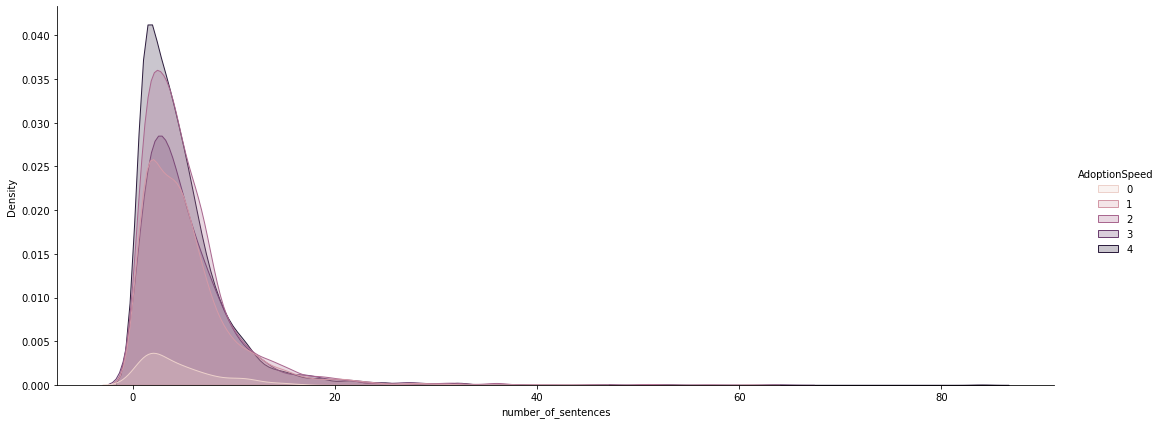

---------------------------------------------------------------
Column: avg_sentence_score
Number of missing values: 437
Unique values: 1014

count    11557.000000
mean         0.291293
std          0.274029
min         -0.900000
25%          0.100000
50%          0.271429
75%          0.450000
max          0.900000
Name: avg_sentence_score, dtype: float64

Percentiles: 0.01: -0.35, 0.10: 0.0, 0.90: 0.6749999999999999, 0.99: 0.9

Top 20 values:
          count      freq
0.000000    586  0.050705
0.300000    505  0.043696
0.900000    449  0.038851
0.100000    408  0.035303
0.200000    344  0.029766
0.500000    338  0.029246
0.800000    293  0.025353
0.400000    259  0.022411
0.600000    215  0.018603
0.350000    190  0.016440
0.250000    189  0.016354
0.150000    187  0.016181
0.700000    169  0.014623
0.450000    167  0.014450
0.333333    154  0.013325
0.266667    137  0.011854
0.233333    129  0.011162
0.400000    123  0.010643
0.050000    113  0.009778
0.550000    107  0.009258

stat

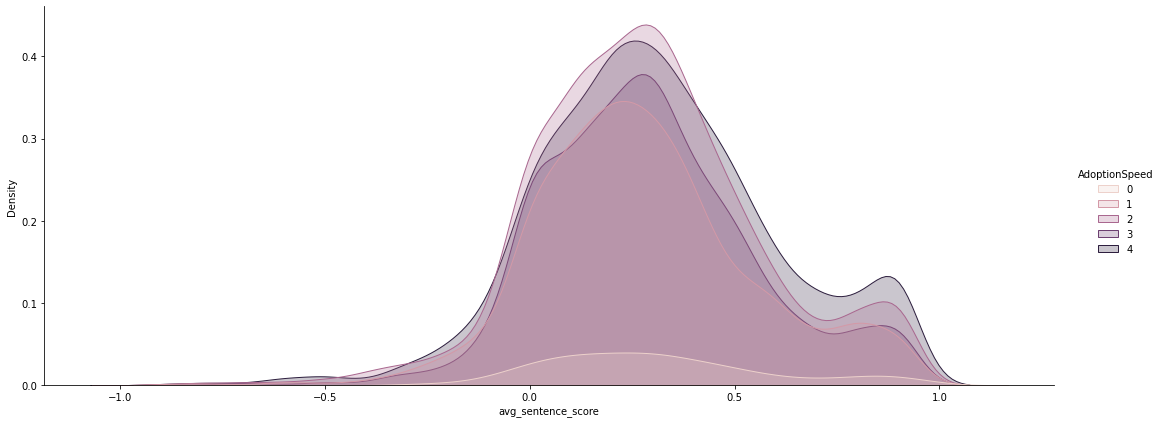

---------------------------------------------------------------
Column: min_sentence_score
Number of missing values: 437
Unique values: 20

count    11557.000000
mean        -0.091425
std          0.432039
min         -0.900000
25%         -0.400000
50%          0.000000
75%          0.100000
max          0.900000
Name: min_sentence_score, dtype: float64

Percentiles: 0.01: -0.9, 0.10: -0.7, 0.90: 0.5, 0.99: 0.9

Top 20 values:
      count      freq
 0.0   3063  0.265034
-0.1    868  0.075106
 0.1    798  0.069049
-0.2    749  0.064809
-0.4    672  0.058147
-0.6    636  0.055032
-0.3    624  0.053993
-0.5    622  0.053820
-0.7    544  0.047071
 0.9    449  0.038851
-0.8    439  0.037986
 0.2    432  0.037380
 0.8    336  0.029073
-0.9    307  0.026564
 0.3    290  0.025093
 0.7    207  0.017911
 0.6    201  0.017392
 0.5    173  0.014969
 0.4    147  0.012720

stat=0.944, p=0.000
Probably not Gaussian

stat=13.223, p=0.000
Probably different distributions


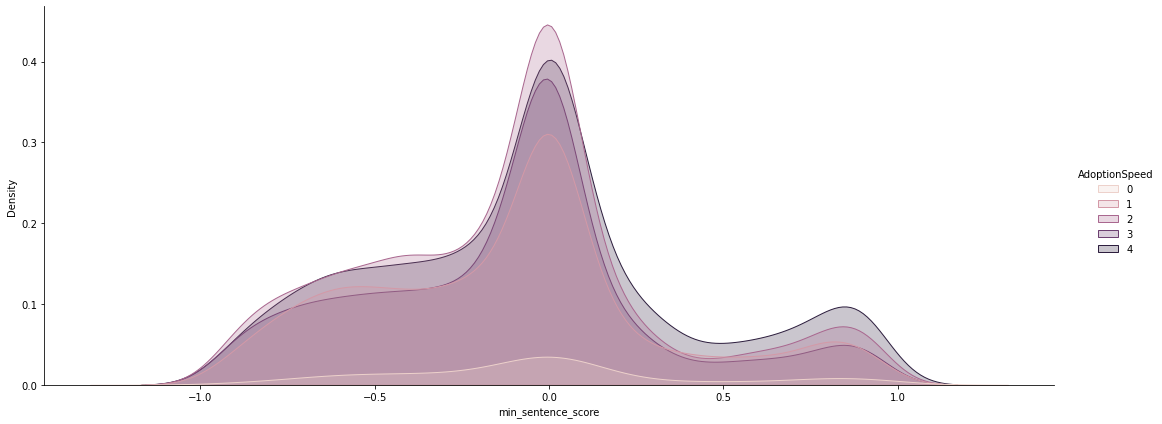

---------------------------------------------------------------
Column: max_sentence_score
Number of missing values: 437
Unique values: 20

count    11557.000000
mean         0.665276
std          0.322135
min         -0.900000
25%          0.500000
50%          0.800000
75%          0.900000
max          0.900000
Name: max_sentence_score, dtype: float64

Percentiles: 0.01: -0.3, 0.10: 0.1, 0.90: 0.8999999999999999, 0.99: 0.9

Top 20 values:
      count      freq
 0.9   5043  0.436359
 0.8   1997  0.172796
 0.7    973  0.084191
 0.0    655  0.056676
 0.6    604  0.052263
 0.1    481  0.041620
 0.5    428  0.037034
 0.3    414  0.035822
 0.2    410  0.035476
 0.4    311  0.026910
-0.1     58  0.005019
-0.2     49  0.004240
-0.3     35  0.003028
-0.5     26  0.002250
-0.4     24  0.002077
-0.6     17  0.001471
-0.7     13  0.001125
-0.8     12  0.001038
-0.9      7  0.000606

stat=0.743, p=0.000
Probably not Gaussian

stat=2.756, p=0.041
Probably different distributions


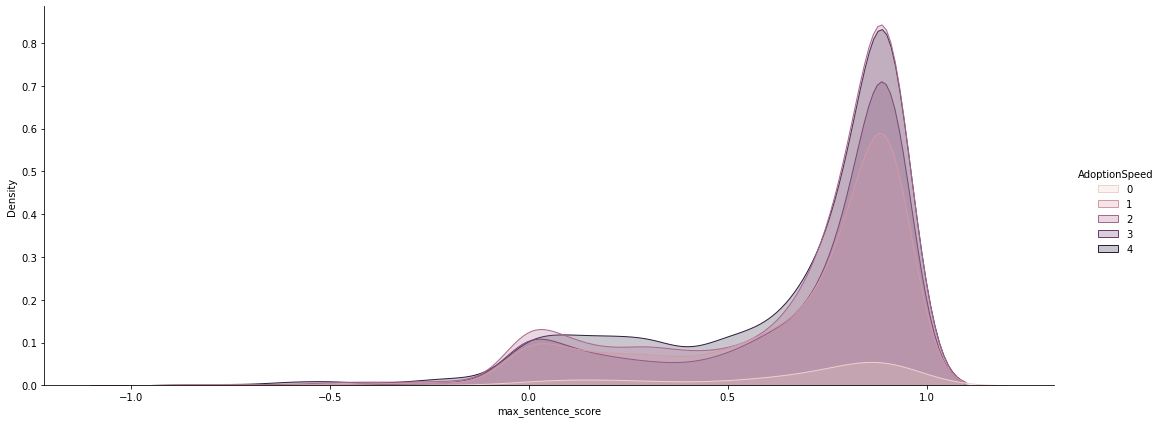

---------------------------------------------------------------
Column: sum_sentence_score
Number of missing values: 437
Unique values: 359

count    11557.000000
mean         1.281379
std          1.420176
min         -5.500000
25%          0.400000
50%          1.000000
75%          1.900000
max         17.300000
Name: sum_sentence_score, dtype: float64

Percentiles: 0.01: -1.1, 0.10: 0.0, 0.90: 2.9, 0.99: 6.199999999999999

Top 20 values:
     count      freq
0.9    669  0.057887
0.0    586  0.050705
0.8    517  0.044735
0.1    386  0.033400
0.7    369  0.031929
1.0    362  0.031323
1.1    340  0.029419
0.3    315  0.027256
0.2    315  0.027256
1.6    315  0.027256
0.5    290  0.025093
1.5    281  0.024314
1.4    279  0.024141
0.6    276  0.023882
1.3    227  0.019642
0.4    226  0.019555
1.9    209  0.018084
1.7    202  0.017479
2.1    199  0.017219
1.2    199  0.017219

stat=0.872, p=0.000
Probably not Gaussian

stat=5.571, p=0.001
Probably different distributions


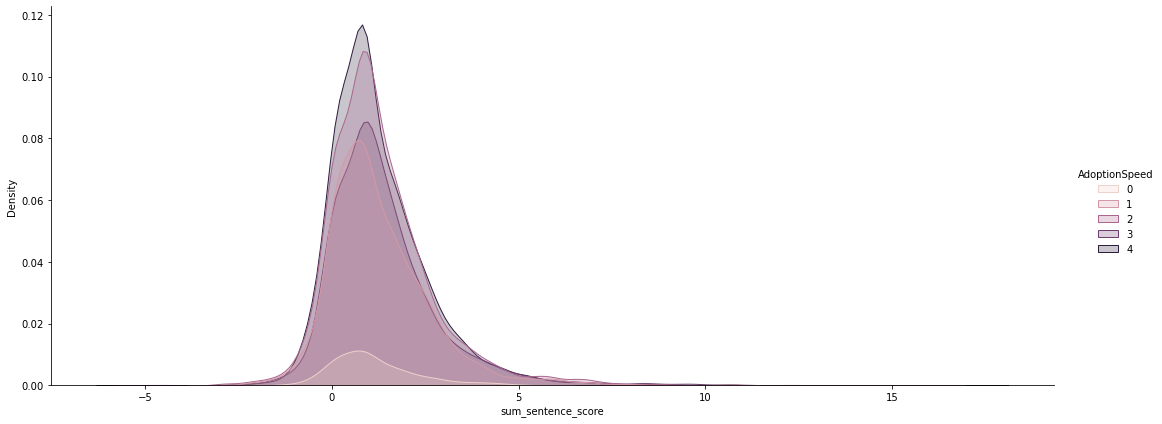

---------------------------------------------------------------
Column: score_0
Number of missing values: 274
Unique values: 11540

count    11720.000000
mean         0.971785
std          0.028159
min          0.517198
25%          0.958822
50%          0.979030
75%          0.992409
max          0.995285
Name: score_0, dtype: float64

Percentiles: 0.01: 0.8826924675, 0.10: 0.94128335, 0.90: 0.993894891, 0.99: 0.994801721

Top 20 values:
          count      freq
0.992456      3  0.000256
0.981346      3  0.000256
0.993829      3  0.000256
0.993855      3  0.000256
0.994213      2  0.000171
0.993750      2  0.000171
0.993285      2  0.000171
0.992942      2  0.000171
0.991305      2  0.000171
0.937339      2  0.000171
0.903704      2  0.000171
0.985909      2  0.000171
0.993944      2  0.000171
0.993336      2  0.000171
0.992473      2  0.000171
0.993432      2  0.000171
0.993426      2  0.000171
0.994538      2  0.000171
0.989794      2  0.000171
0.993923      2  0.000171

stat=0.697

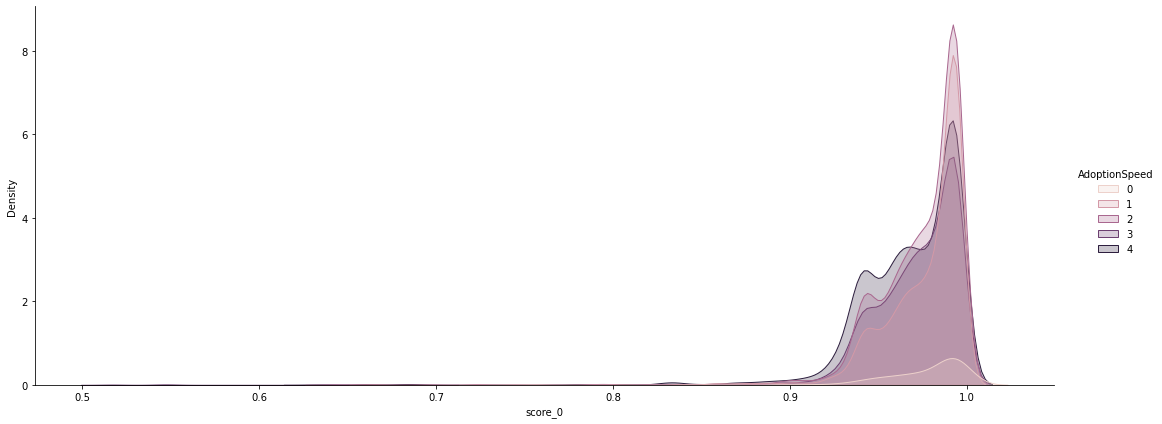

---------------------------------------------------------------
Column: score_1
Number of missing values: 281
Unique values: 11580

count    11713.000000
mean         0.930032
std          0.030941
min          0.507397
25%          0.922523
50%          0.930909
75%          0.942803
max          0.986769
Name: score_1, dtype: float64

Percentiles: 0.01: 0.8014311685000001, 0.10: 0.91453955, 0.90: 0.956742255, 0.99: 0.9695294190000001

Top 20 values:
          count      freq
0.903704      4  0.000342
0.903704      4  0.000342
0.925690      3  0.000256
0.923384      3  0.000256
0.923910      3  0.000256
0.924952      2  0.000171
0.968869      2  0.000171
0.940148      2  0.000171
0.921948      2  0.000171
0.943387      2  0.000171
0.930940      2  0.000171
0.943458      2  0.000171
0.922815      2  0.000171
0.967359      2  0.000171
0.942197      2  0.000171
0.924895      2  0.000171
0.983051      2  0.000171
0.924640      2  0.000171
0.943240      2  0.000171
0.964191      2  0.00017

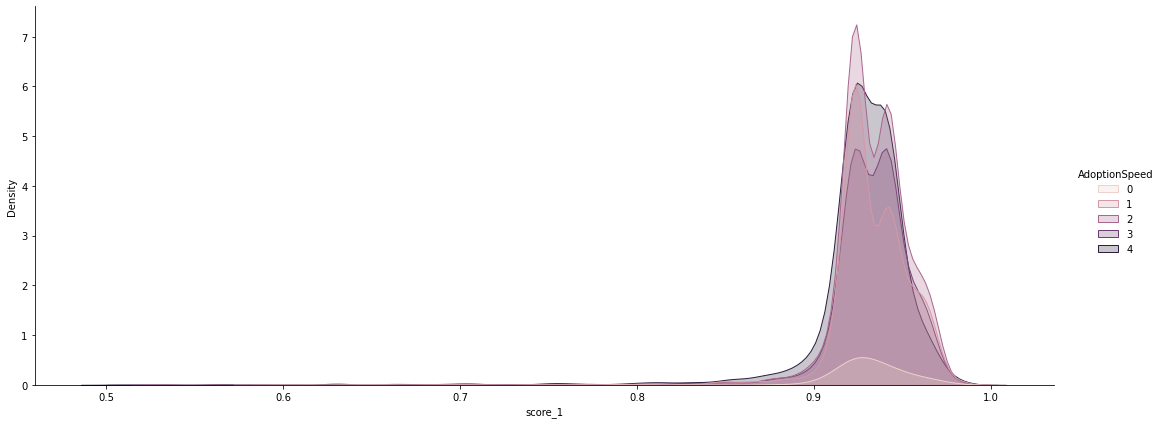

---------------------------------------------------------------
Column: score_2
Number of missing values: 292
Unique values: 11576

count    11702.000000
mean         0.903585
std          0.044754
min          0.501262
25%          0.895477
50%          0.913123
75%          0.925879
max          0.968377
Name: score_2, dtype: float64

Percentiles: 0.01: 0.714553793, 0.10: 0.86463616, 0.90: 0.9414356080000001, 0.99: 0.9437847004

Top 20 values:
          count      freq
0.903704     23  0.001965
0.903704     16  0.001367
0.942186      3  0.000256
0.943477      3  0.000256
0.942302      2  0.000171
0.922703      2  0.000171
0.845744      2  0.000171
0.942918      2  0.000171
0.913959      2  0.000171
0.905303      2  0.000171
0.915255      2  0.000171
0.877400      2  0.000171
0.941172      2  0.000171
0.923053      2  0.000171
0.941187      2  0.000171
0.930369      2  0.000171
0.925724      2  0.000171
0.901630      2  0.000171
0.923144      2  0.000171
0.921782      2  0.000171

sta

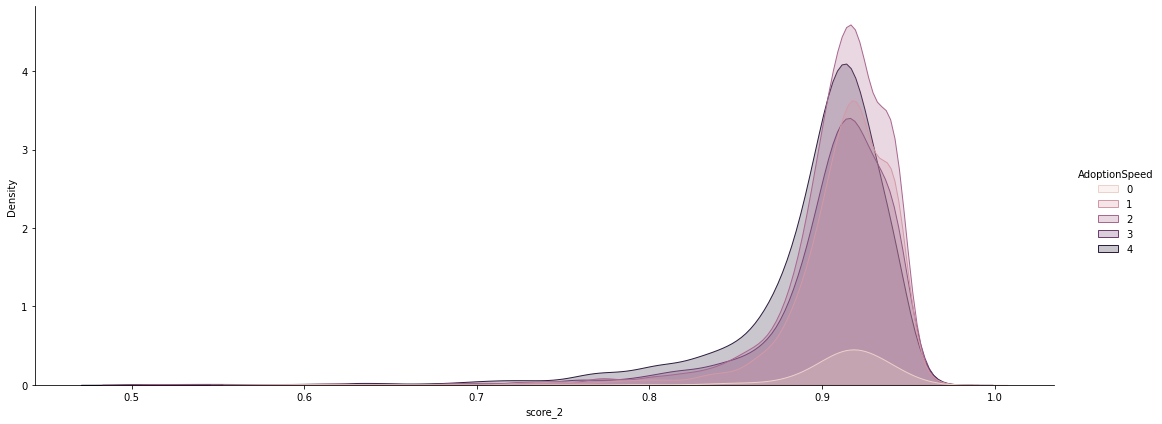

---------------------------------------------------------------
Column: score_3
Number of missing values: 311
Unique values: 11467

count    11683.000000
mean         0.859822
std          0.063371
min          0.504652
25%          0.832134
50%          0.878996
75%          0.906705
max          0.958145
Name: score_3, dtype: float64

Percentiles: 0.01: 0.6374593222, 0.10: 0.776862739, 0.90: 0.91623798, 0.99: 0.931212587

Top 20 values:
          count      freq
0.903704     83  0.007104
0.903704     66  0.005649
0.916562      3  0.000257
0.817674      2  0.000171
0.904968      2  0.000171
0.916080      2  0.000171
0.915796      2  0.000171
0.915923      2  0.000171
0.842983      2  0.000171
0.877604      2  0.000171
0.872434      2  0.000171
0.915923      2  0.000171
0.892624      2  0.000171
0.924162      2  0.000171
0.907374      2  0.000171
0.915227      2  0.000171
0.922894      2  0.000171
0.916562      2  0.000171
0.916092      2  0.000171
0.917711      2  0.000171

stat=0.845

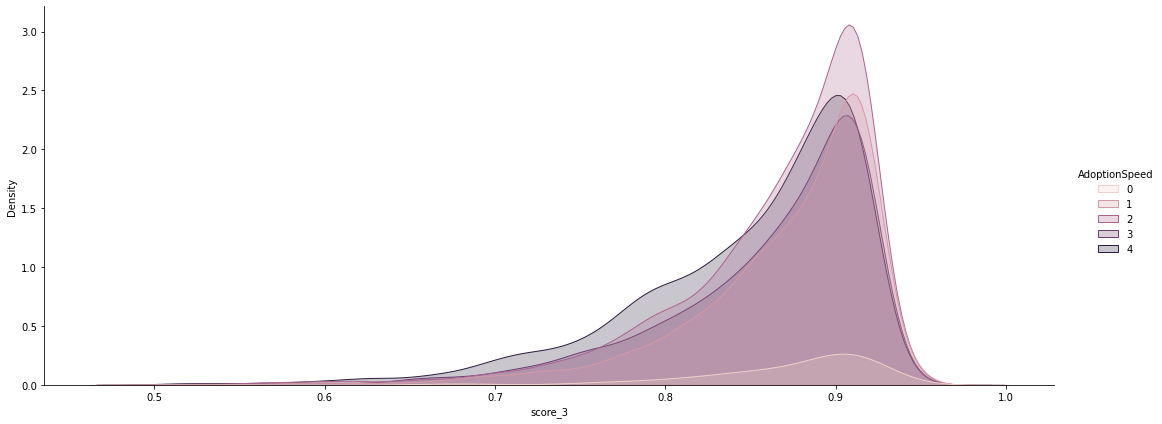

---------------------------------------------------------------
Column: score_4
Number of missing values: 344
Unique values: 11366

count    11650.000000
mean         0.793202
std          0.080058
min          0.500311
25%          0.742848
50%          0.800159
75%          0.855415
max          0.951075
Name: score_4, dtype: float64

Percentiles: 0.01: 0.5697652262, 0.10: 0.68745739, 0.90: 0.894726035, 0.99: 0.9221219541

Top 20 values:
          count      freq
0.903704    128  0.010987
0.903704     95  0.008155
0.604277     28  0.002403
0.817674      3  0.000258
0.600802      2  0.000172
0.758744      2  0.000172
0.778517      2  0.000172
0.765635      2  0.000172
0.595300      2  0.000172
0.828131      2  0.000172
0.793752      2  0.000172
0.742657      2  0.000172
0.828672      2  0.000172
0.863491      2  0.000172
0.838201      2  0.000172
0.880588      2  0.000172
0.866586      2  0.000172
0.724819      2  0.000172
0.856425      2  0.000172
0.903704      2  0.000172

stat=0.97

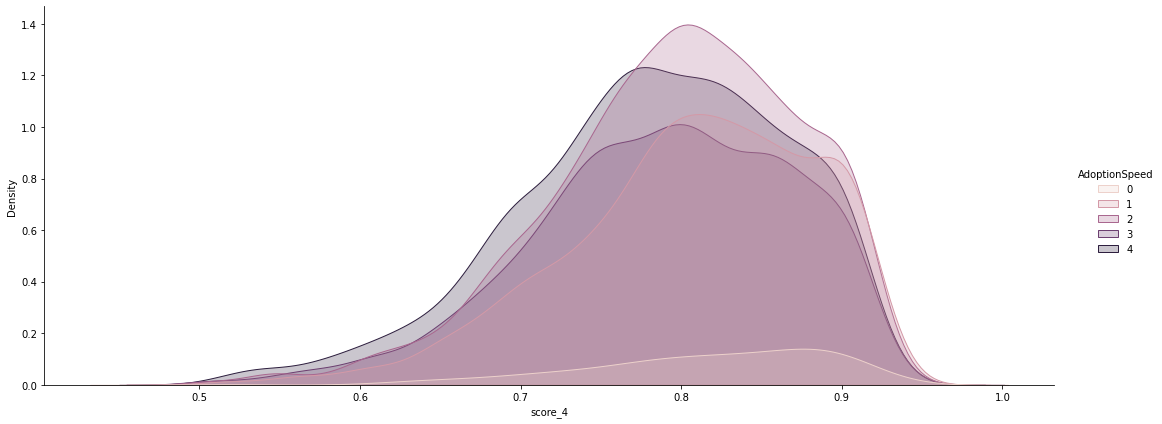

---------------------------------------------------------------
Column: score_5
Number of missing values: 454
Unique values: 11298

count    11540.000000
mean         0.735583
std          0.086234
min          0.500034
25%          0.678028
50%          0.740279
75%          0.794594
max          0.942726
Name: score_5, dtype: float64

Percentiles: 0.01: 0.5301159317, 0.10: 0.61907931, 0.90: 0.84500628, 0.99: 0.9063735190000001

Top 20 values:
          count      freq
0.604277    125  0.010832
0.903704     58  0.005026
0.903704     25  0.002166
0.817674      5  0.000433
0.629066      2  0.000173
0.645599      2  0.000173
0.710260      2  0.000173
0.674148      2  0.000173
0.800543      2  0.000173
0.528864      2  0.000173
0.689749      2  0.000173
0.702057      2  0.000173
0.722297      2  0.000173
0.772989      2  0.000173
0.756714      2  0.000173
0.754092      2  0.000173
0.763284      2  0.000173
0.677268      2  0.000173
0.597842      2  0.000173
0.780544      2  0.000173

stat

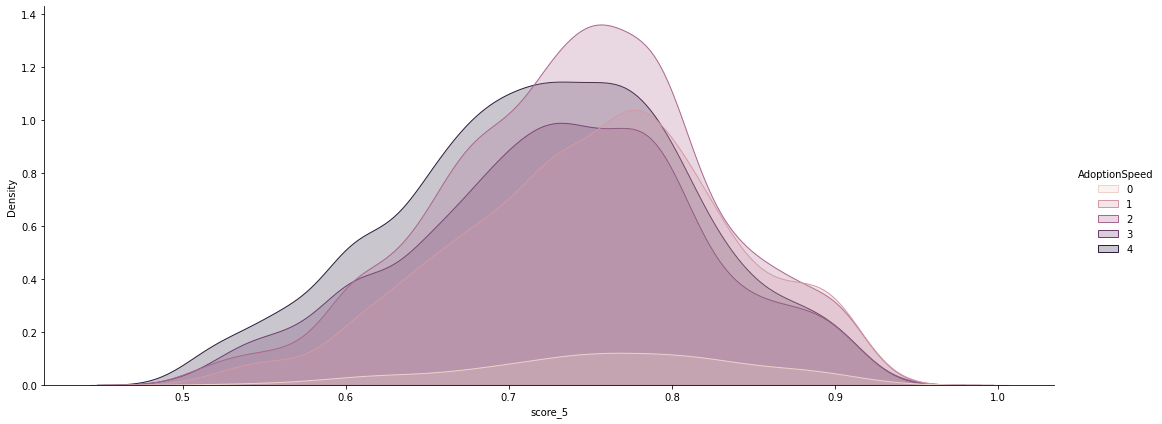

---------------------------------------------------------------
Column: score_6
Number of missing values: 705
Unique values: 10970

count    11289.000000
mean         0.686273
std          0.087824
min          0.500107
25%          0.618608
50%          0.684065
75%          0.750870
max          0.938362
Name: score_6, dtype: float64

Percentiles: 0.01: 0.5133063902, 0.10: 0.57398465, 0.90: 0.797582078, 0.99: 0.8864923615

Top 20 values:
          count      freq
0.604277    275  0.024360
0.903704      9  0.000797
0.903704      4  0.000354
0.689083      2  0.000177
0.786577      2  0.000177
0.525000      2  0.000177
0.814797      2  0.000177
0.648410      2  0.000177
0.797274      2  0.000177
0.613534      2  0.000177
0.813946      2  0.000177
0.684911      2  0.000177
0.789445      2  0.000177
0.706412      2  0.000177
0.762312      2  0.000177
0.700858      2  0.000177
0.605754      2  0.000177
0.774862      2  0.000177
0.681934      2  0.000177
0.715849      2  0.000177

stat=0.99

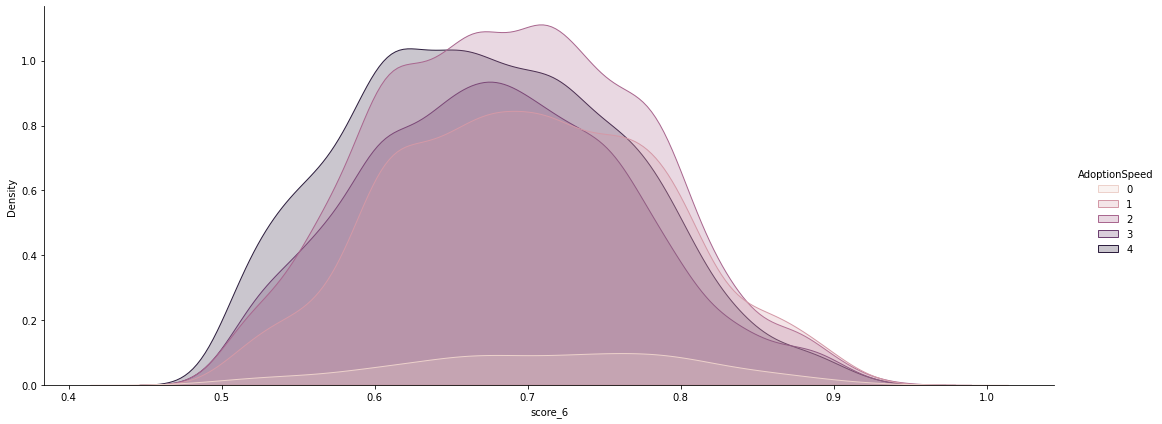

---------------------------------------------------------------
Column: score_7
Number of missing values: 1248
Unique values: 10410

count    10746.000000
mean         0.649308
std          0.084245
min          0.500079
25%          0.585881
50%          0.639143
75%          0.707709
max          0.925788
Name: score_7, dtype: float64

Percentiles: 0.01: 0.5062552971, 0.10: 0.5476801849999999, 0.90: 0.7622624400000001, 0.99: 0.8591588733

Top 20 values:
          count      freq
0.604277    305  0.028383
0.519981      2  0.000186
0.711090      2  0.000186
0.528376      2  0.000186
0.626976      2  0.000186
0.540118      2  0.000186
0.585107      2  0.000186
0.817674      2  0.000186
0.618818      2  0.000186
0.760647      2  0.000186
0.731943      2  0.000186
0.752340      2  0.000186
0.582442      2  0.000186
0.575336      2  0.000186
0.785716      2  0.000186
0.725489      2  0.000186
0.689941      2  0.000186
0.656570      2  0.000186
0.638717      2  0.000186
0.524663      2  0.0

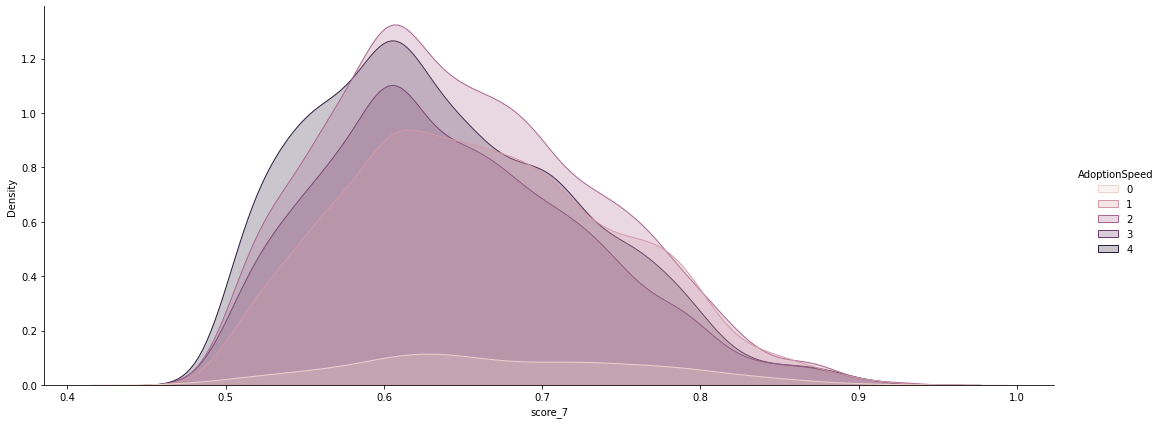

---------------------------------------------------------------
Column: score_8
Number of missing values: 2143
Unique values: 9594

count    9851.000000
mean        0.622208
std         0.079158
min         0.500014
25%         0.560586
50%         0.607582
75%         0.673331
max         0.925449
Name: score_8, dtype: float64

Percentiles: 0.01: 0.5033290739, 0.10: 0.53159204, 0.90: 0.727065855, 0.99: 0.8182793258

Top 20 values:
          count      freq
0.604277    225  0.022840
0.547529      2  0.000203
0.692379      2  0.000203
0.633374      2  0.000203
0.903704      2  0.000203
0.725736      2  0.000203
0.726401      2  0.000203
0.580697      2  0.000203
0.568890      2  0.000203
0.555648      2  0.000203
0.647339      2  0.000203
0.513388      2  0.000203
0.630370      2  0.000203
0.657091      2  0.000203
0.599398      2  0.000203
0.576880      2  0.000203
0.547980      2  0.000203
0.817674      2  0.000203
0.629462      2  0.000203
0.694622      2  0.000203

stat=0.945, p=0.0

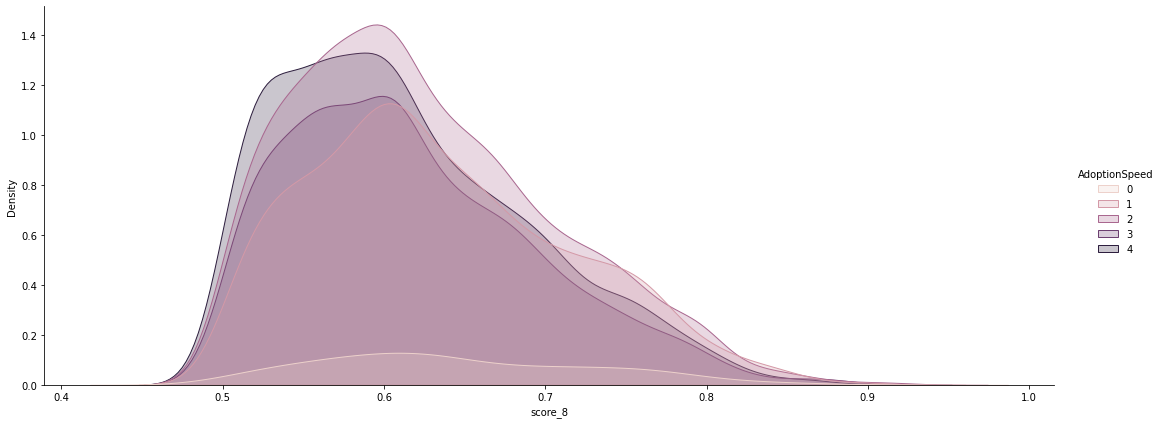

---------------------------------------------------------------
Column: score_9
Number of missing values: 3434
Unique values: 8350

count    8560.000000
mean        0.604477
std         0.073783
min         0.500013
25%         0.546112
50%         0.591529
75%         0.649316
max         0.914087
Name: score_9, dtype: float64

Percentiles: 0.01: 0.5026773360000001, 0.10: 0.52615296, 0.90: 0.6910976, 0.99: 0.7931833442

Top 20 values:
          count      freq
0.604277    190  0.022196
0.544398      2  0.000234
0.510713      2  0.000234
0.569733      2  0.000234
0.627982      2  0.000234
0.759820      2  0.000234
0.671106      2  0.000234
0.578484      2  0.000234
0.524718      2  0.000234
0.541978      2  0.000234
0.756118      2  0.000234
0.634961      2  0.000234
0.568093      2  0.000234
0.612305      2  0.000234
0.527712      2  0.000234
0.575003      2  0.000234
0.665937      2  0.000234
0.517643      2  0.000234
0.690794      2  0.000234
0.510093      2  0.000234

stat=0.904, p

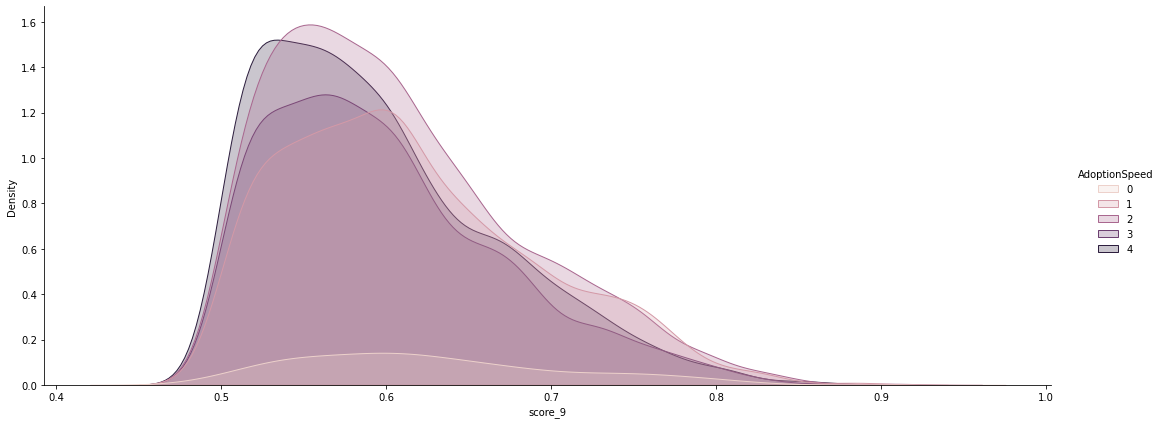

---------------------------------------------------------------
Column: red_0
Number of missing values: 273
Unique values: 252

count    11721.000000
mean       129.233257
std         68.063323
min          1.000000
25%         71.000000
50%        134.000000
75%        184.000000
max        254.000000
Name: red_0, dtype: float64

Percentiles: 0.01: 14.0, 0.10: 25.0, 0.90: 217.0, 0.99: 248.0

Top 20 values:
       count      freq
25.0     154  0.013139
24.0     146  0.012456
23.0     133  0.011347
162.0    122  0.010409
163.0    121  0.010323
26.0     118  0.010067
159.0    116  0.009897
27.0     112  0.009555
161.0    112  0.009555
157.0    110  0.009385
124.0    109  0.009300
22.0     105  0.008958
160.0    104  0.008873
21.0     104  0.008873
123.0    101  0.008617
126.0     98  0.008361
28.0      97  0.008276
164.0     97  0.008276
122.0     96  0.008190
20.0      95  0.008105

stat=0.958, p=0.000
Probably not Gaussian

stat=0.771, p=0.510
Probably the same distribution


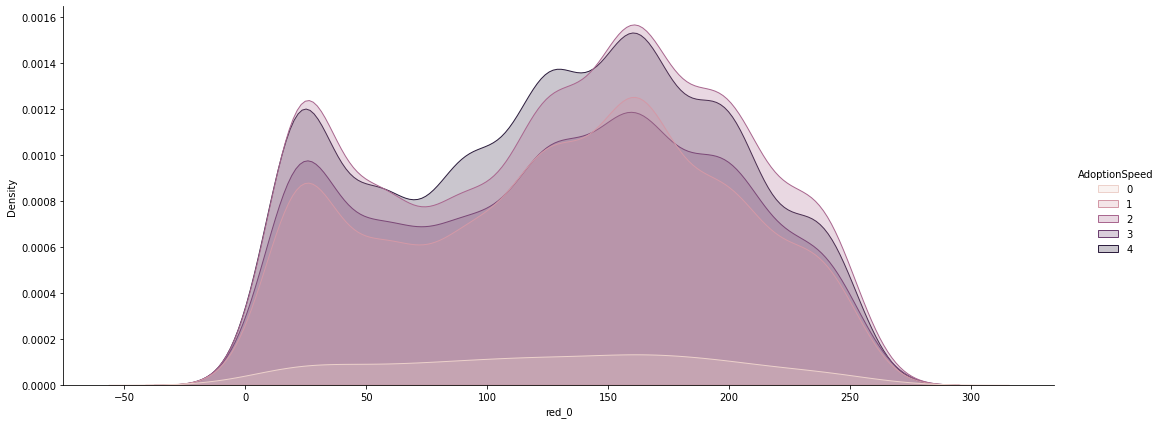

---------------------------------------------------------------
Column: green_0
Number of missing values: 274
Unique values: 252

count    11720.000000
mean       120.949829
std         68.045270
min          1.000000
25%         55.000000
50%        120.000000
75%        170.250000
max        253.000000
Name: green_0, dtype: float64

Percentiles: 0.01: 11.930000000000007, 0.10: 22.0, 0.90: 203.0, 0.99: 246.0

Top 20 values:
       count      freq
155.0    185  0.015785
118.0    181  0.015444
154.0    171  0.014590
119.0    170  0.014505
156.0    169  0.014420
157.0    165  0.014078
20.0     161  0.013737
153.0    159  0.013567
158.0    158  0.013481
117.0    155  0.013225
120.0    155  0.013225
22.0     154  0.013140
21.0     150  0.012799
116.0    142  0.012116
23.0     139  0.011860
152.0    135  0.011519
84.0     135  0.011519
121.0    134  0.011433
19.0     133  0.011348
24.0     132  0.011263

stat=0.957, p=0.000
Probably not Gaussian

stat=0.246, p=0.864
Probably the same distri

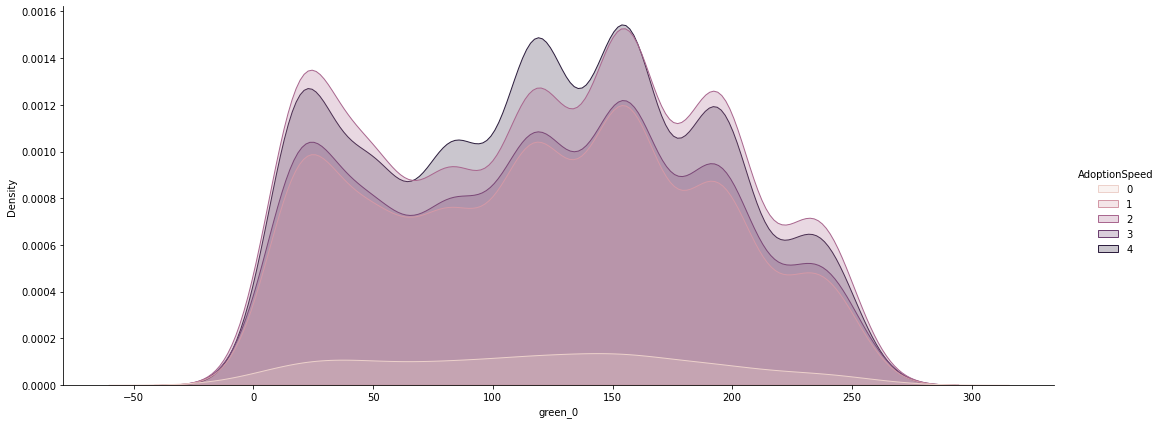

---------------------------------------------------------------
Column: blue_0
Number of missing values: 274
Unique values: 253

count    11720.000000
mean       112.011689
std         67.735136
min          2.000000
25%         51.000000
50%        113.000000
75%        161.000000
max        253.000000
Name: blue_0, dtype: float64

Percentiles: 0.01: 8.0, 0.10: 21.0, 0.90: 201.0, 0.99: 244.0

Top 20 values:
       count      freq
18.0     148  0.012628
21.0     140  0.011945
20.0     136  0.011604
22.0     127  0.010836
154.0    119  0.010154
152.0    110  0.009386
17.0     106  0.009044
19.0     104  0.008874
153.0    101  0.008618
15.0      99  0.008447
25.0      98  0.008362
151.0     98  0.008362
150.0     93  0.007935
155.0     92  0.007850
117.0     92  0.007850
113.0     92  0.007850
116.0     91  0.007765
149.0     90  0.007679
24.0      89  0.007594
115.0     88  0.007509

stat=0.959, p=0.000
Probably not Gaussian

stat=0.361, p=0.781
Probably the same distribution


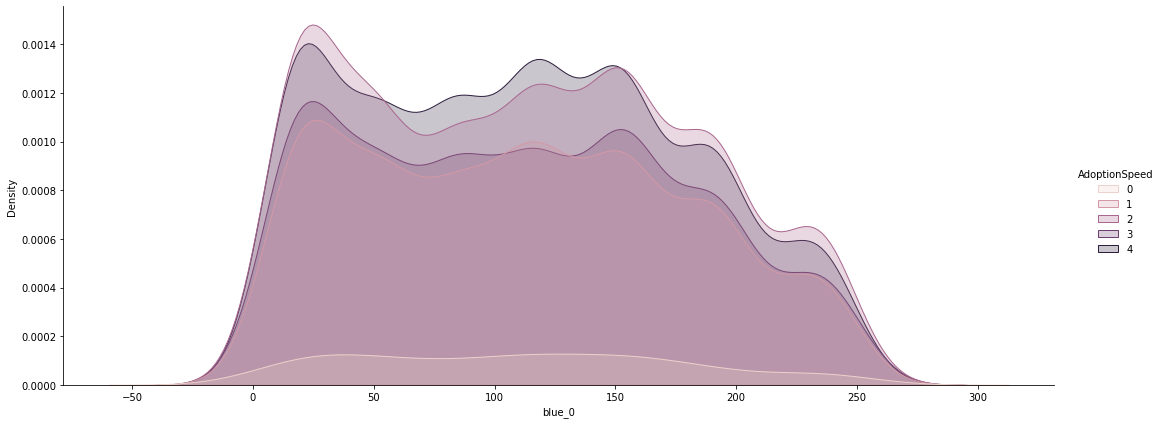

---------------------------------------------------------------
Column: color_pixel_share_0
Number of missing values: 273
Unique values: 9868

count    11721.000000
mean         0.215351
std          0.112895
min          0.012728
25%          0.134862
50%          0.193809
75%          0.271765
max          0.945225
Name: color_pixel_share_0, dtype: float64

Percentiles: 0.01: 0.04662941689, 0.10: 0.095050068, 0.90: 0.3611375940000001, 0.99: 0.5934087799999995

Top 20 values:
          count      freq
0.274194      7  0.000597
0.111342      5  0.000427
0.200746      5  0.000427
0.210284      5  0.000427
0.145161      5  0.000427
0.213840      5  0.000427
0.184270      5  0.000427
0.143861      5  0.000427
0.162791      5  0.000427
0.166927      5  0.000427
0.186091      5  0.000427
0.226327      5  0.000427
0.113510      5  0.000427
0.188345      5  0.000427
0.103013      5  0.000427
0.196237      5  0.000427
0.221644      5  0.000427
0.277836      4  0.000341
0.186264      4  0.00034

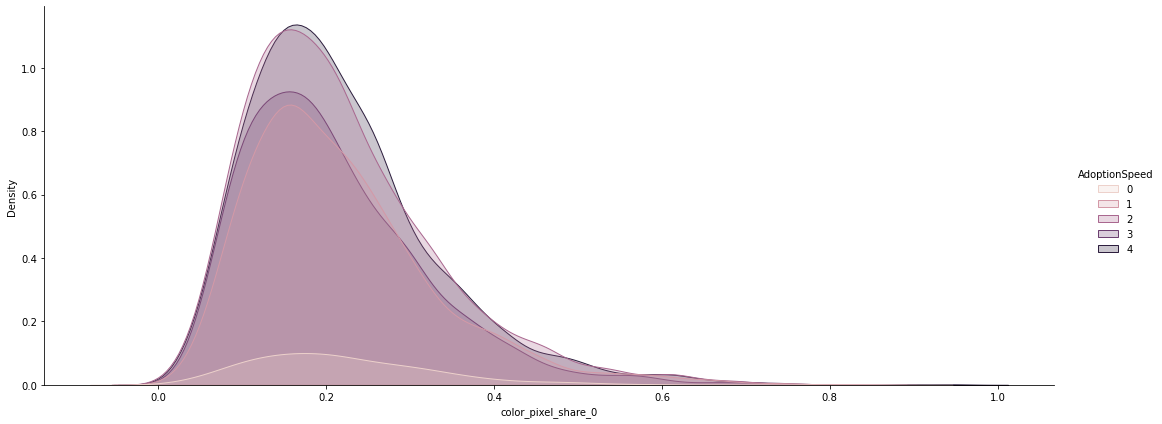

---------------------------------------------------------------
Column: red_1
Number of missing values: 273
Unique values: 253

count    11721.000000
mean       126.419333
std         61.421011
min          3.000000
25%         80.000000
50%        127.000000
75%        171.000000
max        254.000000
Name: red_1, dtype: float64

Percentiles: 0.01: 17.0, 0.10: 44.0, 0.90: 206.0, 0.99: 246.0

Top 20 values:
       count      freq
158.0    114  0.009726
163.0    113  0.009641
54.0     110  0.009385
126.0    109  0.009300
161.0    106  0.009044
89.0     105  0.008958
125.0    104  0.008873
122.0    104  0.008873
123.0    103  0.008788
124.0    103  0.008788
127.0    102  0.008702
121.0    101  0.008617
120.0    100  0.008532
25.0      98  0.008361
162.0     97  0.008276
52.0      97  0.008276
55.0      97  0.008276
129.0     96  0.008190
128.0     96  0.008190
164.0     94  0.008020

stat=0.977, p=0.000
Probably not Gaussian

stat=0.106, p=0.957
Probably the same distribution


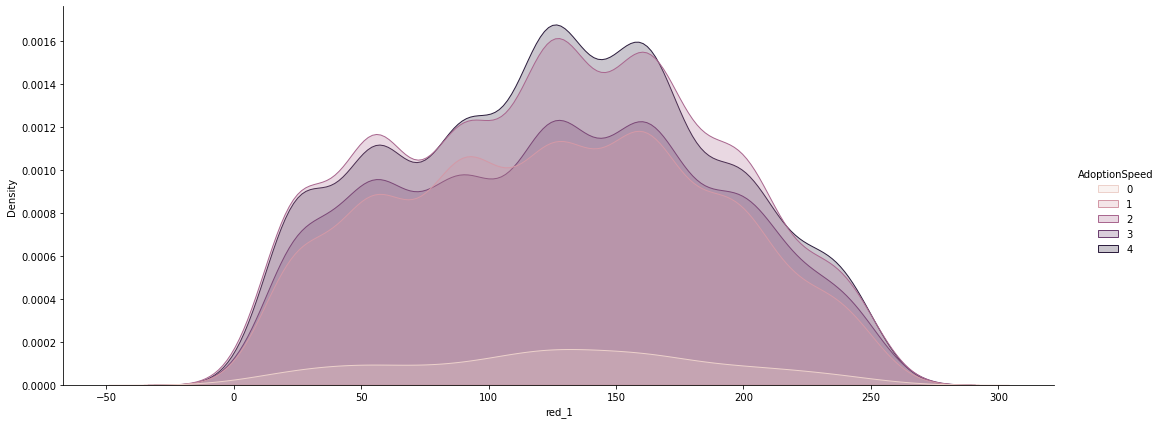

---------------------------------------------------------------
Column: green_1
Number of missing values: 273
Unique values: 250

count    11721.000000
mean       116.358502
std         61.009723
min          2.000000
25%         70.000000
50%        117.000000
75%        157.000000
max        253.000000
Name: green_1, dtype: float64

Percentiles: 0.01: 14.930000000000007, 0.10: 36.0, 0.90: 196.0, 0.99: 242.0

Top 20 values:
       count      freq
118.0    211  0.018002
116.0    202  0.017234
119.0    201  0.017149
117.0    195  0.016637
153.0    185  0.015784
120.0    185  0.015784
154.0    185  0.015784
49.0     182  0.015528
84.0     175  0.014930
83.0     174  0.014845
50.0     171  0.014589
115.0    170  0.014504
156.0    169  0.014419
157.0    168  0.014333
114.0    153  0.013053
152.0    153  0.013053
48.0     152  0.012968
85.0     149  0.012712
155.0    149  0.012712
81.0     147  0.012542

stat=0.970, p=0.000
Probably not Gaussian

stat=0.350, p=0.789
Probably the same distri

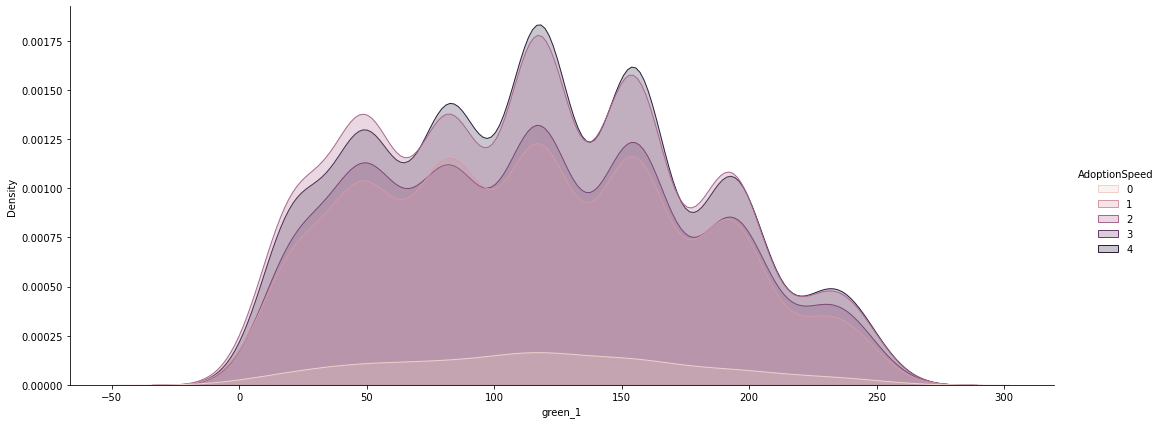

---------------------------------------------------------------
Column: blue_1
Number of missing values: 273
Unique values: 254

count    11721.000000
mean       105.868185
std         60.960556
min          1.000000
25%         53.000000
50%         99.000000
75%        151.000000
max        253.000000
Name: blue_1, dtype: float64

Percentiles: 0.01: 11.0, 0.10: 27.0, 0.90: 192.0, 0.99: 240.0

Top 20 values:
       count      freq
46.0     126  0.010750
150.0    111  0.009470
49.0     106  0.009044
114.0    106  0.009044
51.0     105  0.008958
117.0    104  0.008873
118.0    104  0.008873
45.0     101  0.008617
115.0    100  0.008532
55.0      97  0.008276
80.0      97  0.008276
24.0      96  0.008190
88.0      95  0.008105
47.0      95  0.008105
84.0      94  0.008020
116.0     94  0.008020
50.0      93  0.007934
151.0     90  0.007679
120.0     90  0.007679
113.0     90  0.007679

stat=0.966, p=0.000
Probably not Gaussian

stat=0.063, p=0.979
Probably the same distribution


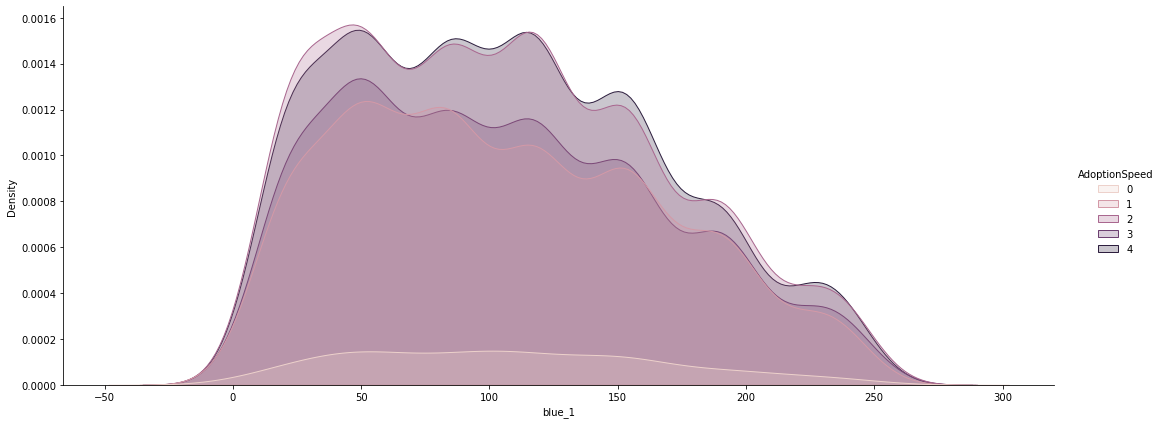

---------------------------------------------------------------
Column: color_pixel_share_1
Number of missing values: 273
Unique values: 9045

count    11721.000000
mean         0.129726
std          0.060801
min          0.005876
25%          0.084027
50%          0.121228
75%          0.165973
max          0.429807
Name: color_pixel_share_1, dtype: float64

Percentiles: 0.01: 0.02746383783, 0.10: 0.0598679308, 0.90: 0.21178794000000006, 0.99: 0.30324374379999997

Top 20 values:
          count      freq
0.098335      7  0.000597
0.160250      7  0.000597
0.158169      7  0.000597
0.110215      7  0.000597
0.057492      6  0.000512
0.158515      6  0.000512
0.110735      6  0.000512
0.080385      6  0.000512
0.137270      6  0.000512
0.120881      6  0.000512
0.081252      6  0.000512
0.084287      6  0.000512
0.160423      6  0.000512
0.155047      6  0.000512
0.123049      6  0.000512
0.085271      6  0.000512
0.122615      6  0.000512
0.118366      6  0.000512
0.117412      6  0.00

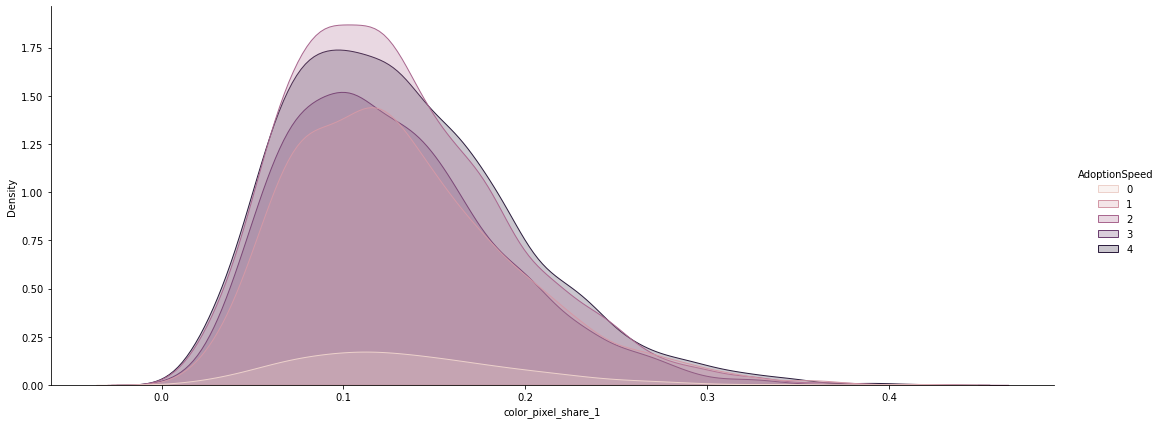

---------------------------------------------------------------
Column: red_2
Number of missing values: 273
Unique values: 254

count    11721.000000
mean       125.702414
std         58.783568
min          2.000000
25%         84.000000
50%        125.000000
75%        169.000000
max        255.000000
Name: red_2, dtype: float64

Percentiles: 0.01: 18.0, 0.10: 50.0, 0.90: 204.0, 0.99: 245.0

Top 20 values:
       count      freq
125.0    137  0.011688
91.0     115  0.009811
88.0     115  0.009811
122.0    114  0.009726
90.0     114  0.009726
124.0    110  0.009385
89.0     107  0.009129
87.0     107  0.009129
127.0    107  0.009129
54.0     103  0.008788
160.0    103  0.008788
53.0      99  0.008446
162.0     98  0.008361
85.0      98  0.008361
95.0      95  0.008105
128.0     94  0.008020
123.0     94  0.008020
56.0      93  0.007934
55.0      91  0.007764
121.0     90  0.007679

stat=0.983, p=0.000
Probably not Gaussian

stat=1.497, p=0.213
Probably the same distribution


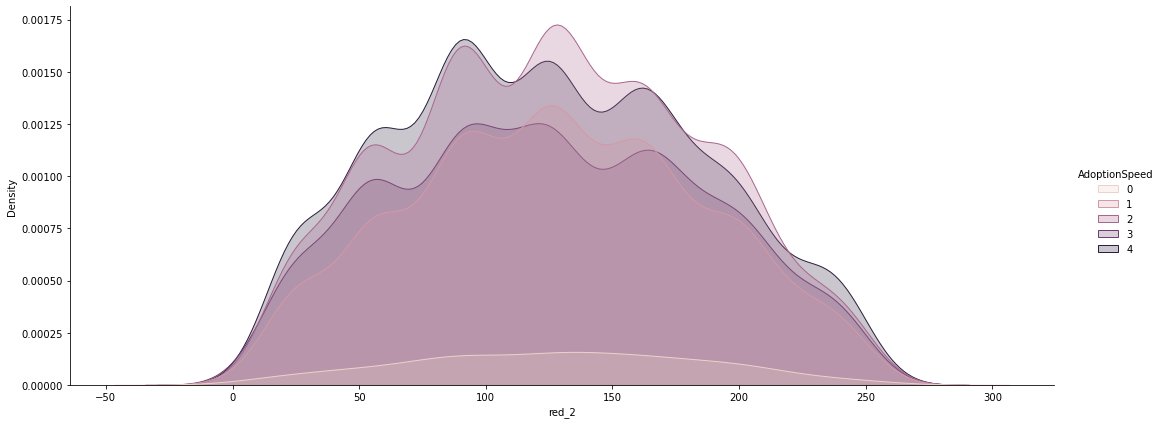

---------------------------------------------------------------
Column: green_2
Number of missing values: 273
Unique values: 252

count    11721.000000
mean       114.191537
std         58.146466
min          1.000000
25%         75.000000
50%        115.000000
75%        155.000000
max        254.000000
Name: green_2, dtype: float64

Percentiles: 0.01: 16.0, 0.10: 45.0, 0.90: 194.0, 0.99: 240.0

Top 20 values:
       count      freq
83.0     245  0.020903
82.0     241  0.020561
81.0     223  0.019026
117.0    221  0.018855
118.0    216  0.018428
119.0    207  0.017661
84.0     199  0.016978
116.0    198  0.016893
120.0    177  0.015101
155.0    172  0.014675
50.0     171  0.014589
153.0    168  0.014333
85.0     166  0.014163
80.0     166  0.014163
154.0    164  0.013992
49.0     164  0.013992
115.0    157  0.013395
48.0     151  0.012883
156.0    147  0.012542
79.0     147  0.012542

stat=0.971, p=0.000
Probably not Gaussian

stat=1.136, p=0.333
Probably the same distribution


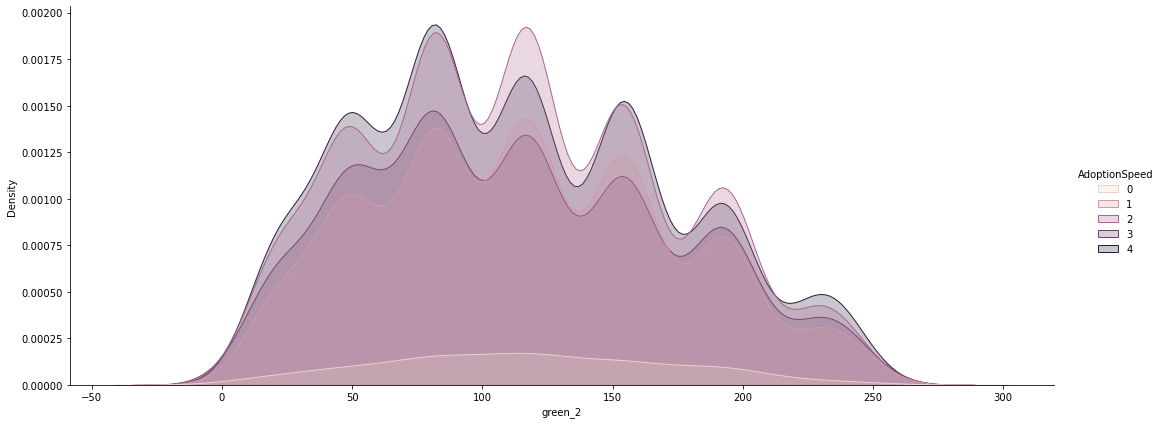

---------------------------------------------------------------
Column: blue_2
Number of missing values: 273
Unique values: 255

count    11721.000000
mean       102.892671
std         58.410226
min          1.000000
25%         55.000000
50%         92.000000
75%        147.000000
max        254.000000
Name: blue_2, dtype: float64

Percentiles: 0.01: 11.0, 0.10: 31.0, 0.90: 189.70000000000073, 0.99: 239.0

Top 20 values:
       count      freq
81.0     128  0.010921
79.0     127  0.010835
83.0     126  0.010750
86.0     116  0.009897
115.0    111  0.009470
52.0     110  0.009385
82.0     110  0.009385
50.0     107  0.009129
80.0     107  0.009129
84.0     106  0.009044
57.0     106  0.009044
78.0     105  0.008958
47.0     104  0.008873
117.0     99  0.008446
49.0      99  0.008446
58.0      99  0.008446
54.0      98  0.008361
48.0      96  0.008190
55.0      96  0.008190
112.0     95  0.008105

stat=0.963, p=0.000
Probably not Gaussian

stat=1.929, p=0.123
Probably the same distribut

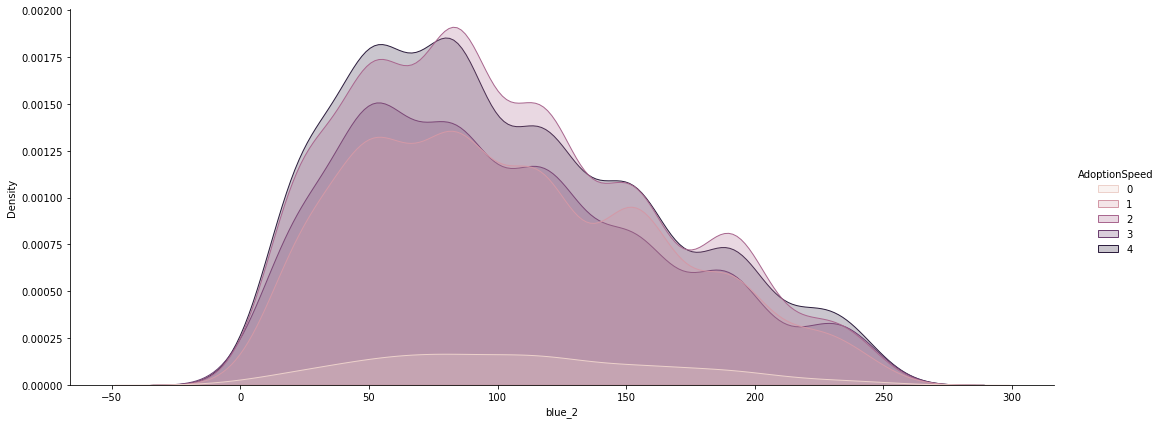

---------------------------------------------------------------
Column: color_pixel_share_2
Number of missing values: 273
Unique values: 8420

count    11721.000000
mean         0.090491
std          0.040962
min          0.003986
25%          0.059498
50%          0.086150
75%          0.116756
max          0.268475
Name: color_pixel_share_2, dtype: float64

Percentiles: 0.01: 0.01772113056, 0.10: 0.04131703, 0.90: 0.14602844, 0.99: 0.19927766039999997

Top 20 values:
          count      freq
0.071453     10  0.000853
0.079691      9  0.000768
0.104839      9  0.000768
0.066944      8  0.000683
0.077784      8  0.000683
0.089837      8  0.000683
0.075182      8  0.000683
0.093913      8  0.000683
0.092092      8  0.000683
0.088796      7  0.000597
0.069546      7  0.000597
0.083333      7  0.000597
0.097728      7  0.000597
0.104925      7  0.000597
0.117066      7  0.000597
0.073621      7  0.000597
0.140219      7  0.000597
0.097555      7  0.000597
0.067725      7  0.000597
0.0765

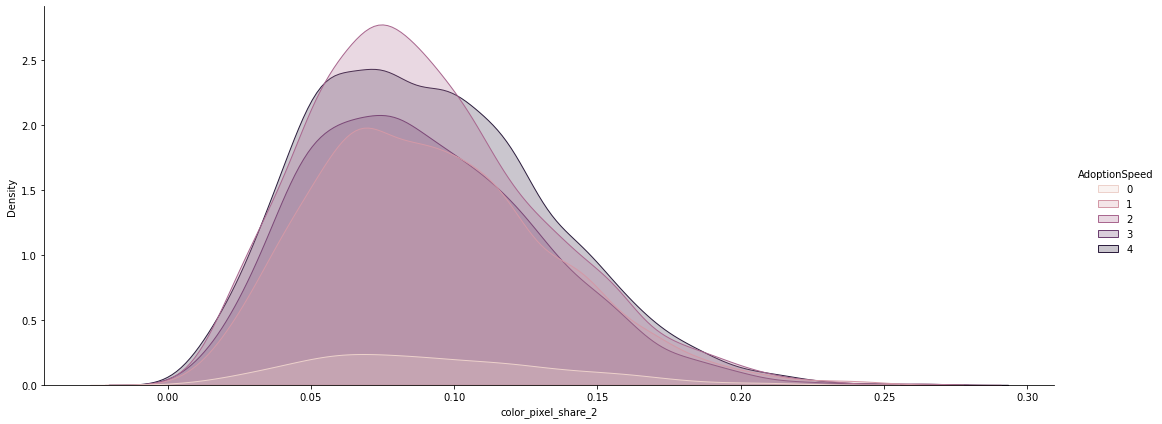

---------------------------------------------------------------
Column: red_3
Number of missing values: 273
Unique values: 253

count    11721.000000
mean       126.069192
std         58.035076
min          2.000000
25%         83.000000
50%        125.000000
75%        170.000000
max        254.000000
Name: red_3, dtype: float64

Percentiles: 0.01: 20.0, 0.10: 51.0, 0.90: 204.0, 0.99: 245.0

Top 20 values:
       count      freq
123.0    124  0.010579
124.0    113  0.009641
88.0     111  0.009470
126.0    106  0.009044
120.0    105  0.008958
157.0    101  0.008617
125.0     97  0.008276
91.0      94  0.008020
93.0      94  0.008020
134.0     92  0.007849
92.0      92  0.007849
121.0     92  0.007849
97.0      90  0.007679
127.0     90  0.007679
90.0      89  0.007593
55.0      89  0.007593
87.0      89  0.007593
57.0      89  0.007593
122.0     88  0.007508
58.0      87  0.007423

stat=0.983, p=0.000
Probably not Gaussian

stat=0.115, p=0.951
Probably the same distribution


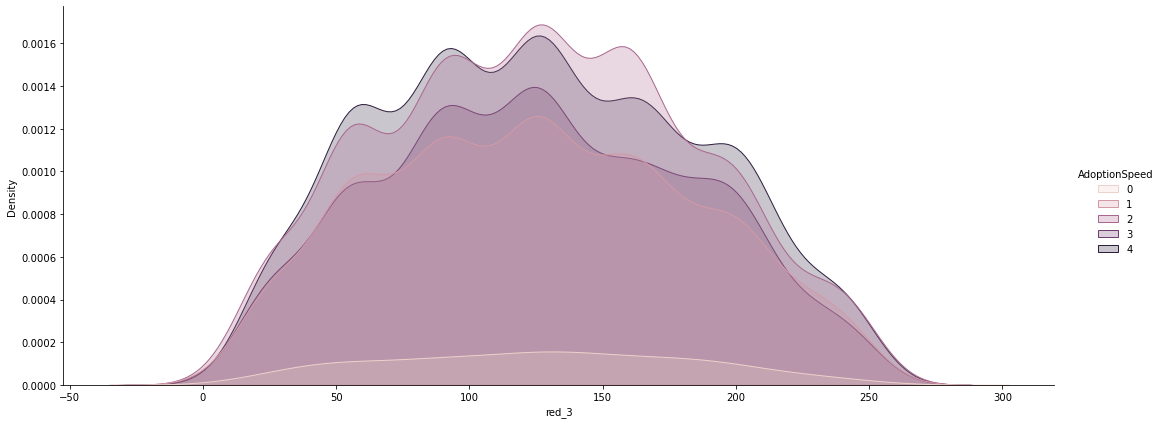

---------------------------------------------------------------
Column: green_3
Number of missing values: 273
Unique values: 254

count    11721.000000
mean       113.159969
std         57.097572
min          1.000000
25%         73.000000
50%        114.000000
75%        155.000000
max        253.000000
Name: green_3, dtype: float64

Percentiles: 0.01: 16.0, 0.10: 45.299999999999955, 0.90: 193.0, 0.99: 239.0

Top 20 values:
       count      freq
117.0    255  0.021756
84.0     222  0.018940
83.0     220  0.018770
119.0    217  0.018514
116.0    207  0.017661
81.0     204  0.017405
82.0     202  0.017234
118.0    190  0.016210
50.0     182  0.015528
115.0    180  0.015357
155.0    175  0.014930
51.0     171  0.014589
85.0     166  0.014163
156.0    158  0.013480
153.0    157  0.013395
120.0    156  0.013309
49.0     156  0.013309
48.0     151  0.012883
80.0     149  0.012712
47.0     145  0.012371

stat=0.970, p=0.000
Probably not Gaussian

stat=0.630, p=0.596
Probably the same distri

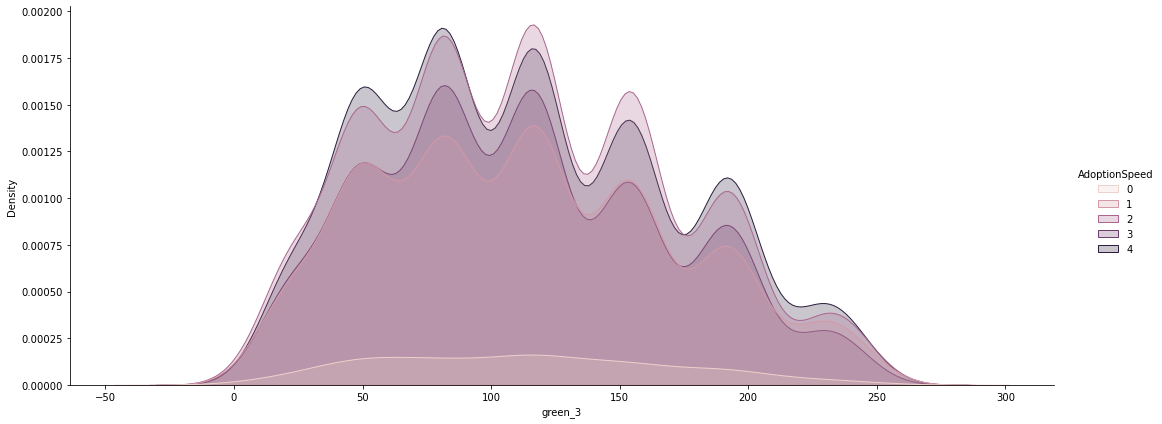

---------------------------------------------------------------
Column: blue_3
Number of missing values: 273
Unique values: 253

count    11721.000000
mean       101.042403
std         57.168652
min          1.000000
25%         55.000000
50%         91.000000
75%        141.000000
max        253.000000
Name: blue_3, dtype: float64

Percentiles: 0.01: 11.0, 0.10: 31.0, 0.90: 187.0, 0.99: 237.0

Top 20 values:
       count      freq
47.0     115  0.009811
78.0     114  0.009726
48.0     109  0.009300
51.0     108  0.009214
80.0     107  0.009129
59.0     107  0.009129
49.0     105  0.008958
86.0     104  0.008873
54.0     104  0.008873
112.0    103  0.008788
87.0     102  0.008702
79.0     102  0.008702
76.0      99  0.008446
85.0      99  0.008446
83.0      99  0.008446
82.0      98  0.008361
81.0      97  0.008276
62.0      93  0.007934
56.0      91  0.007764
84.0      91  0.007764

stat=0.962, p=0.000
Probably not Gaussian

stat=1.090, p=0.352
Probably the same distribution


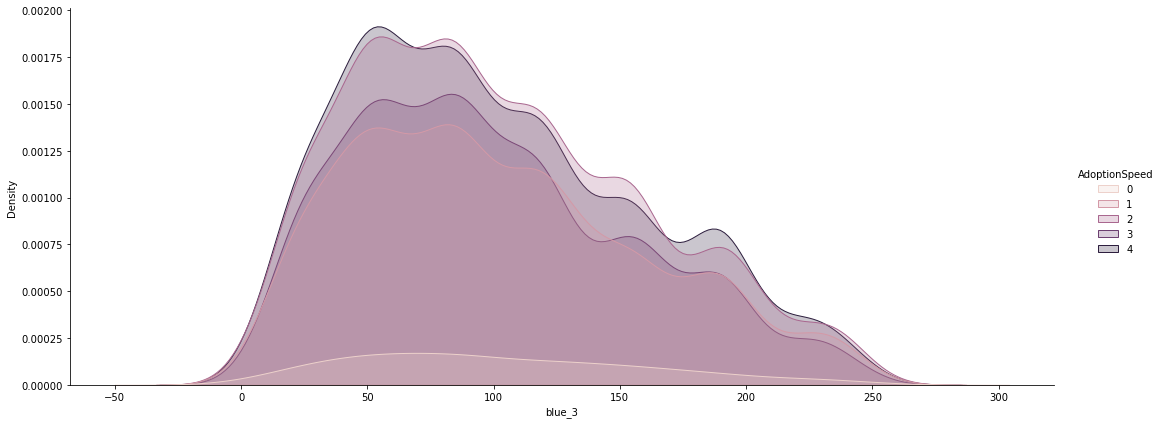

---------------------------------------------------------------
Column: color_pixel_share_3
Number of missing values: 273
Unique values: 7856

count    11721.000000
mean         0.067012
std          0.031369
min          0.000719
25%          0.043432
50%          0.063534
75%          0.087409
max          0.191523
Name: color_pixel_share_3, dtype: float64

Percentiles: 0.01: 0.01104943895, 0.10: 0.029105284699999998, 0.90: 0.10972401800000002, 0.99: 0.14804147

Top 20 values:
          count      freq
0.050728     13  0.001109
0.056452     11  0.000938
0.054891     10  0.000853
0.052636     10  0.000853
0.067464     10  0.000853
0.041537     10  0.000853
0.049428      9  0.000768
0.055064      9  0.000768
0.072060      9  0.000768
0.050468      9  0.000768
0.052810      9  0.000768
0.048127      9  0.000768
0.046393      9  0.000768
0.055931      9  0.000768
0.054370      8  0.000683
0.071540      8  0.000683
0.031564      8  0.000683
0.038935      8  0.000683
0.049149      8  0.000

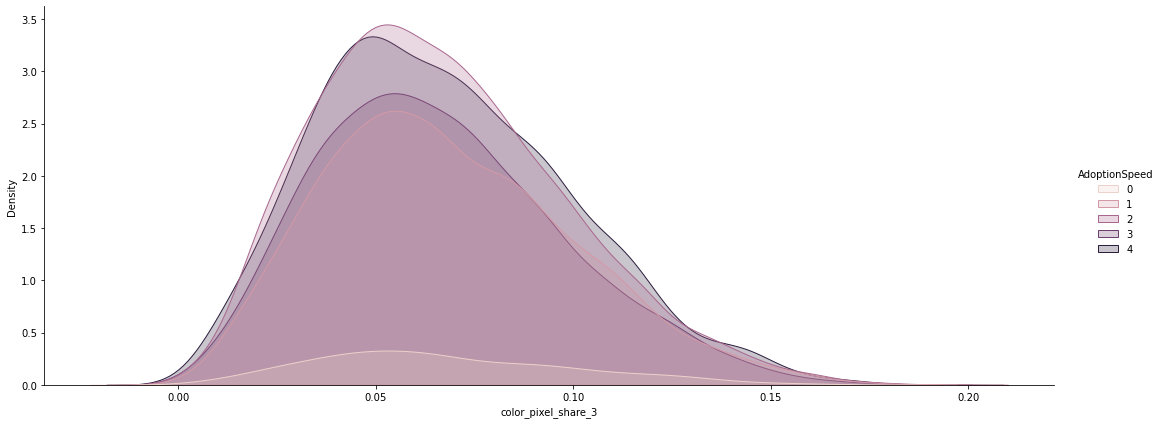

---------------------------------------------------------------
Column: red_4
Number of missing values: 275
Unique values: 252

count    11719.000000
mean       125.692124
std         58.071585
min          3.000000
25%         82.000000
50%        125.000000
75%        169.000000
max        254.000000
Name: red_4, dtype: float64

Percentiles: 0.01: 21.0, 0.10: 51.0, 0.90: 204.0, 0.99: 245.0

Top 20 values:
       count      freq
89.0      98  0.008362
56.0      96  0.008192
159.0     94  0.008021
84.0      94  0.008021
99.0      90  0.007680
58.0      89  0.007595
91.0      88  0.007509
94.0      88  0.007509
59.0      87  0.007424
157.0     86  0.007339
97.0      85  0.007253
98.0      85  0.007253
92.0      84  0.007168
164.0     84  0.007168
134.0     84  0.007168
122.0     84  0.007168
133.0     83  0.007083
124.0     83  0.007083
85.0      83  0.007083
86.0      82  0.006997

stat=0.983, p=0.000
Probably not Gaussian

stat=0.054, p=0.983
Probably the same distribution


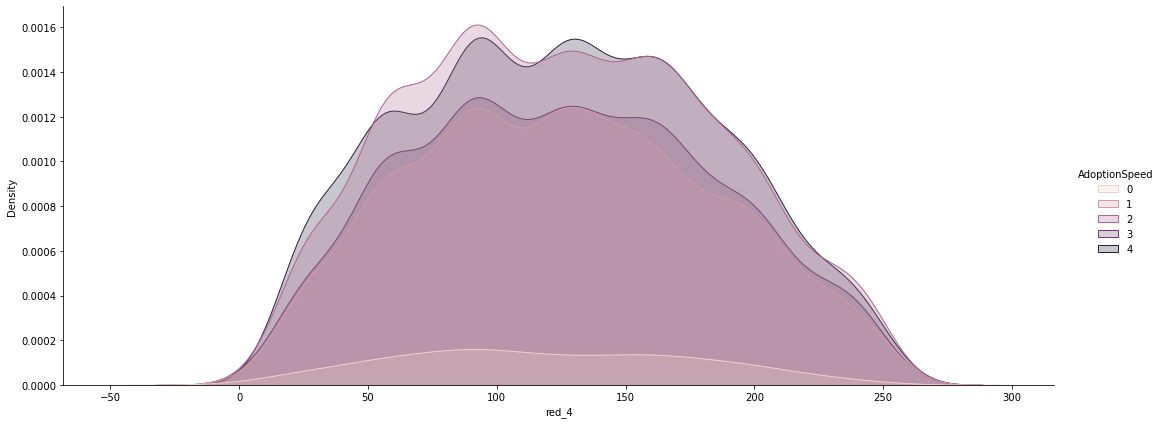

---------------------------------------------------------------
Column: green_4
Number of missing values: 275
Unique values: 252

count    11719.000000
mean       111.429985
std         56.929708
min          1.000000
25%         71.000000
50%        112.000000
75%        154.000000
max        251.000000
Name: green_4, dtype: float64

Percentiles: 0.01: 17.0, 0.10: 45.0, 0.90: 192.0, 0.99: 238.0

Top 20 values:
       count      freq
83.0     239  0.020394
82.0     219  0.018688
81.0     199  0.016981
117.0    191  0.016298
84.0     188  0.016042
119.0    185  0.015786
116.0    184  0.015701
80.0     184  0.015701
118.0    182  0.015530
51.0     180  0.015360
49.0     179  0.015274
48.0     173  0.014762
50.0     172  0.014677
154.0    165  0.014080
120.0    151  0.012885
155.0    150  0.012800
85.0     147  0.012544
52.0     146  0.012458
115.0    144  0.012288
47.0     143  0.012202

stat=0.970, p=0.000
Probably not Gaussian

stat=0.188, p=0.904
Probably the same distribution


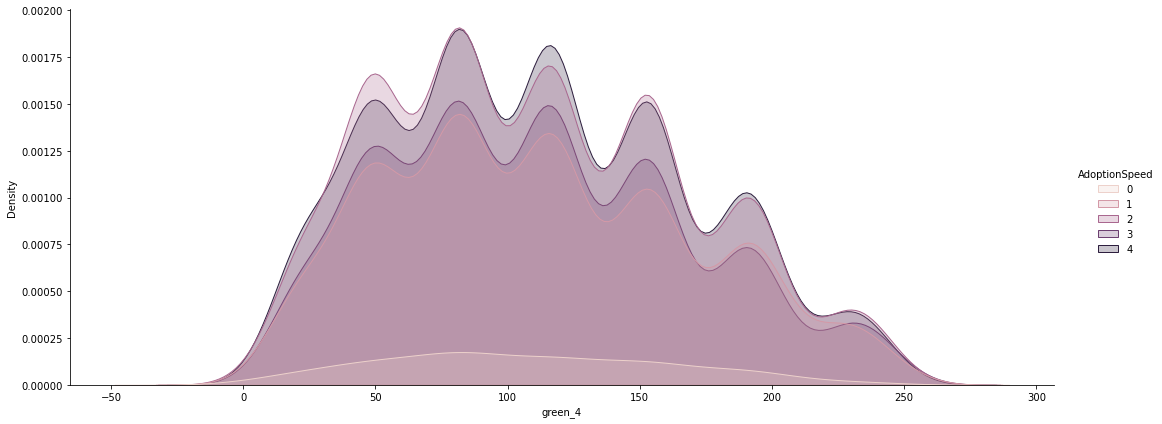

---------------------------------------------------------------
Column: blue_4
Number of missing values: 275
Unique values: 255

count    11719.000000
mean        98.782917
std         57.166271
min          1.000000
25%         53.000000
50%         89.000000
75%        138.000000
max        254.000000
Name: blue_4, dtype: float64

Percentiles: 0.01: 10.0, 0.10: 30.0, 0.90: 185.0, 0.99: 236.0

Top 20 values:
      count      freq
45.0    111  0.009472
79.0    110  0.009386
78.0    110  0.009386
80.0    107  0.009130
52.0    106  0.009045
77.0    103  0.008789
61.0    101  0.008618
60.0     98  0.008362
54.0     98  0.008362
94.0     98  0.008362
95.0     97  0.008277
64.0     94  0.008021
57.0     94  0.008021
62.0     94  0.008021
49.0     93  0.007936
44.0     93  0.007936
47.0     92  0.007850
46.0     92  0.007850
63.0     91  0.007765
96.0     91  0.007765

stat=0.959, p=0.000
Probably not Gaussian

stat=0.332, p=0.803
Probably the same distribution


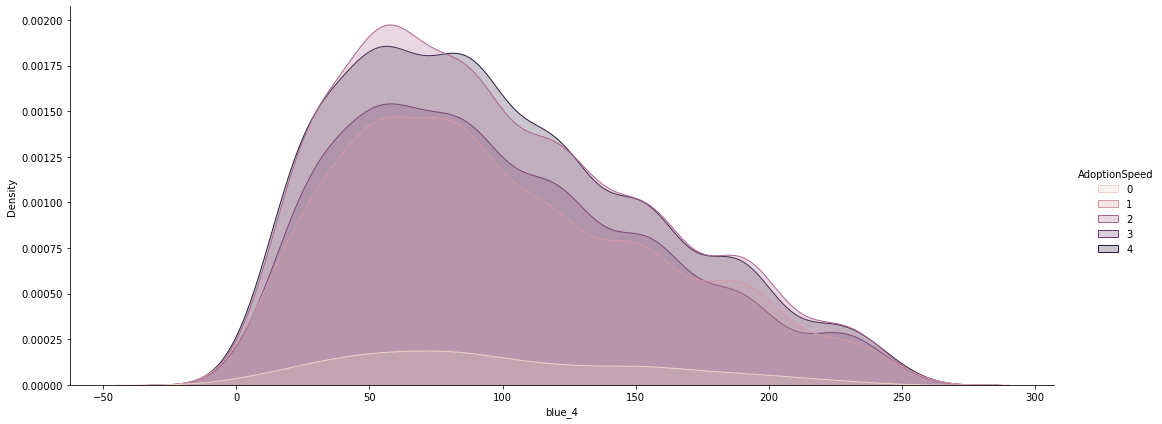

---------------------------------------------------------------
Column: color_pixel_share_4
Number of missing values: 275
Unique values: 7488

count    11719.000000
mean         0.050454
std          0.025475
min          0.000639
25%          0.031452
50%          0.046933
75%          0.066417
max          0.163458
Name: color_pixel_share_4, dtype: float64

Percentiles: 0.01: 0.006647959419000001, 0.10: 0.0200370577, 0.90: 0.08526224500000001, 0.99: 0.11904750294999997

Top 20 values:
          count      freq
0.034599     18  0.001536
0.028616     13  0.001109
0.037288     12  0.001024
0.047000     12  0.001024
0.032258     12  0.001024
0.042577     12  0.001024
0.060180     11  0.000939
0.039716     11  0.000939
0.034860     11  0.000939
0.051769     10  0.000853
0.023326     10  0.000853
0.045352     10  0.000853
0.042924     10  0.000853
0.046306     10  0.000853
0.031391     10  0.000853
0.036854     10  0.000853
0.054977     10  0.000853
0.018297      9  0.000768
0.053243      

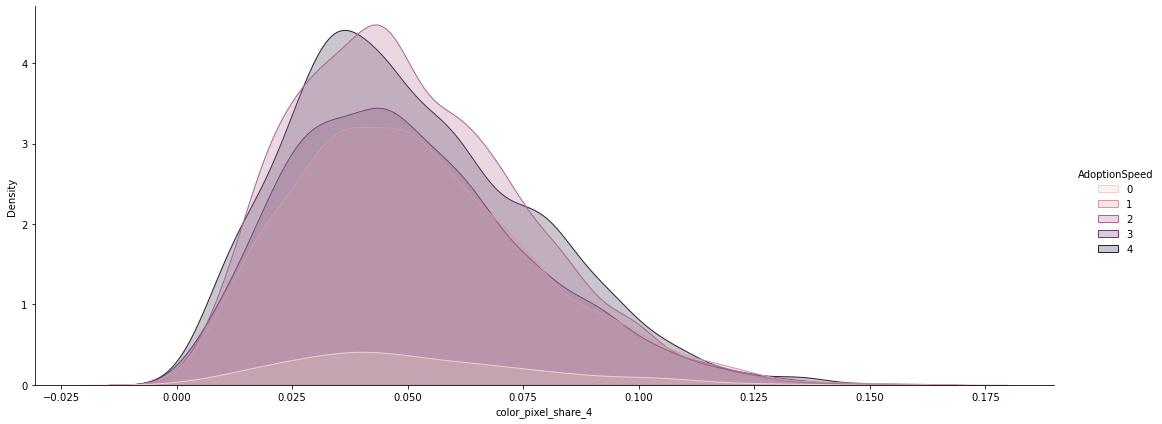

---------------------------------------------------------------
Column: red_5
Number of missing values: 279
Unique values: 254

count    11715.000000
mean       126.603756
std         59.032530
min          2.000000
25%         81.000000
50%        125.000000
75%        172.000000
max        254.000000
Name: red_5, dtype: float64

Percentiles: 0.01: 21.0, 0.10: 51.0, 0.90: 207.0, 0.99: 245.0

Top 20 values:
       count      freq
87.0      98  0.008365
92.0      91  0.007768
93.0      84  0.007170
132.0     83  0.007085
60.0      82  0.007000
127.0     80  0.006829
97.0      80  0.006829
90.0      80  0.006829
123.0     80  0.006829
55.0      79  0.006743
133.0     79  0.006743
94.0      79  0.006743
125.0     77  0.006573
88.0      77  0.006573
124.0     76  0.006487
100.0     76  0.006487
56.0      76  0.006487
96.0      75  0.006402
98.0      75  0.006402
86.0      75  0.006402

stat=0.981, p=0.000
Probably not Gaussian

stat=2.018, p=0.109
Probably the same distribution


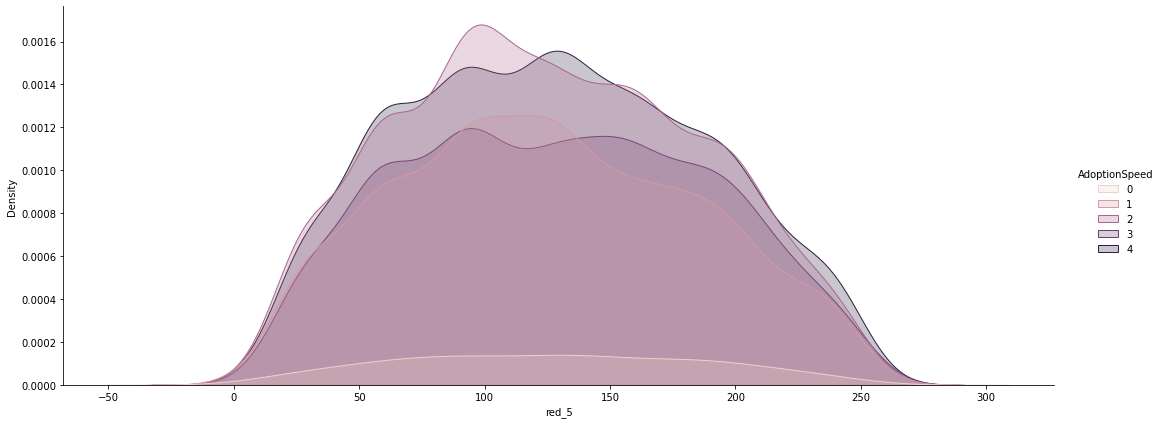

---------------------------------------------------------------
Column: green_5
Number of missing values: 278
Unique values: 250

count    11716.000000
mean       111.045323
std         57.941680
min          2.000000
25%         63.000000
50%        111.000000
75%        153.000000
max        251.000000
Name: green_5, dtype: float64

Percentiles: 0.01: 16.0, 0.10: 43.0, 0.90: 193.0, 0.99: 239.0

Top 20 values:
       count      freq
81.0     204  0.017412
117.0    201  0.017156
83.0     201  0.017156
82.0     197  0.016815
80.0     187  0.015961
48.0     173  0.014766
84.0     172  0.014681
116.0    172  0.014681
51.0     171  0.014595
50.0     167  0.014254
49.0     160  0.013657
118.0    158  0.013486
85.0     155  0.013230
119.0    151  0.012888
79.0     150  0.012803
115.0    148  0.012632
114.0    146  0.012462
120.0    143  0.012206
154.0    143  0.012206
113.0    137  0.011693

stat=0.968, p=0.000
Probably not Gaussian

stat=0.936, p=0.422
Probably the same distribution


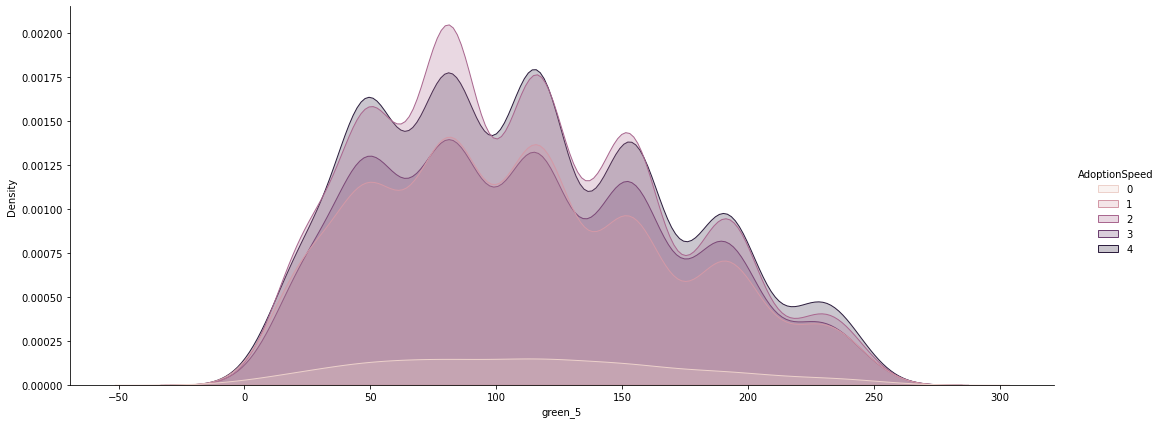

---------------------------------------------------------------
Column: blue_5
Number of missing values: 278
Unique values: 253

count    11716.000000
mean        98.066746
std         58.191788
min          1.000000
25%         52.000000
50%         89.000000
75%        136.000000
max        255.000000
Name: blue_5, dtype: float64

Percentiles: 0.01: 9.0, 0.10: 29.0, 0.90: 186.0, 0.99: 237.0699999999997

Top 20 values:
      count      freq
63.0    117  0.009986
64.0    111  0.009474
62.0    107  0.009133
60.0    101  0.008621
78.0     97  0.008279
59.0     97  0.008279
33.0     96  0.008194
66.0     96  0.008194
58.0     96  0.008194
32.0     96  0.008194
61.0     95  0.008109
28.0     94  0.008023
30.0     94  0.008023
97.0     93  0.007938
95.0     92  0.007853
57.0     90  0.007682
31.0     90  0.007682
93.0     90  0.007682
76.0     89  0.007596
96.0     89  0.007596

stat=0.955, p=0.000
Probably not Gaussian

stat=0.357, p=0.784
Probably the same distribution


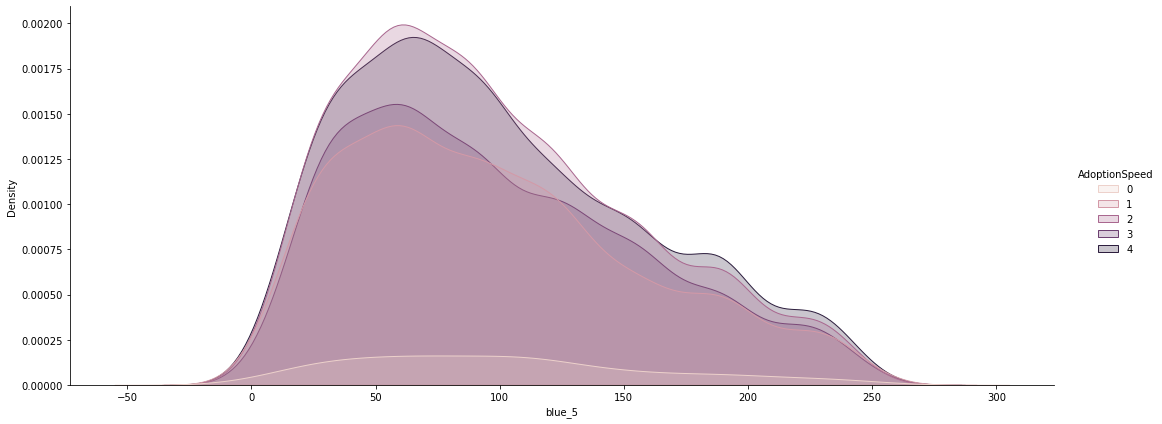

---------------------------------------------------------------
Column: color_pixel_share_5
Number of missing values: 278
Unique values: 6997

count    11716.000000
mean         0.037426
std          0.020565
min          0.000098
25%          0.021977
50%          0.034529
75%          0.050122
max          0.134897
Name: color_pixel_share_5, dtype: float64

Percentiles: 0.01: 0.0036139420069999997, 0.10: 0.01326743, 0.90: 0.0651005, 0.99: 0.0942531818

Top 20 values:
          count      freq
0.027055     18  0.001536
0.041276     13  0.001110
0.028876     13  0.001110
0.036334     12  0.001024
0.018210     12  0.001024
0.021852     12  0.001024
0.019945     11  0.000939
0.046479     11  0.000939
0.022633     11  0.000939
0.025928     11  0.000939
0.035206     11  0.000939
0.033212     11  0.000939
0.027922     11  0.000939
0.018817     11  0.000939
0.031304     11  0.000939
0.022373     10  0.000854
0.021592     10  0.000854
0.021419     10  0.000854
0.015088     10  0.000854
0.0346

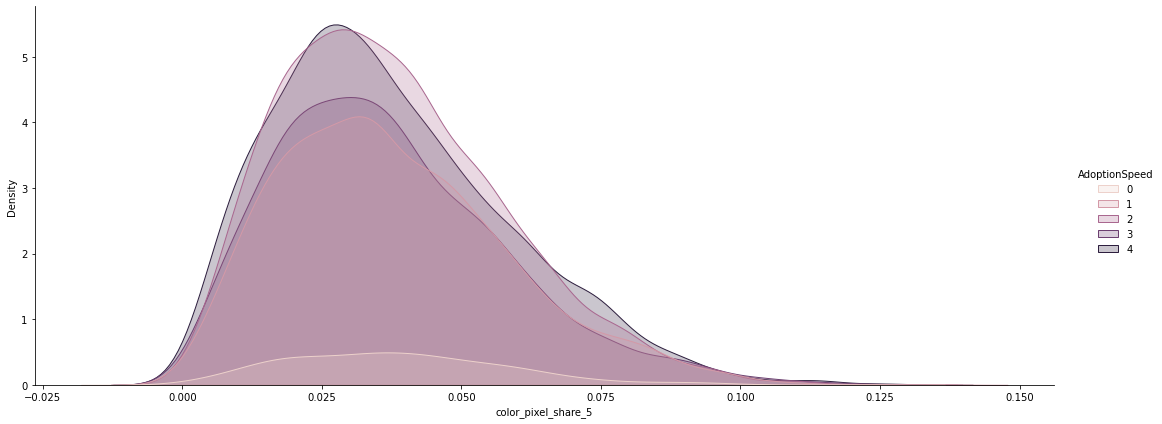

---------------------------------------------------------------
Column: red_6
Number of missing values: 290
Unique values: 255

count    11704.000000
mean       129.281699
std         59.169047
min          2.000000
25%         83.000000
50%        128.000000
75%        174.000000
max        255.000000
Name: red_6, dtype: float64

Percentiles: 0.01: 20.0, 0.10: 52.0, 0.90: 211.0, 0.99: 246.0

Top 20 values:
       count      freq
98.0      94  0.008031
99.0      87  0.007433
155.0     84  0.007177
90.0      84  0.007177
100.0     83  0.007092
97.0      81  0.006921
124.0     77  0.006579
153.0     77  0.006579
136.0     77  0.006579
96.0      77  0.006579
134.0     76  0.006494
137.0     76  0.006494
133.0     74  0.006323
69.0      74  0.006323
94.0      74  0.006323
129.0     73  0.006237
95.0      73  0.006237
102.0     72  0.006152
127.0     72  0.006152
149.0     71  0.006066

stat=0.983, p=0.000
Probably not Gaussian

stat=3.552, p=0.014
Probably different distributions


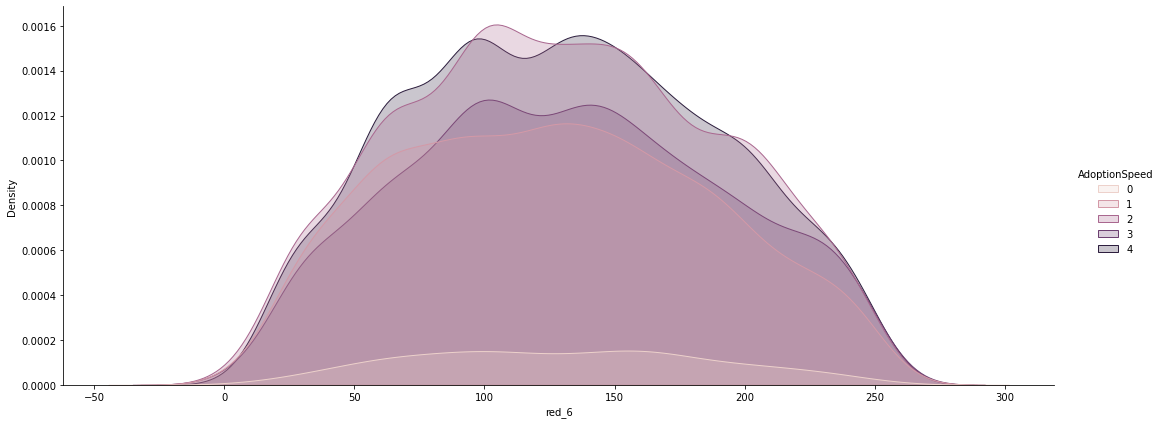

---------------------------------------------------------------
Column: green_6
Number of missing values: 290
Unique values: 252

count    11704.000000
mean       111.616883
std         57.786201
min          2.000000
25%         69.000000
50%        111.000000
75%        153.000000
max        252.000000
Name: green_6, dtype: float64

Percentiles: 0.01: 16.0, 0.10: 43.0, 0.90: 193.0, 0.99: 238.0

Top 20 values:
       count      freq
82.0     188  0.016063
81.0     188  0.016063
117.0    176  0.015038
115.0    161  0.013756
84.0     161  0.013756
83.0     160  0.013671
118.0    160  0.013671
80.0     152  0.012987
48.0     150  0.012816
119.0    150  0.012816
85.0     145  0.012389
49.0     145  0.012389
116.0    144  0.012303
52.0     144  0.012303
50.0     141  0.012047
79.0     141  0.012047
51.0     137  0.011705
154.0    136  0.011620
47.0     134  0.011449
113.0    133  0.011364

stat=0.969, p=0.000
Probably not Gaussian

stat=2.554, p=0.054
Probably the same distribution


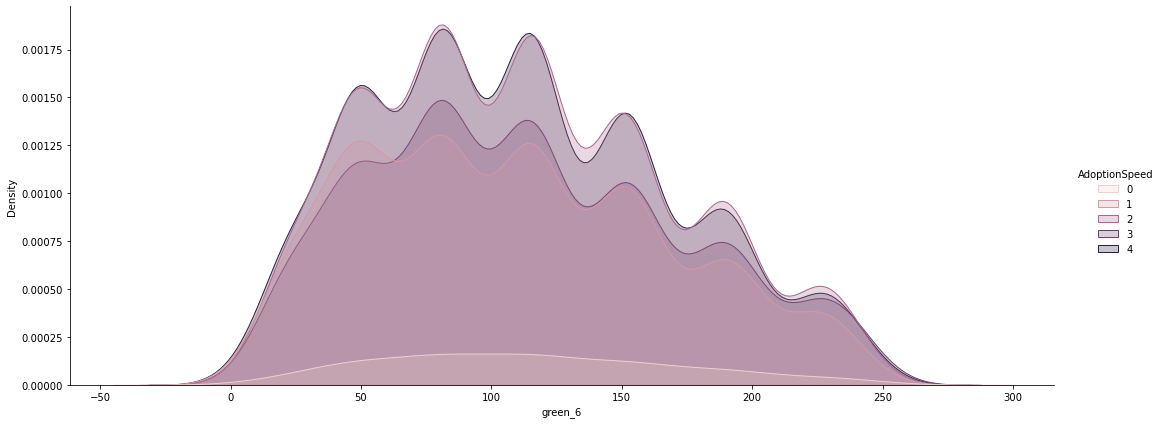

---------------------------------------------------------------
Column: blue_6
Number of missing values: 290
Unique values: 255

count    11704.000000
mean        97.752820
std         57.993164
min          1.000000
25%         52.750000
50%         89.000000
75%        135.000000
max        254.000000
Name: blue_6, dtype: float64

Percentiles: 0.01: 9.0, 0.10: 30.0, 0.90: 184.0, 0.99: 238.0

Top 20 values:
      count      freq
65.0    134  0.011449
62.0    115  0.009826
94.0    114  0.009740
66.0    110  0.009398
63.0    109  0.009313
97.0    106  0.009057
37.0    106  0.009057
61.0    105  0.008971
33.0    105  0.008971
64.0    104  0.008886
69.0    103  0.008800
60.0    102  0.008715
34.0    101  0.008630
68.0    100  0.008544
35.0     97  0.008288
98.0     94  0.008031
81.0     93  0.007946
36.0     92  0.007861
29.0     90  0.007690
96.0     89  0.007604

stat=0.955, p=0.000
Probably not Gaussian

stat=1.134, p=0.334
Probably the same distribution


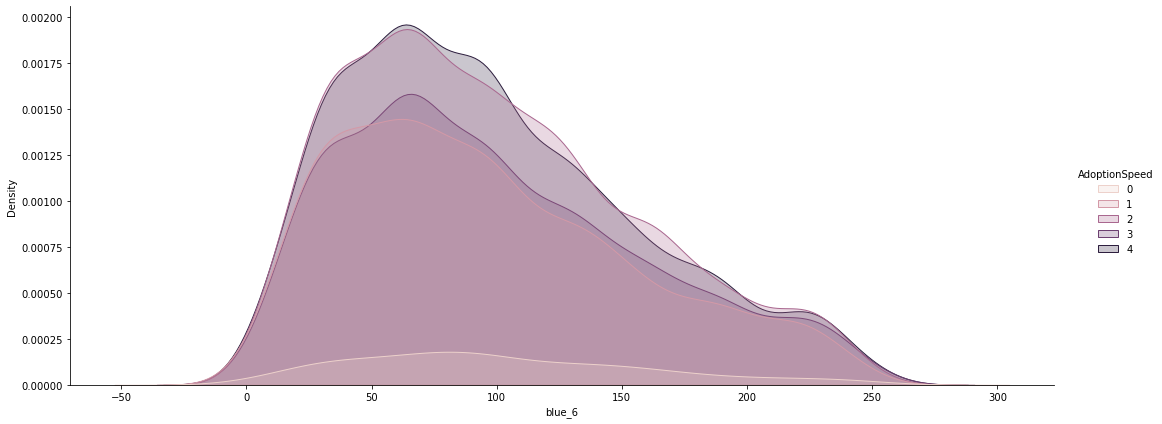

---------------------------------------------------------------
Column: color_pixel_share_6
Number of missing values: 290
Unique values: 6474

count    11704.000000
mean         0.026973
std          0.016468
min          0.000080
25%          0.014481
50%          0.024295
75%          0.036587
max          0.125367
Name: color_pixel_share_6, dtype: float64

Percentiles: 0.01: 0.001842306098, 0.10: 0.0079935912, 0.90: 0.049514394, 0.99: 0.07474852

Top 20 values:
          count      freq
0.018123     17  0.001452
0.021072     16  0.001367
0.018817     16  0.001367
0.026361     15  0.001282
0.011620     15  0.001282
0.026448     14  0.001196
0.016996     14  0.001196
0.028443     13  0.001111
0.013528     13  0.001111
0.011967     13  0.001111
0.011880     13  0.001111
0.022546     13  0.001111
0.028096     13  0.001111
0.028529     13  0.001111
0.008758     13  0.001111
0.024194     13  0.001111
0.022806     13  0.001111
0.020465     13  0.001111
0.015609     12  0.001025
0.022199   

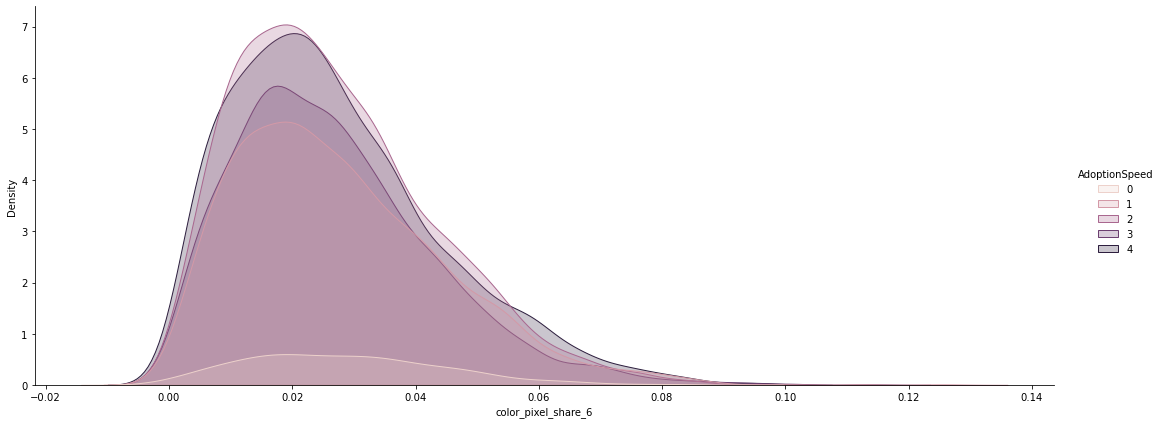

---------------------------------------------------------------
Column: red_7
Number of missing values: 321
Unique values: 255

count    11673.000000
mean       128.864988
std         58.894541
min          2.000000
25%         81.000000
50%        128.000000
75%        174.000000
max        255.000000
Name: red_7, dtype: float64

Percentiles: 0.01: 20.0, 0.10: 51.0, 0.90: 210.0, 0.99: 247.0

Top 20 values:
       count      freq
95.0      87  0.007453
137.0     86  0.007367
101.0     83  0.007110
94.0      82  0.007025
146.0     81  0.006939
147.0     79  0.006768
113.0     78  0.006682
99.0      77  0.006596
122.0     77  0.006596
154.0     76  0.006511
100.0     76  0.006511
132.0     76  0.006511
97.0      76  0.006511
65.0      75  0.006425
153.0     75  0.006425
134.0     74  0.006339
135.0     73  0.006254
75.0      73  0.006254
123.0     73  0.006254
96.0      73  0.006254

stat=0.982, p=0.000
Probably not Gaussian

stat=3.173, p=0.023
Probably different distributions


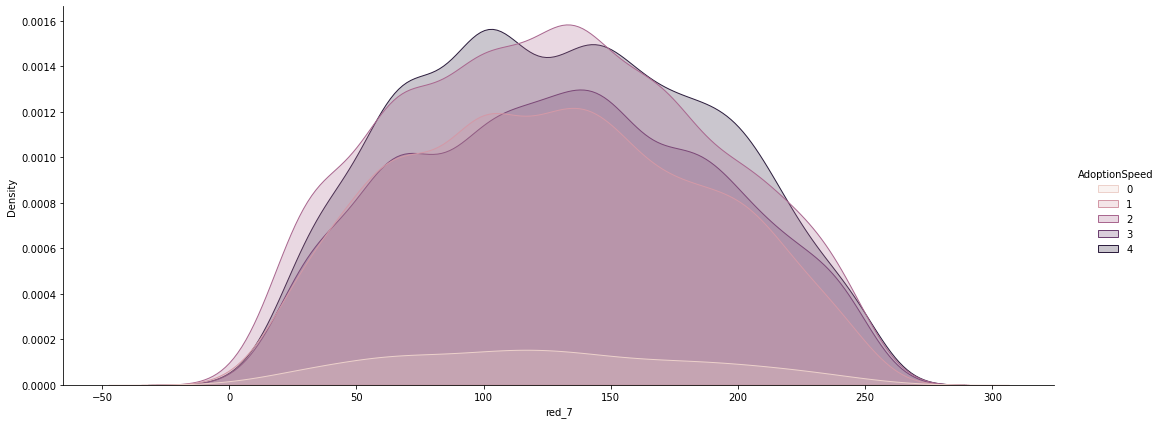

---------------------------------------------------------------
Column: green_7
Number of missing values: 320
Unique values: 251

count    11674.000000
mean       109.298698
std         56.904113
min          2.000000
25%         60.000000
50%        108.000000
75%        151.000000
max        251.000000
Name: green_7, dtype: float64

Percentiles: 0.01: 16.0, 0.10: 42.0, 0.90: 191.0, 0.99: 236.0

Top 20 values:
       count      freq
81.0     160  0.013706
118.0    155  0.013277
51.0     153  0.013106
115.0    153  0.013106
82.0     152  0.013020
79.0     151  0.012935
78.0     149  0.012763
50.0     147  0.012592
117.0    147  0.012592
83.0     144  0.012335
80.0     140  0.011992
48.0     137  0.011735
84.0     136  0.011650
52.0     133  0.011393
114.0    132  0.011307
49.0     126  0.010793
46.0     125  0.010708
116.0    123  0.010536
86.0     122  0.010451
113.0    121  0.010365

stat=0.970, p=0.000
Probably not Gaussian

stat=0.557, p=0.643
Probably the same distribution


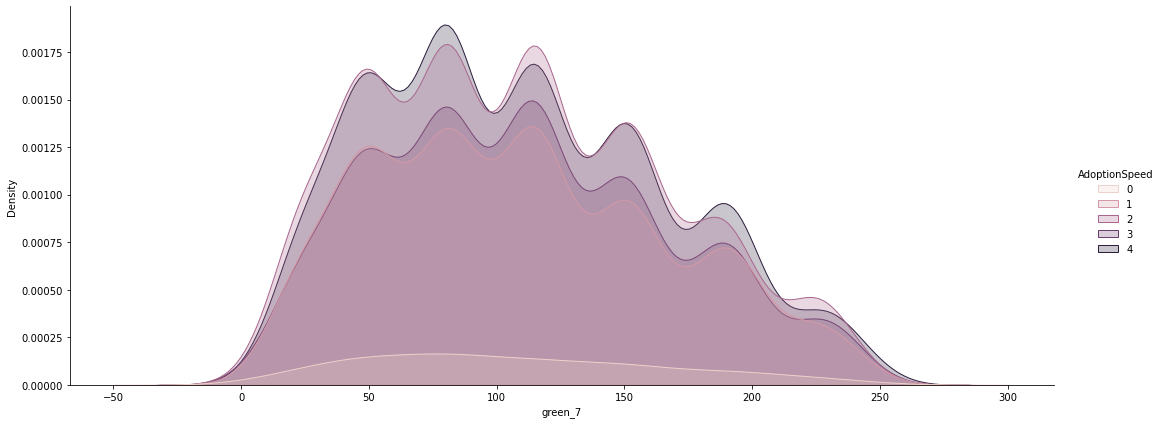

---------------------------------------------------------------
Column: blue_7
Number of missing values: 321
Unique values: 255

count    11673.000000
mean        95.008138
std         56.952810
min          1.000000
25%         49.000000
50%         88.000000
75%        132.000000
max        254.000000
Name: blue_7, dtype: float64

Percentiles: 0.01: 7.0, 0.10: 29.0, 0.90: 178.0, 0.99: 235.0

Top 20 values:
       count      freq
63.0     127  0.010880
64.0     127  0.010880
66.0     123  0.010537
65.0     118  0.010109
37.0     117  0.010023
34.0     110  0.009423
67.0     109  0.009338
31.0     108  0.009252
68.0     107  0.009166
35.0     104  0.008909
101.0    104  0.008909
38.0     104  0.008909
62.0     104  0.008909
33.0     103  0.008824
97.0     102  0.008738
69.0     102  0.008738
96.0     101  0.008652
60.0     100  0.008567
98.0     100  0.008567
36.0      98  0.008395

stat=0.958, p=0.000
Probably not Gaussian

stat=0.037, p=0.991
Probably the same distribution


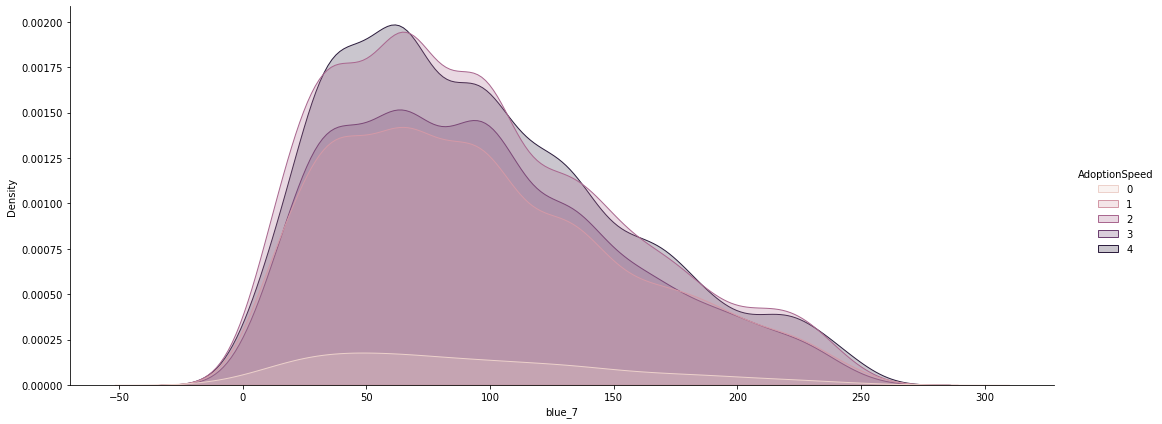

---------------------------------------------------------------
Column: color_pixel_share_7
Number of missing values: 320
Unique values: 5939

count    11674.000000
mean         0.018850
std          0.012893
min          0.000087
25%          0.009000
50%          0.016373
75%          0.026101
max          0.089837
Name: color_pixel_share_7, dtype: float64

Percentiles: 0.01: 0.0008874510932000001, 0.10: 0.00438348465, 0.90: 0.03650711, 0.99: 0.05677269347999997

Top 20 values:
          count      freq
0.008065     20  0.001713
0.011360     20  0.001713
0.003989     20  0.001713
0.010666     19  0.001628
0.009712     19  0.001628
0.005723     19  0.001628
0.009105     18  0.001542
0.016649     18  0.001542
0.010926     18  0.001542
0.013528     17  0.001456
0.018297     17  0.001456
0.017950     17  0.001456
0.023847     16  0.001371
0.016736     16  0.001371
0.014742     16  0.001371
0.012140     16  0.001371
0.013267     16  0.001371
0.007197     16  0.001371
0.009452     16  0.00

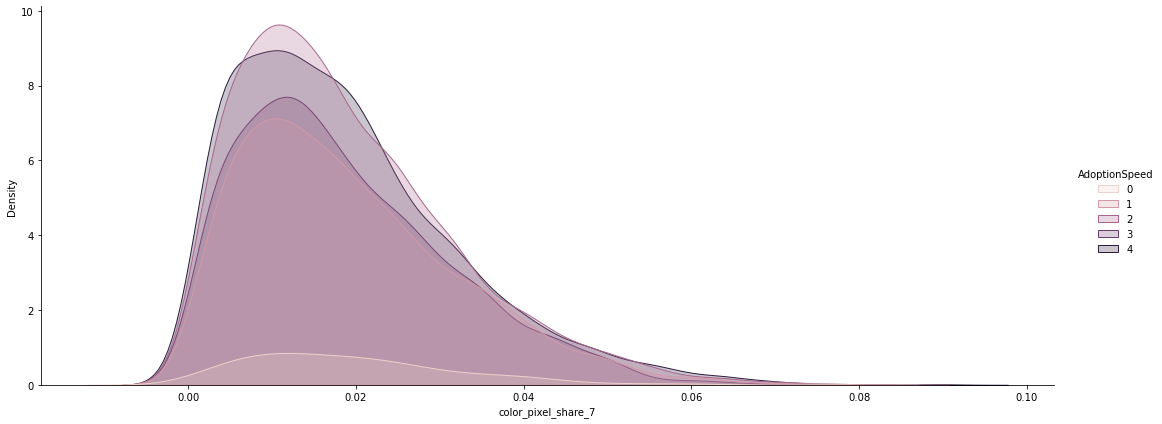

---------------------------------------------------------------
Column: red_8
Number of missing values: 337
Unique values: 255

count    11657.000000
mean       130.478339
std         61.244277
min          2.000000
25%         78.000000
50%        131.000000
75%        180.000000
max        255.000000
Name: red_8, dtype: float64

Percentiles: 0.01: 19.0, 0.10: 47.0, 0.90: 213.0, 0.99: 248.0

Top 20 values:
       count      freq
66.0      83  0.007120
110.0     82  0.007034
150.0     80  0.006863
143.0     79  0.006777
77.0      76  0.006520
72.0      75  0.006434
101.0     75  0.006434
68.0      75  0.006434
145.0     73  0.006262
149.0     72  0.006177
103.0     72  0.006177
40.0      71  0.006091
109.0     71  0.006091
140.0     70  0.006005
142.0     70  0.006005
64.0      70  0.006005
148.0     69  0.005919
100.0     69  0.005919
163.0     69  0.005919
111.0     69  0.005919

stat=0.978, p=0.000
Probably not Gaussian

stat=2.837, p=0.037
Probably different distributions


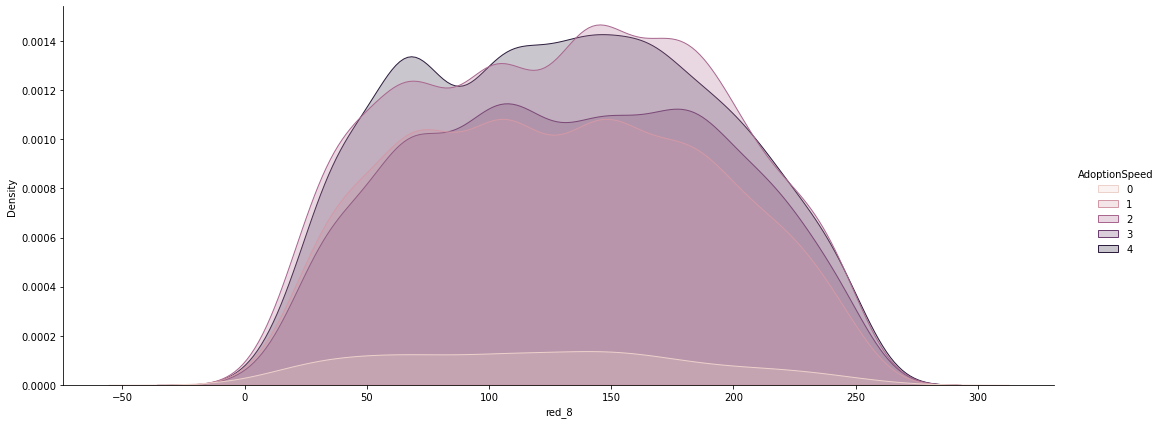

---------------------------------------------------------------
Column: green_8
Number of missing values: 337
Unique values: 250

count    11657.000000
mean       109.090589
std         58.778294
min          2.000000
25%         55.000000
50%        107.000000
75%        152.000000
max        251.000000
Name: green_8, dtype: float64

Percentiles: 0.01: 16.0, 0.10: 35.299999999999955, 0.90: 191.0, 0.99: 235.0699999999997

Top 20 values:
       count      freq
50.0     154  0.013211
51.0     148  0.012696
117.0    142  0.012182
53.0     129  0.011066
52.0     127  0.010895
82.0     124  0.010637
83.0     123  0.010552
46.0     122  0.010466
80.0     121  0.010380
81.0     121  0.010380
48.0     121  0.010380
78.0     118  0.010123
49.0     118  0.010123
79.0     114  0.009780
114.0    112  0.009608
84.0     112  0.009608
118.0    111  0.009522
28.0     110  0.009436
76.0     109  0.009351
47.0     107  0.009179

stat=0.967, p=0.000
Probably not Gaussian

stat=0.440, p=0.725
Probably the

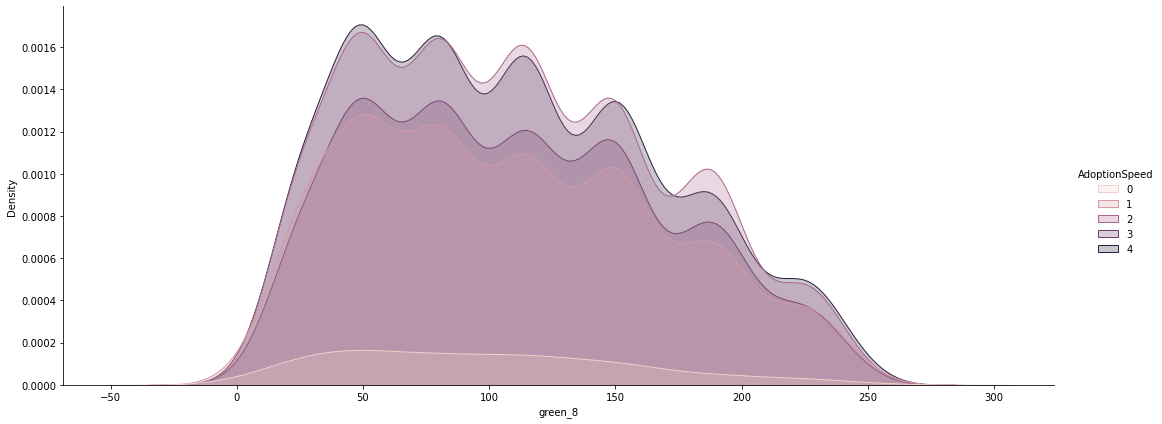

---------------------------------------------------------------
Column: blue_8
Number of missing values: 342
Unique values: 255

count    11652.000000
mean        94.427909
std         58.286755
min          1.000000
25%         45.000000
50%         85.000000
75%        133.000000
max        255.000000
Name: blue_8, dtype: float64

Percentiles: 0.01: 8.0, 0.10: 27.0, 0.90: 179.0, 0.99: 235.0699999999997

Top 20 values:
       count      freq
37.0     136  0.011672
35.0     117  0.010041
32.0     116  0.009955
33.0     116  0.009955
65.0     116  0.009955
38.0     110  0.009440
34.0     109  0.009355
40.0     108  0.009269
64.0     107  0.009183
66.0     104  0.008926
70.0     102  0.008754
36.0     102  0.008754
67.0     102  0.008754
39.0      96  0.008239
68.0      95  0.008153
42.0      95  0.008153
69.0      95  0.008153
41.0      93  0.007981
98.0      93  0.007981
101.0     89  0.007638

stat=0.955, p=0.000
Probably not Gaussian

stat=0.312, p=0.817
Probably the same distributio

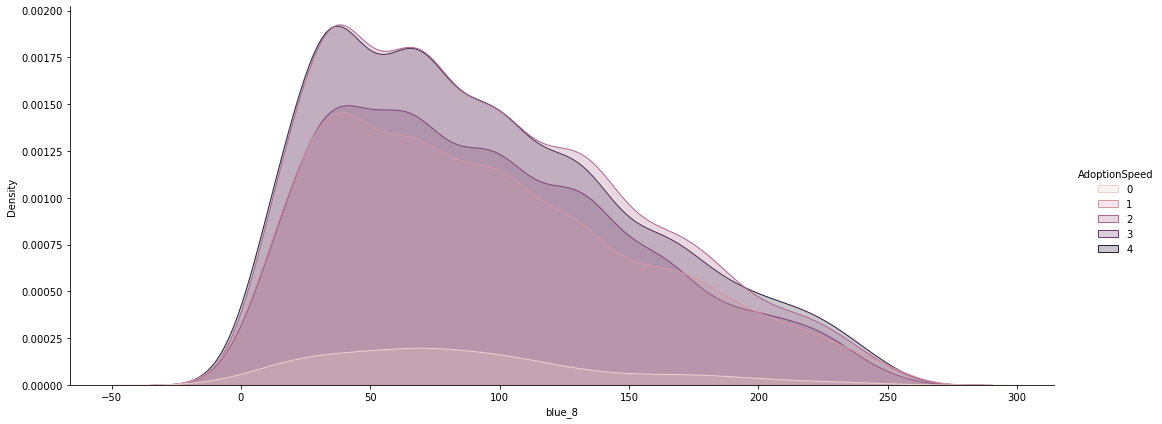

---------------------------------------------------------------
Column: color_pixel_share_8
Number of missing values: 335
Unique values: 5350

count    11659.000000
mean         0.012609
std          0.010025
min          0.000053
25%          0.004955
50%          0.010187
75%          0.017630
max          0.066966
Name: color_pixel_share_8, dtype: float64

Percentiles: 0.01: 0.0004252002, 0.10: 0.002254596, 0.90: 0.026129866100000006, 0.99: 0.045481188109999994

Top 20 values:
          count      freq
0.005550     30  0.002573
0.005723     29  0.002487
0.001041     26  0.002230
0.008065     26  0.002230
0.004943     26  0.002230
0.006677     25  0.002144
0.005376     25  0.002144
0.002862     25  0.002144
0.007197     24  0.002058
0.004422     24  0.002058
0.001301     23  0.001973
0.003989     23  0.001973
0.001821     23  0.001973
0.003382     23  0.001973
0.003122     22  0.001887
0.006504     22  0.001887
0.003555     21  0.001801
0.007458     21  0.001801
0.008238     21  0.00

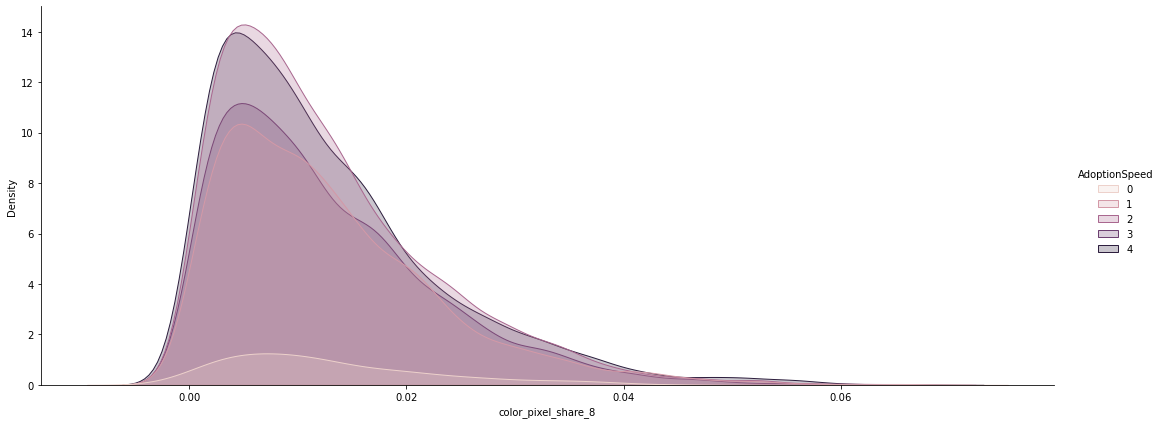

---------------------------------------------------------------
Column: red_9
Number of missing values: 381
Unique values: 256

count    11613.000000
mean       132.396969
std         64.369774
min          1.000000
25%         76.000000
50%        136.000000
75%        186.000000
max        255.000000
Name: red_9, dtype: float64

Percentiles: 0.01: 16.0, 0.10: 43.0, 0.90: 219.0, 0.99: 250.0

Top 20 values:
       count      freq
40.0      87  0.007492
39.0      80  0.006889
142.0     77  0.006631
41.0      77  0.006631
64.0      76  0.006544
72.0      74  0.006372
38.0      74  0.006372
197.0     73  0.006286
76.0      73  0.006286
174.0     72  0.006200
65.0      72  0.006200
143.0     72  0.006200
179.0     71  0.006114
144.0     70  0.006028
165.0     70  0.006028
151.0     69  0.005942
71.0      68  0.005856
74.0      68  0.005856
188.0     68  0.005856
44.0      68  0.005856

stat=0.970, p=0.000
Probably not Gaussian

stat=1.802, p=0.144
Probably the same distribution


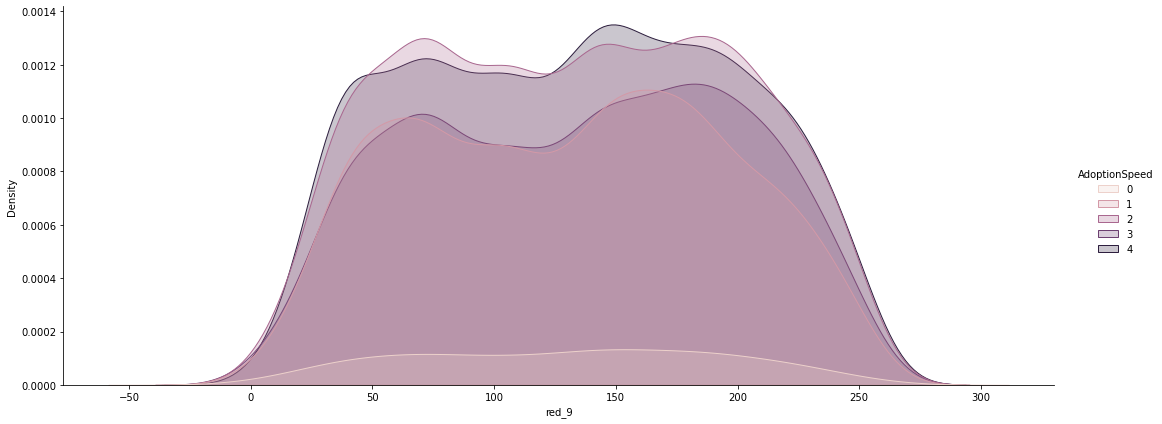

---------------------------------------------------------------
Column: green_9
Number of missing values: 364
Unique values: 255

count    11630.000000
mean       108.923044
std         61.781975
min          1.000000
25%         53.000000
50%        105.000000
75%        154.000000
max        255.000000
Name: green_9, dtype: float64

Percentiles: 0.01: 14.0, 0.10: 30.0, 0.90: 194.0, 0.99: 237.0

Top 20 values:
       count      freq
50.0     143  0.012296
52.0     130  0.011178
51.0     127  0.010920
47.0     118  0.010146
49.0     115  0.009888
48.0     111  0.009544
30.0     108  0.009286
53.0     107  0.009200
28.0     105  0.009028
54.0     104  0.008942
83.0      98  0.008426
82.0      96  0.008255
80.0      95  0.008169
76.0      94  0.008083
79.0      94  0.008083
29.0      94  0.008083
110.0     93  0.007997
81.0      92  0.007911
78.0      91  0.007825
77.0      91  0.007825

stat=0.962, p=0.000
Probably not Gaussian

stat=1.417, p=0.236
Probably the same distribution


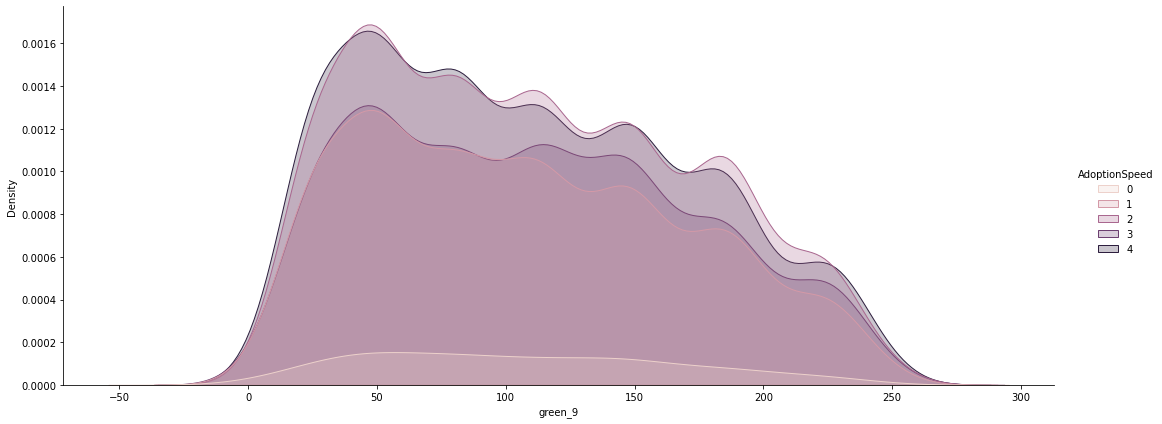

---------------------------------------------------------------
Column: blue_9
Number of missing values: 382
Unique values: 256

count    11612.000000
mean        94.885980
std         61.237156
min          1.000000
25%         41.000000
50%         85.000000
75%        137.000000
max        255.000000
Name: blue_9, dtype: float64

Percentiles: 0.01: 6.0, 0.10: 21.0, 0.90: 184.0, 0.99: 238.0699999999997

Top 20 values:
      count      freq
37.0    135  0.011626
36.0    130  0.011195
35.0    122  0.010506
38.0    119  0.010248
39.0    118  0.010162
40.0    110  0.009473
67.0    105  0.009042
33.0    104  0.008956
42.0    104  0.008956
17.0     98  0.008440
16.0     97  0.008353
41.0     96  0.008267
34.0     96  0.008267
97.0     95  0.008181
71.0     95  0.008181
15.0     95  0.008181
43.0     94  0.008095
68.0     92  0.007923
18.0     91  0.007837
70.0     90  0.007751

stat=0.952, p=0.000
Probably not Gaussian

stat=1.993, p=0.113
Probably the same distribution


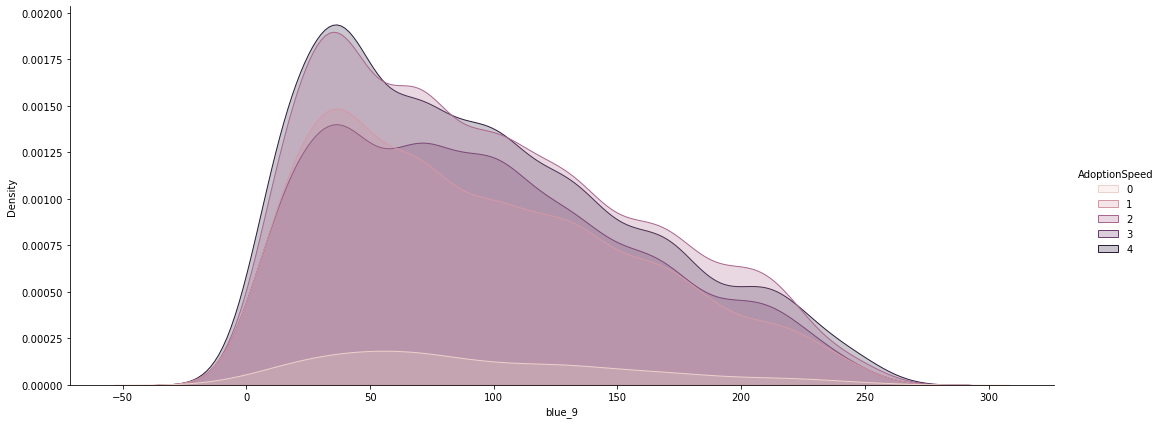

---------------------------------------------------------------
Column: color_pixel_share_9
Number of missing values: 362
Unique values: 4493

count    11632.000000
mean         0.006966
std          0.006866
min          0.000053
25%          0.001967
50%          0.004856
75%          0.009807
max          0.051681
Name: color_pixel_share_9, dtype: float64

Percentiles: 0.01: 9.834776e-05, 0.10: 0.0007192519999999999, 0.90: 0.015983377, 0.99: 0.03145298983

Top 20 values:
          count      freq
0.000520     62  0.005330
0.000173     59  0.005072
0.001474     56  0.004814
0.000607     55  0.004728
0.001301     51  0.004384
0.000434     50  0.004298
0.000087     47  0.004041
0.003208     46  0.003955
0.003122     46  0.003955
0.001041     45  0.003869
0.001127     45  0.003869
0.000780     44  0.003783
0.000260     42  0.003611
0.000347     42  0.003611
0.002255     41  0.003525
0.000867     40  0.003439
0.001648     40  0.003439
0.000694     39  0.003353
0.002862     38  0.003267
0

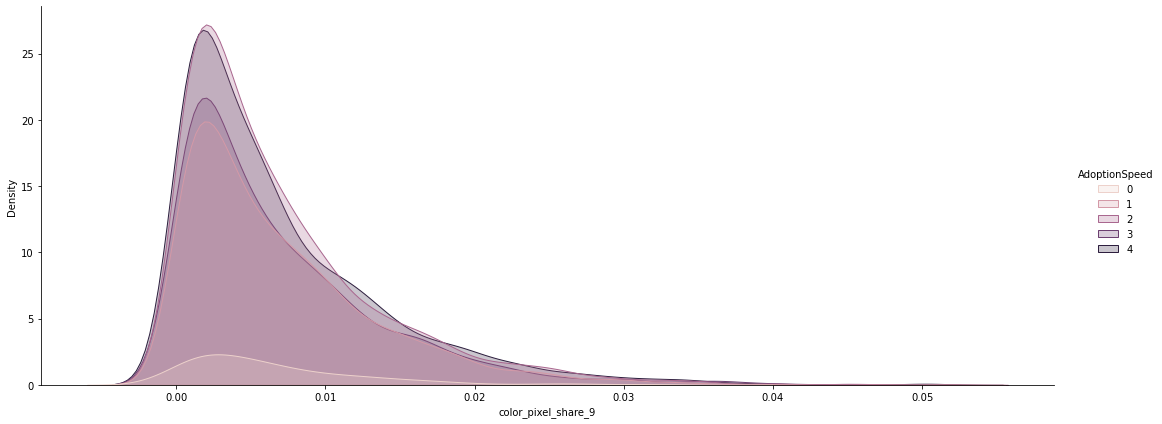

---------------------------------------------------------------
Column: main_picture_x_start
Number of missing values: 273
Unique values: 57

count    11721.000000
mean         0.679208
std          6.741749
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        197.000000
Name: main_picture_x_start, dtype: float64

Percentiles: 0.01: 0.0, 0.10: 0.0, 0.90: 0.0, 0.99: 23.0

Top 20 values:
      count      freq
0.0   11523  0.983107
11.0     17  0.001450
31.0     12  0.001024
15.0     11  0.000938
23.0     10  0.000853
35.0     10  0.000853
63.0     10  0.000853
7.0       8  0.000683
19.0      6  0.000512
43.0      6  0.000512
75.0      6  0.000512
79.0      6  0.000512
2.0       5  0.000427
3.0       5  0.000427
47.0      5  0.000427
27.0      4  0.000341
5.0       4  0.000341
55.0      4  0.000341
69.0      4  0.000341
82.0      4  0.000341

stat=0.076, p=0.000
Probably not Gaussian

stat=0.736, p=0.530
Probably the same distribution


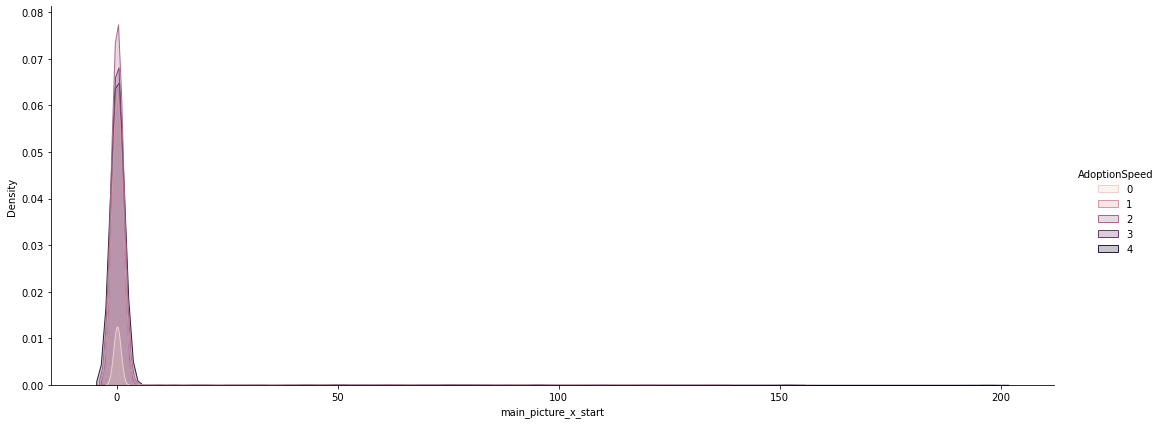

---------------------------------------------------------------
Column: main_picture_y_start
Number of missing values: 273
Unique values: 14

count    11721.000000
mean         0.037539
std          1.375787
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         82.000000
Name: main_picture_y_start, dtype: float64

Percentiles: 0.01: 0.0, 0.10: 0.0, 0.90: 0.0, 0.99: 0.0

All values:
      count      freq
0.0   11707  0.998806
19.0      2  0.000171
8.0       2  0.000171
15.0      1  0.000085
18.0      1  0.000085
62.0      1  0.000085
9.0       1  0.000085
47.0      1  0.000085
63.0      1  0.000085
51.0      1  0.000085
82.0      1  0.000085
2.0       1  0.000085
37.0      1  0.000085

stat=0.009, p=0.000
Probably not Gaussian

stat=0.027, p=0.994
Probably the same distribution


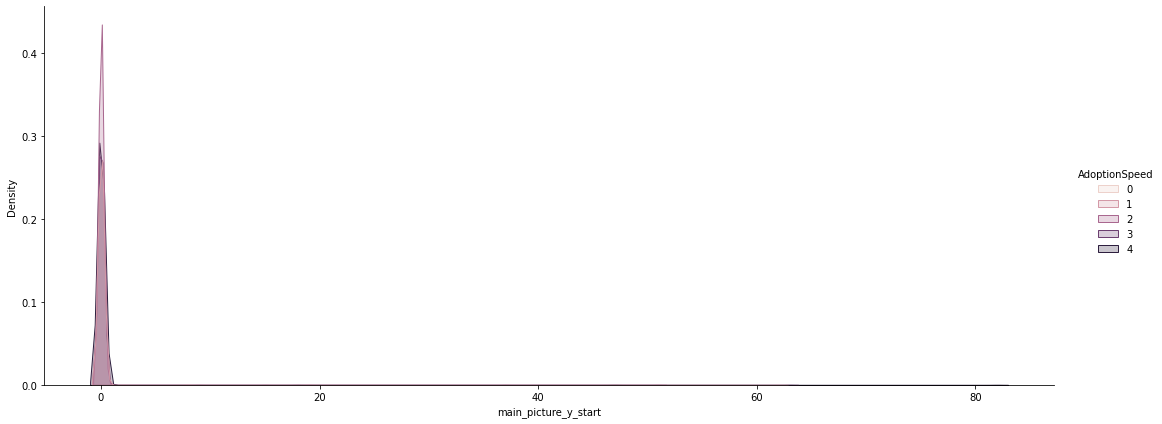

---------------------------------------------------------------
Column: main_picture_x_end
Number of missing values: 273
Unique values: 366

count    11721.000000
mean       392.209709
std        124.522539
min         77.000000
25%        299.000000
50%        390.000000
75%        399.000000
max        639.000000
Name: main_picture_x_end, dtype: float64

Percentiles: 0.01: 190.93, 0.10: 269.0, 0.90: 639.0, 0.99: 639.0

Top 20 values:
       count      freq
399.0   3459  0.295111
639.0   1814  0.154765
359.0   1537  0.131132
299.0   1222  0.104257
269.0    596  0.050849
224.0    240  0.020476
202.0    234  0.019964
298.0    170  0.014504
266.0    103  0.008788
398.0     94  0.008020
319.0     86  0.007337
265.0     78  0.006655
479.0     75  0.006399
638.0     65  0.005546
355.0     57  0.004863
383.0     51  0.004351
239.0     43  0.003669
358.0     38  0.003242
126.0     37  0.003157
287.0     34  0.002901

stat=0.849, p=0.000
Probably not Gaussian

stat=6.182, p=0.000
Probably diff

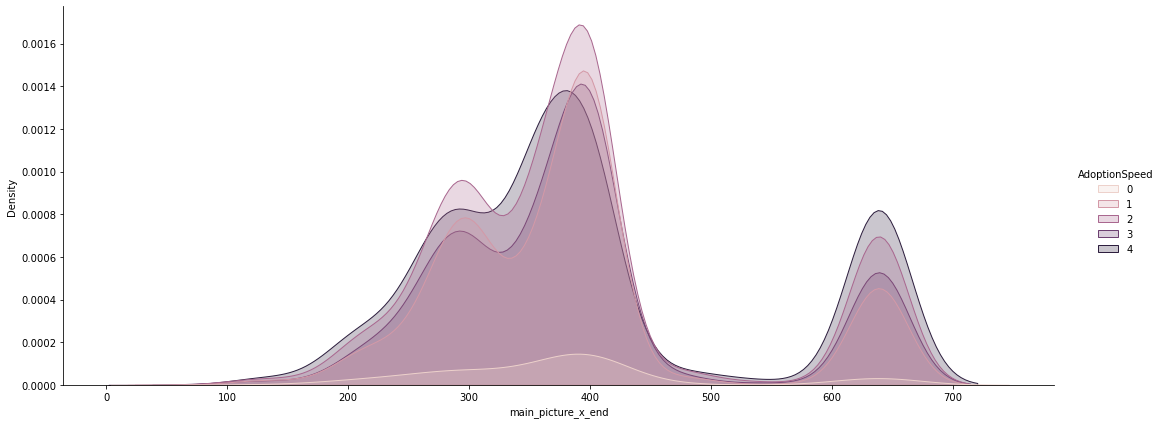

---------------------------------------------------------------
Column: main_picture_y_end
Number of missing values: 273
Unique values: 399

count    11721.000000
mean       395.835680
std         95.691111
min         66.000000
25%        299.000000
50%        399.000000
75%        479.000000
max        639.000000
Name: main_picture_y_end, dtype: float64

Percentiles: 0.01: 205.0, 0.10: 298.0, 0.90: 479.0, 0.99: 639.0

Top 20 values:
       count      freq
479.0   3579  0.305349
399.0   2443  0.208429
299.0   2287  0.195120
359.0    623  0.053152
639.0    378  0.032250
224.0    225  0.019196
266.0    182  0.015528
298.0    155  0.013224
265.0    131  0.011177
478.0    103  0.008788
398.0     78  0.006655
426.0     69  0.005887
477.0     64  0.005460
239.0     53  0.004522
267.0     52  0.004436
383.0     42  0.003583
264.0     34  0.002901
300.0     32  0.002730
319.0     30  0.002560
425.0     26  0.002218

stat=0.923, p=0.000
Probably not Gaussian

stat=48.308, p=0.000
Probably diff

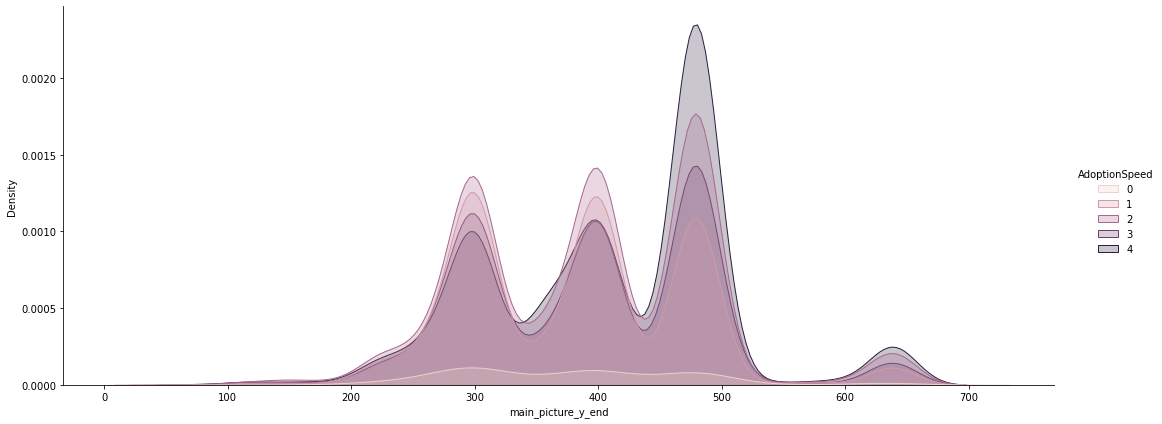

---------------------------------------------------------------
Column: width
Number of missing values: 273
Unique values: 344

count    11721.000000
mean       394.257572
std        125.125094
min         78.000000
25%        300.000000
50%        399.000000
75%        400.000000
max        640.000000
Name: width, dtype: float64

Percentiles: 0.01: 191.93, 0.10: 270.0, 0.90: 640.0, 0.99: 640.0

Top 20 values:
       count      freq
400.0   3591  0.306373
640.0   1885  0.160822
360.0   1537  0.131132
300.0   1224  0.104428
270.0    596  0.050849
225.0    240  0.020476
203.0    234  0.019964
299.0    172  0.014675
267.0    103  0.008788
399.0     97  0.008276
320.0     81  0.006911
266.0     78  0.006655
480.0     77  0.006569
639.0     67  0.005716
356.0     54  0.004607
240.0     43  0.003669
359.0     38  0.003242
384.0     38  0.003242
127.0     37  0.003157
288.0     34  0.002901

stat=0.846, p=0.000
Probably not Gaussian

stat=7.023, p=0.000
Probably different distributions


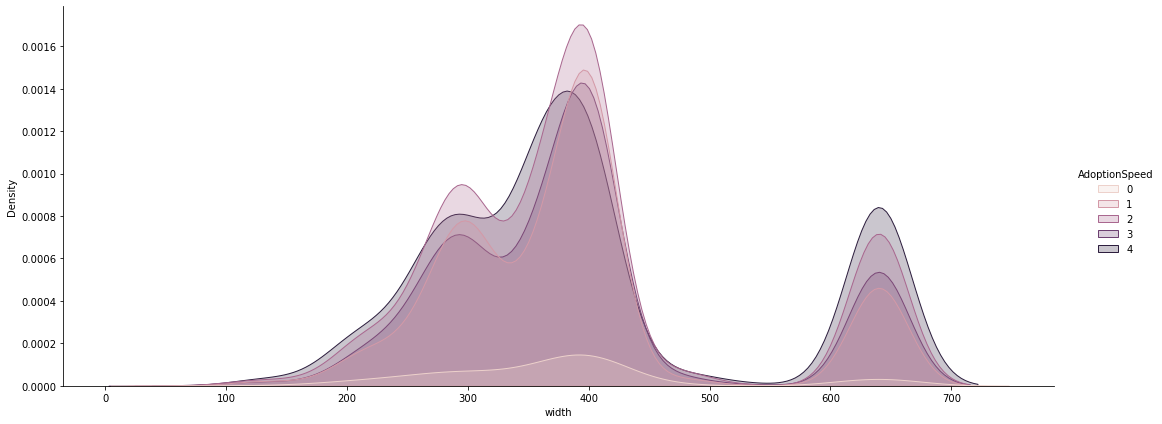

---------------------------------------------------------------
Column: height
Number of missing values: 273
Unique values: 392

count    11721.000000
mean       397.277877
std         95.829691
min         67.000000
25%        300.000000
50%        400.000000
75%        480.000000
max        640.000000
Name: height, dtype: float64

Percentiles: 0.01: 206.0, 0.10: 299.0, 0.90: 480.0, 0.99: 640.0

Top 20 values:
       count      freq
480.0   3634  0.310042
400.0   2460  0.209880
300.0   2294  0.195717
360.0    627  0.053494
640.0    382  0.032591
225.0    225  0.019196
267.0    183  0.015613
299.0    155  0.013224
266.0    131  0.011177
479.0    104  0.008873
399.0     78  0.006655
427.0     68  0.005802
478.0     65  0.005546
240.0     53  0.004522
268.0     52  0.004436
384.0     38  0.003242
265.0     34  0.002901
301.0     32  0.002730
320.0     31  0.002645
426.0     26  0.002218

stat=0.922, p=0.000
Probably not Gaussian

stat=48.921, p=0.000
Probably different distributions


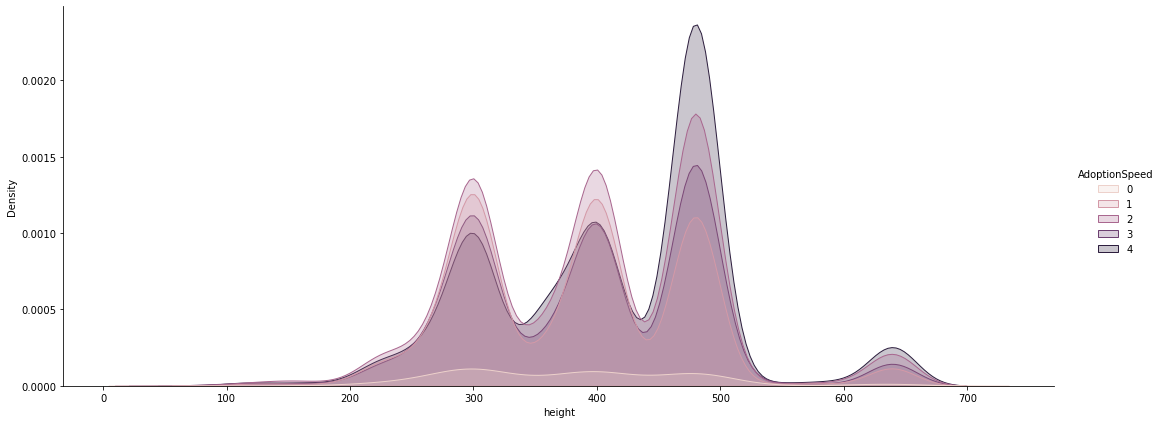

---------------------------------------------------------------


In [33]:
# we will loop through colums and inestigate the key information
for column in numeric_columns:
    number_of_unique_categories = len(X_train[column].unique())
    print(f'Column: {column}')
    # missing values
    all_values=X_train[column]
    nan_values = X_train[column].isna().sum()
    print(f'Number of missing values: {nan_values}')
    print(f'Unique values: {number_of_unique_categories}')
    print()
    print(X_train[column].describe())
    print()
    
    #percentiles to check if there are many outliers
    data_for_stat = X_train[column].fillna(X_train[column].median())
    percentiles = np.percentile(data_for_stat, [1, 10, 90, 99])
    print(f'Percentiles: 0.01: {percentiles[0]}, 0.10: {percentiles[1]}, 0.90: {percentiles[2]}, 0.99: {percentiles[3]}')
    
    # for variables with relatively few levels, let's see the levels and their counts
    print()
    if number_of_unique_categories<20:
        print('All values:')
    else:
        print('Top 20 values:')
    print(pd.DataFrame({'count': X_train[column].value_counts(), 'freq': X_train[column].value_counts(normalize=True)}).head(20))
    print()
        
    #test for normal distribution
    stat, p = shapiro(data_for_stat)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')
    print()
        
    # test for differences by AdoptionSpeed
    stat, p = f_oneway(data_for_stat[y_train == 1], data_for_stat[y_train == 2], 
                       data_for_stat[y_train == 3], data_for_stat[y_train == 4])
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')
    
    # smoothed histograms by adoption speed
    temp = pd.concat([X_train[column], y_train], axis=1)
    sns.displot(temp, x=column, hue='AdoptionSpeed', kind="kde", fill=True, height=6, aspect=15/6)
    plt.show()
    print('---------------------------------------------------------------')


#### Observations
- Age - distribution is not close to normal. we notice that at ages more than 12 months, majority of cases have age rounded to a multiplier of 12. Also it seems that higher age reduces the adoption speed
- Quantity - some transformation (logarithm?) might be useful. The variable seems to have an impact on adoption speed (higher share of high speed if 1 animal is in the profile). We will consider creating a new variable: 1 animal, 2 , 3 or more
- Fee - 0 dominates the values. It would be worth creatinga new variable has_fee = 1 if there is any fee 
- VideoAmpt  - 0 dominates the values. We will create a new categorical feature has_video
- PhotoAmt - the distribution "looks close to normal". Consider transformation (log, power, square root?). Seems to impact the speed. We will create a new variable has_photo
- Sentiment - distribution "looks quite normal", seems to impact Adoption speed. Consider transformation (log, power, square root). Missing values to be replaced.
- For the following variables similar treatment could be used - Magnitude, combined_sentiment,number_of_sentences, avg/min/max/sum_sentence_score, scores0-9 - distributions look vaguely similar to normal - we will consider transformations (log, power). Missing values will need to be ascribed and outliers capped.
- red, green, blue, score - we will cluster colors
- main picture x, y, - we will create a new variable main_picture_share and dope the coordinate columns. 
- height, width - we already created variables aggregating this information therefore will be dropped from the analysis

#### Pictrure dominant colors
Let's clusted the colors as separate color parameters with separate pixel shares will be difficult to interpret later on. The clusters can be interprete as dominant color scheme.

Let's first assess how many of the 10 most dominant colors is worth using in segmentation

Number of colour columns: 1


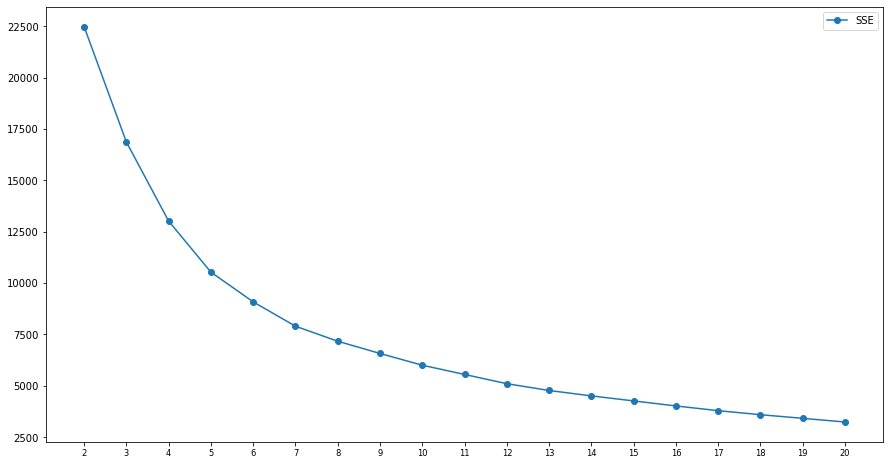

Number of colour columns: 2


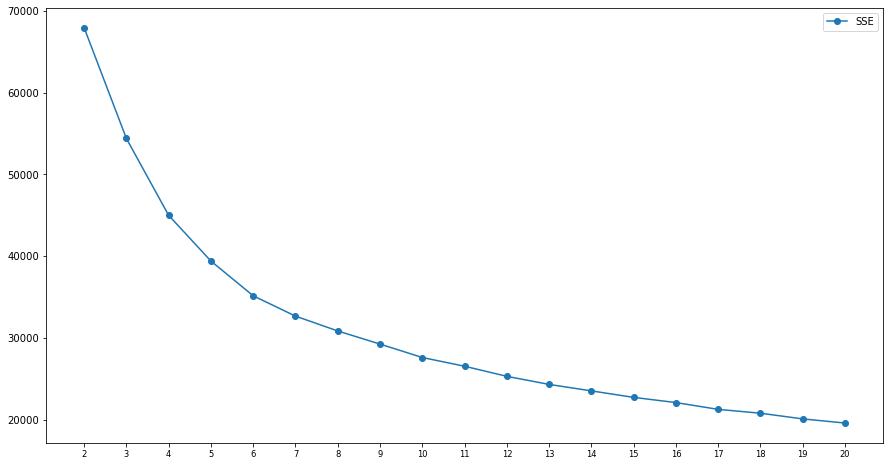

Number of colour columns: 3


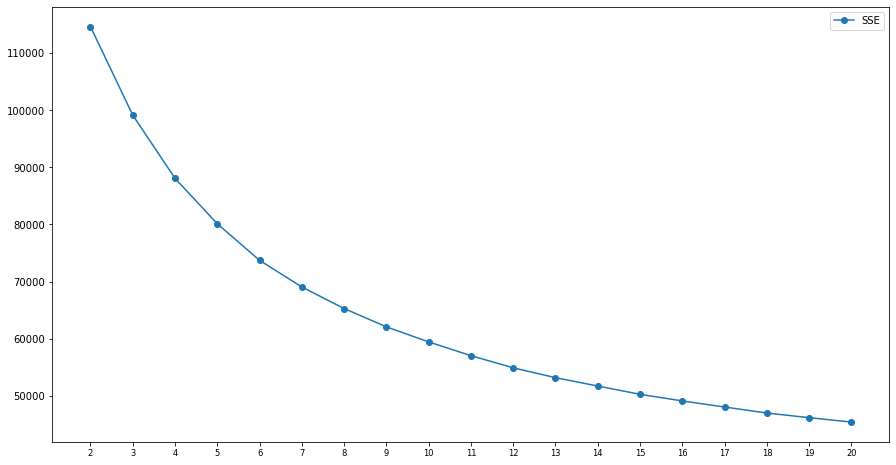

Number of colour columns: 4


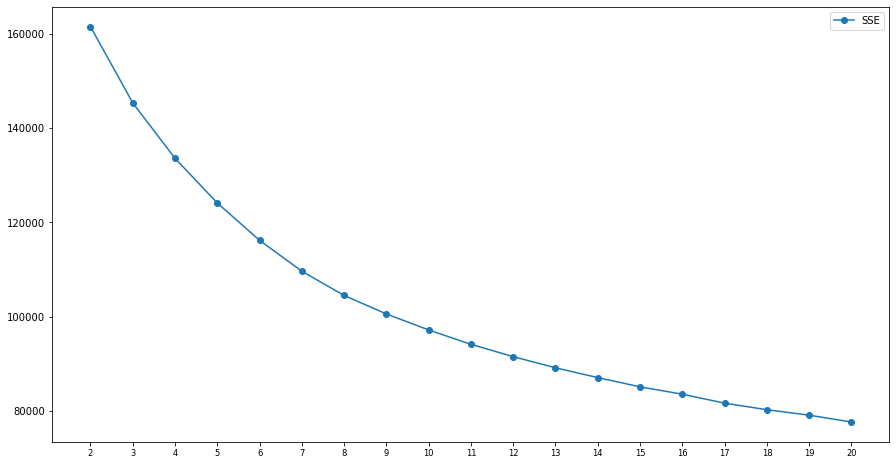

Number of colour columns: 5


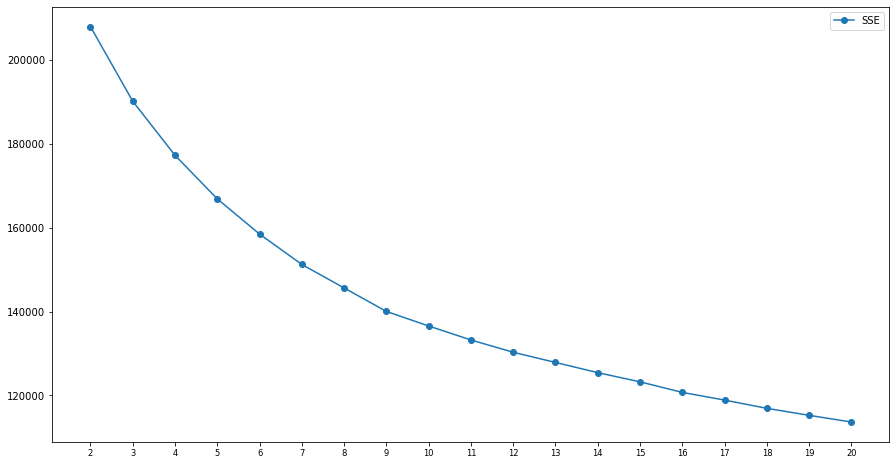

Number of colour columns: 6


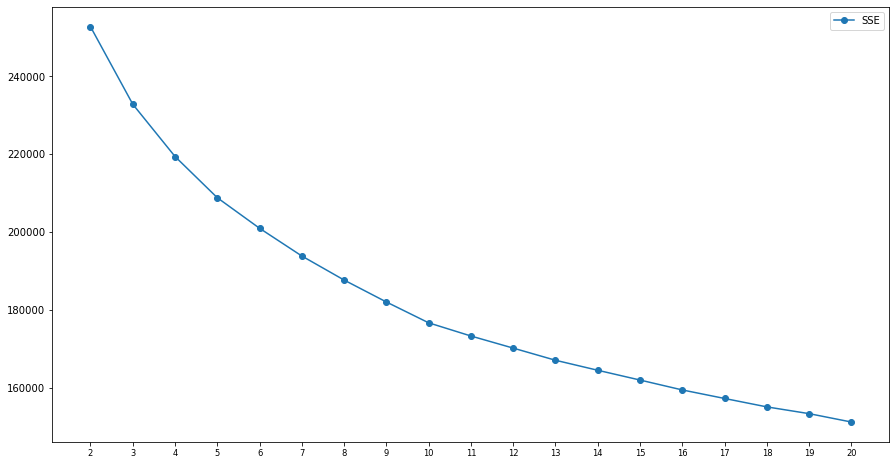

Number of colour columns: 7


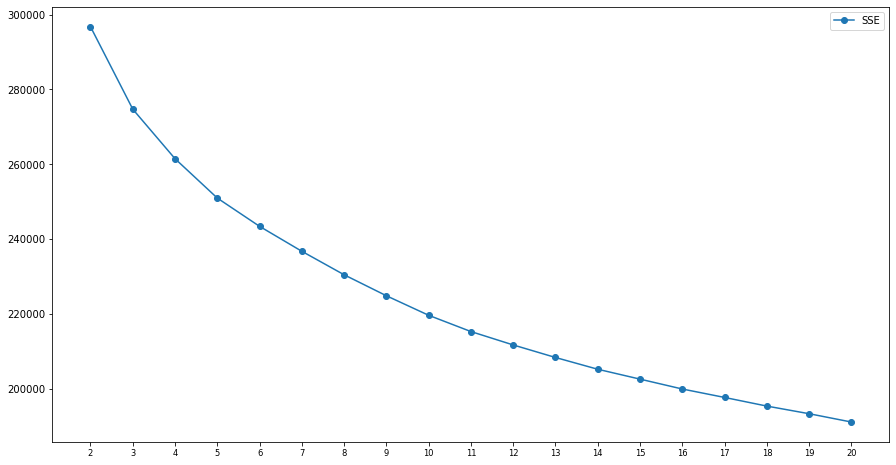

Number of colour columns: 8


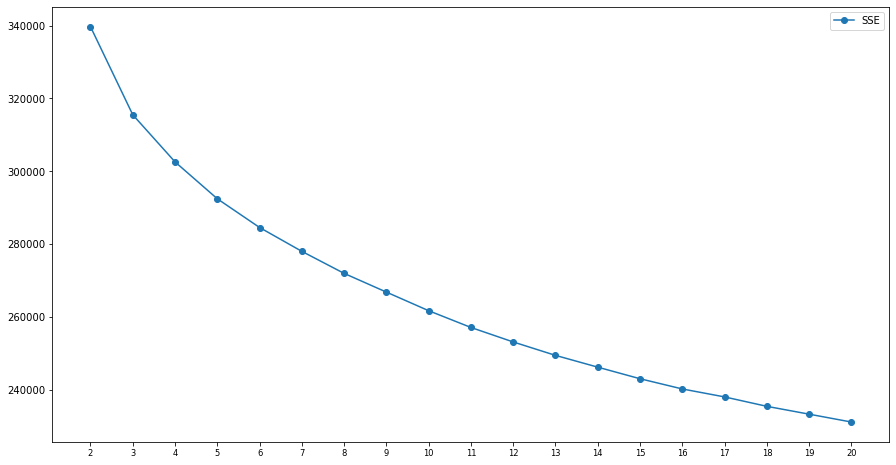

Number of colour columns: 9


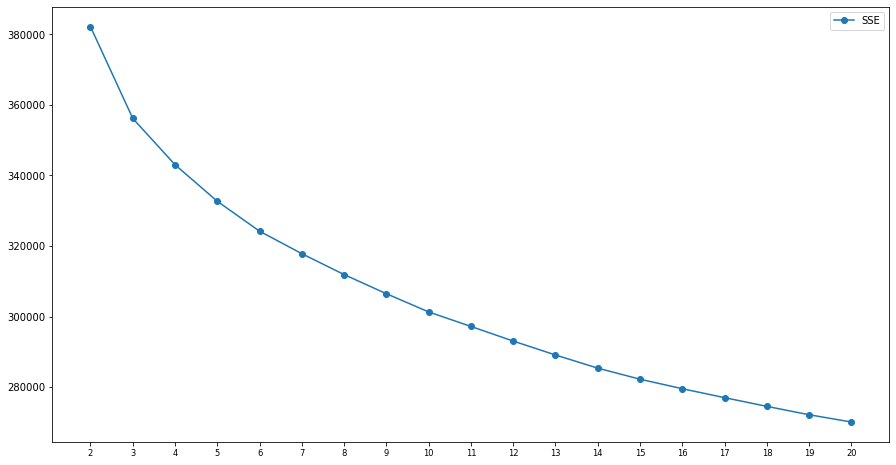

Number of colour columns: 10


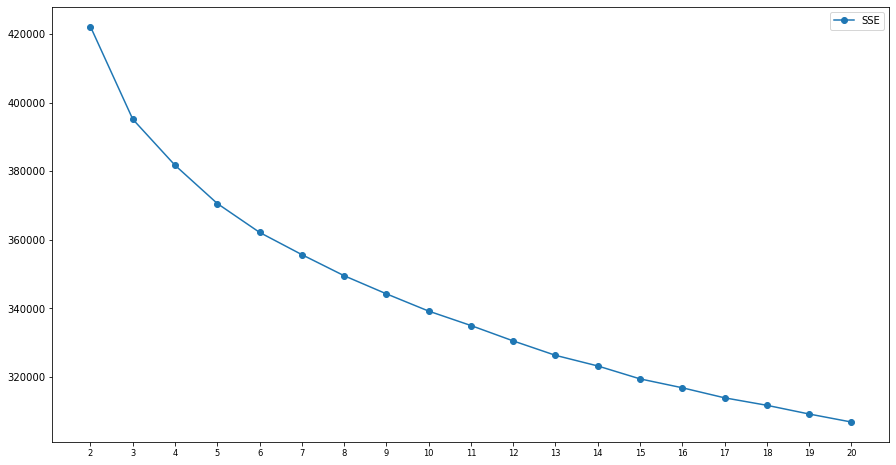

In [68]:
for number_of_columns in np.arange(4, 41,4):
    print(f'Number of colour columns: {int(number_of_columns/4)}')
    color_columns = ['red_0', 'green_0', 'blue_0', 
            'color_pixel_share_0', 'red_1', 'green_1','blue_1', 
            'color_pixel_share_1', 'red_2', 'green_2', 'blue_2',
            'color_pixel_share_2', 'red_3', 'green_3', 'blue_3',
            'color_pixel_share_3', 'red_4', 'green_4', 'blue_4',
            'color_pixel_share_4', 'red_5', 'green_5', 'blue_5',
            'color_pixel_share_5', 'red_6', 'green_6', 'blue_6',
            'color_pixel_share_6', 'red_7', 'green_7', 'blue_7',
            'color_pixel_share_7', 'red_8', 'green_8', 'blue_8',
            'color_pixel_share_8', 'red_9', 'green_9', 'blue_9',
            'color_pixel_share_9']


    color_columns = color_columns[:number_of_columns]
    color_data = X_train[color_columns]
    color_data = color_data.dropna()

    # scaling the data pre-segmentation
    sc=StandardScaler()
    X_sc = sc.fit_transform(color_data)

    SSE_array = []
    t=21
    
    # considering different numbers of segments
    for k in np.arange(2,t):

        km=KMeans(n_clusters=k)
        y_km = km.fit_predict(X_sc)   

        # data for elbow analysis
        SSE_array.append(km.inertia_)

    # Elbow chart
    t=21
    plt.figure(figsize=(15,8));
    plt.plot(SSE_array, "o-", label="SSE")
    plt.xticks(range(len(SSE_array)), range(2, 2+len(SSE_array)), size='small')
    plt.legend()
    plt.show()

It seems that using the top 2 columns for segmentation has the bigest benefit in terms of clustering impact

In [69]:
color_columns = ['red_0', 'green_0', 'blue_0', 
        'color_pixel_share_0', 'red_1', 'green_1','blue_1', 
        'color_pixel_share_1', 'red_2', 'green_2', 'blue_2',
        'color_pixel_share_2', 'red_3', 'green_3', 'blue_3',
        'color_pixel_share_3', 'red_4', 'green_4', 'blue_4',
        'color_pixel_share_4', 'red_5', 'green_5', 'blue_5',
        'color_pixel_share_5', 'red_6', 'green_6', 'blue_6',
        'color_pixel_share_6', 'red_7', 'green_7', 'blue_7',
        'color_pixel_share_7', 'red_8', 'green_8', 'blue_8',
        'color_pixel_share_8', 'red_9', 'green_9', 'blue_9',
        'color_pixel_share_9']
color_columns = color_columns[:8] # 2 colors is 2x4 columns
color_data = X_train[color_columns]
color_data = color_data.dropna()
sc=StandardScaler()
X_sc = sc.fit_transform(color_data)

Let's run the Silouette analysis depending on the number of clusters to further identify the optimal number of clusters

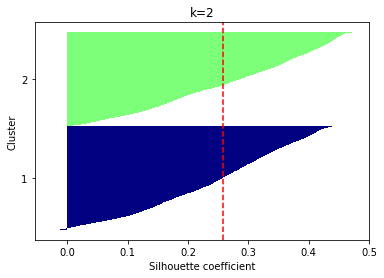

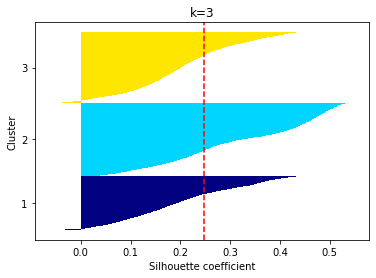

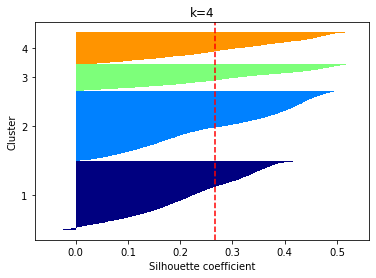

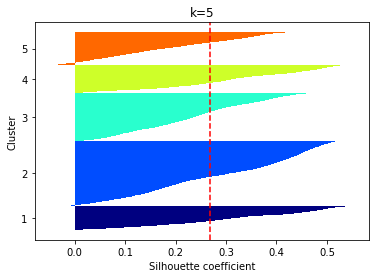

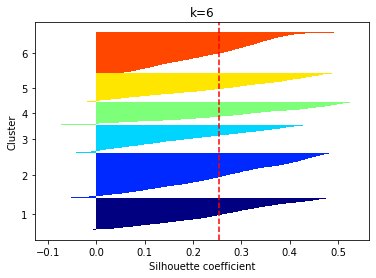

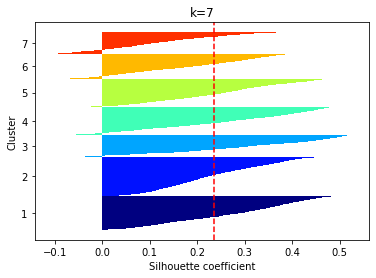

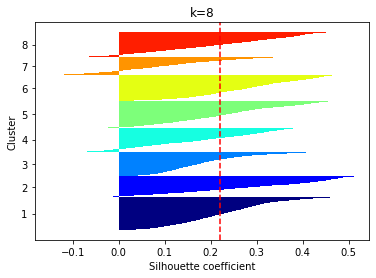

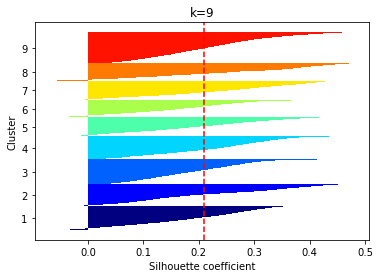

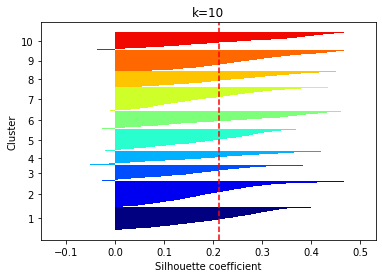

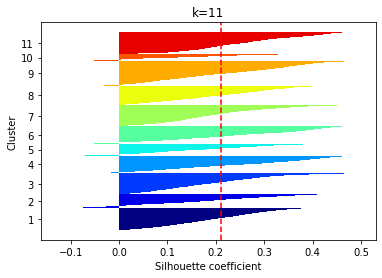

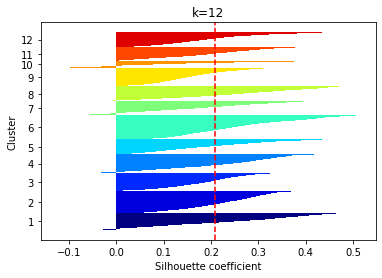

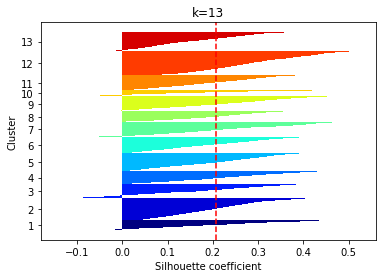

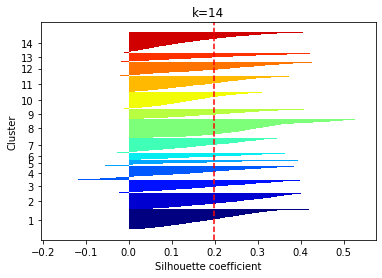

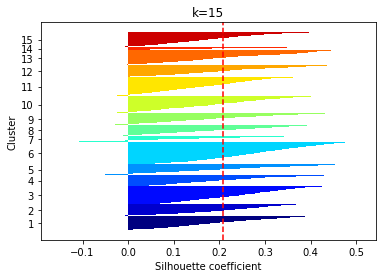

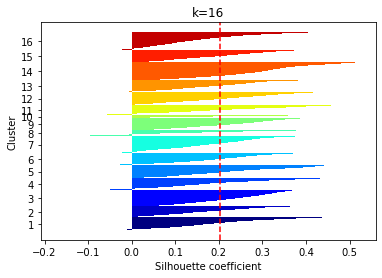

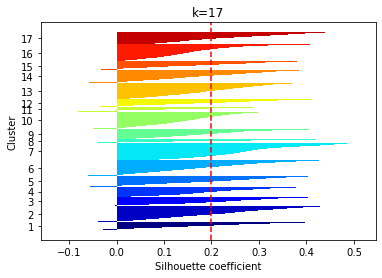

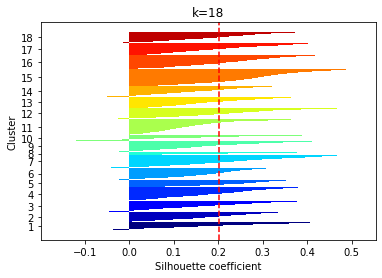

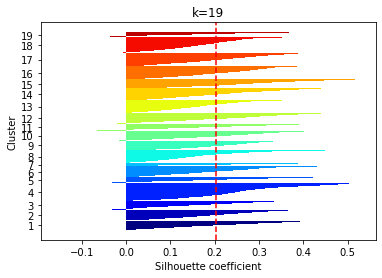

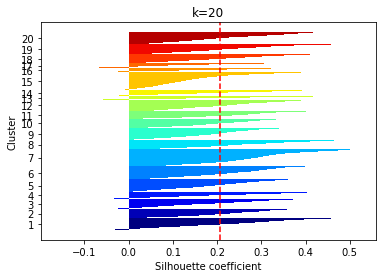

In [70]:
SSE_array = []
t=15
for k in np.arange(2,t):
    
    km=KMeans(n_clusters=k)
    y_km = km.fit_predict(X_sc)   
  
    # Elbow chart data
    SSE_array.append(km.inertia_)

    # Silhouette analysis
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X_sc, y_km, metric='euclidean')
    # Silhouette chart
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                 edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 
    plt.title(f'{k=}')
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    
    plt.show()



5 clusters look quite reasonable

The plan of handling colors:
- we will use the two most dominant colors with 5 clusters as the default, but we will fine tune it later

# 3. Data Cleaning, Feature Engineering
We will use pipelines to handle all data cleaning, missing values, outlier values, data encoding and feature engineering. Numeric and Categorical variables will be handled separately, and the different columns might be processed differently, as planned in the Section 2 above.

##  3.1 Transformers for Numeric Variables

In [8]:
#### Missing Values  

# imputing missing values based on a simple statistic from total sample
class ImputeNumColsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method='mean'):
        self.method=method
        self.impute_values={}
    
    def fit(self, X, y=None):
        if self.method == 'mean':
            for col in X:
                mean = X[col].mean()
                self.impute_values[col] = mean
        elif self.method == 'median':
            for col in X:
                median = X[col].median()
                self.impute_values[col] = median
        elif self.method == 'mode':
            for col in X:
                mode = X[col].mode()
                self.impute_values[col] = mode
        else:
            raise ValueError(
                f'"{self.method}" is not valid value of method parameter. Acceptable values are "mean" and "median"'
            )
        return self
    
    def transform(self, X, y=None):
        for col in X:
            value_to_impute = self.impute_values[col]
            X[col] = X[col].fillna(value_to_impute)
        return X


    
#### Outliers

# capping outliers based on interquantile range
class RemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.boundries = {}
        
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X:
            percentile_25 = np.nanpercentile(X[col], 25)
            percentile_75 = np.nanpercentile(X[col], 75)
            iqr = percentile_75 - percentile_25
            lower, upper = (percentile_25 - 1.5* iqr, percentile_75 + 1.5* iqr)
            self.boundries[col] = {'lower': lower, 'upper': upper}
        return self

    def transform(self, X, y=None):
        def trim_to_boundries(x, low, upp):
            if x<low:
                x=low
            elif x>upp:
                x=upp
            return x
        
        X = pd.DataFrame(X)
        for col in X:
            X[col] = X[col].apply(trim_to_boundries, low=self.boundries[col]['lower'], upp=self.boundries[col]['upper'])
        return X

    

#### New Custom Features
    
# creating new categorical variables based on numeric columns and a respective dictionary
class CreateNewCatColsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, config_dict: dict):
        self.config_dict = config_dict
        self.colnames = []
        
    def fit(self, X, y=None):
        temp = []
        for col in X:
            self.colnames.append(self.config_dict[col]['new_column_name'])
        return self

    def transform(self, X, y=None):
        new_X = pd.DataFrame(index=X.index)
        for col in X:
            new_X[self.config_dict[col]['new_column_name']] = self.config_dict[col]['na_value']            
            for condition in self.config_dict[col]['conditions_dict']:
                new_X.loc[X[col] == condition, self.config_dict[col]['new_column_name']] = self.config_dict[col]['conditions_dict'][condition]
            if self.config_dict[col]['else_value']:
                locations_to_update = X[col].apply(lambda x: (x not in list(self.config_dict[col]['conditions_dict'].keys())) & (~np.isnan(x)))
                new_X.loc[locations_to_update, self.config_dict[col]['new_column_name']] = self.config_dict[col]['else_value']
        return new_X
    
    def get_feature_names(self):
        return self.colnames

# clustering colors    
class ClusterColorsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 5, n_column_sets=2, column_name = 'color_clusters'):
        self.column_name = column_name
        self.n_clusters = n_clusters
        self.n_column_sets = n_column_sets
        self.sc=StandardScaler()
        self.km = KMeans(n_clusters=self.n_clusters)
        columns_per_set=4
        self.color_columns = color_columns[:self.n_column_sets*columns_per_set]    
        
    def fit(self, X, y=None):
        temp = X[self.color_columns].dropna()
        self.sc.fit(temp)
        temp = self.sc.transform(temp)
        self.km.fit(temp)
        return self
    
    def transform(self, X, y=None):
        clusters_df = pd.DataFrame(index = X.index)
        temp = X[self.color_columns].dropna()
        temp = self.sc.transform(temp)
        clusters = self.km.predict(temp)
        clusters_df.loc[~X[self.color_columns].isna().any(axis=1),self.column_name] = clusters
        return clusters_df
    
    def get_feature_names(self):
        return [self.column_name]

# calculating new variable baseed on share of "main" picture area from Google's vision
class NewPictureAreaTransformer(BaseEstimator, TransformerMixin):
    # Custom transformer to create a new variables based on Shape data
    def __init__(self, column_name='main_picture_share'):
        self.column_name = column_name
       
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        #share of the picture that is the main part
        main_picture = (X.main_picture_x_end - X.main_picture_x_start) * (X.main_picture_y_end-X.main_picture_y_start)
        picture_resolution = X.width * X.height
        X['main_picture_share'] = main_picture/picture_resolution

        #aggregation
        X = pd.DataFrame(X[self.column_name], columns = [self.column_name])
        return X

    def get_feature_names(self):
        return [self.column_name]


## 3.2 Transformers for Categorical Variables

In [9]:
#### Missing values

# simple imputation of mode for missing values
class ImputeCatColsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method = 'mode'):
        self.method = method
        self.impute_values = {}
        self.column_names = []
    
    def fit(self, X, y=None):
        self.column_names = list(X.columns)
        if self.method == 'mode':
            for col in X:
                mode = X[col].mode()[0]
                self.impute_values[col] = mode
        else:
            for col in X:
                self.impute_values[col] = self.method
        return self
    
    def transform(self, X, y=None):
        for col in X:
            X[col] = X[col].astype('object')
            X[col] = X[col].fillna(self.impute_values[col])
        return X
    
    def get_feature_names(self):
        return self.column_names

# imputation conditional on value in another column
class ImputeByCatColsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, recode_dict):
        self.recode_dict = recode_dict
        self.data_columns = list(recode_dict.keys())
        self.impute_values = {}
        self.known_by_values = {}
        
    def fit(self, X, y=None):
        for col in self.data_columns:
            if self.recode_dict[col]['fill_missing_method'] =='mode':
                by_column = self.recode_dict[col]['by_column_name']
                self.known_by_values[col] = list(X[by_column].unique())
                self.impute_values[col] = {}
                for condition in self.known_by_values[col]:
                    self.impute_values[col][condition] = X.loc[X[by_column] == condition, col].mode()
                self.impute_values[col]['not_anticipated_by_values'] = X[col].mode()
            else:
                raise ValueError(
                    f'"{self.method}" is not valid value of method parameter. Acceptable values are "mode""'
                    )
        return self
    
    def transform(self, X, y=None):
        for col in self.data_columns:
            values_to_recode = self.recode_dict[col]['missing_values']
            mapping = self.impute_values[col]
            by_column = self.recode_dict[col]['by_column_name']
            
            for condition in self.known_by_values[col]:
                for original_value in values_to_recode:
                    X.loc[(X[col]==original_value) & (X[by_column]==condition), col] = self.impute_values[col][condition]
            #if the by column value is not known, assigne global imputation ignoring by
            for original_value in values_to_recode:
                    X.loc[(X[col]==original_value), col] = self.impute_values[col]['not_anticipated_by_values']
                    
        X = X[self.data_columns]
        return X
    
    def get_feature_names(self):
        return self.data_columns

    
    
#### Data encoding
    
# simple recoding of values based on a dictionary
class RecodeCatColsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, recode_dict):
        self.recode_dict = recode_dict
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in X:
            mapping = self.recode_dict[col]
            for original_value in mapping:
                X.loc[X[col]==original_value, col] = mapping[original_value]
        return X

# recoding conditional on value in another column
class RecodeByCatColsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, recode_dict):
        self.recode_dict = recode_dict
        self.data_columns = list(config_dict.keys())
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in self.data_columns:
            values_to_recode = list(self.recode_dict[col]['mapping'].keys())
            mapping = self.recode_dict[col]['mapping']
            by_column = self.recode_dict[col]['by_column_name']
            for original_value in values_to_recode:
                mapping = self.recode_dict[col]['mapping'][original_value]
                for condition in list(mapping.keys()):
                    X.loc[(X[col]==original_value) & (X[by_column]==condition), col] = \
                        X.loc[(X[col]==original_value) & (X[by_column]==condition), by_column].map[mapping]
        X = X[self.data_columns]
        return X
    
    def get_feature_names(self):
        return self.data_columns

# transformation that uses Count Vectorizer to handle multiple columns coded separately that 
# will also pass new feature names    
class CatColsCountVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words='english', token_pattern=r'(?u)\b\w\w+\b', max_features=None):
        self.stop_words = stop_words
        self.max_features = max_features
        self.token_pattern = token_pattern
        self.CVs = {}
        self.column_names = []
            
    def fit(self, X, y=None):
        for col in X:
            cv = CountVectorizer(stop_words=self.stop_words, token_pattern= self.token_pattern, 
                                 max_features=self.max_features)
            cv.fit(X[col])
            self.CVs[col] = cv
            self.column_names.extend([f'{col}_{cateogry}'for cateogry in cv.get_feature_names()])
        return self
    
    def transform(self, X, y=None):
        for i, col in enumerate(X):
            vectorized_column = self.CVs[col].transform(X[col]).toarray()
            if i == 0:
                vectorized_all_columns = vectorized_column
            else:
                np.hstack((vectorized_all_columns, vectorized_column))
        return vectorized_all_columns
    
    def get_feature_names(self):
        return self.column_names

# simple recoding values in categories below threshold count that will be aggregated into
# an "other" category
class AggregateCatColsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, min_count = 30, aggregated_label='other'):
        self.min_count = min_count
        self.classes_to_keep = {}
        self.aggregated_label = aggregated_label
        self.data_columns = []
            
    def fit(self, X, y=None, ):
        for col in X:
            unique_classes = X[col].value_counts()
            self.classes_to_keep[col] = list(unique_classes[unique_classes >= self.min_count].index)
            self.data_columns.append(col)
        return self
    
    def transform(self, X, y=None):
        for col in X:
            unique_classes = list(X[col].value_counts().index)
            temp_classes_to_keep = self.classes_to_keep[col]
            classess_to_aggregate = [x for x in unique_classes if x not in temp_classes_to_keep]
            for single_class in classess_to_aggregate:
                X.loc[X[col] == single_class, col] = self.aggregated_label 
        return X
    
    def get_feature_names(self):
        return self.data_columns

# recoding values in categories below threshold count that will be aggregated into
# an "other" category depending on another column
class AggregateByCatColsTransformer(BaseEstimator, TransformerMixin):
    # IMPORTANT - this must be followed by impute by, otherwise the by columns will not be removed
    def __init__(self, config_dict, min_count = 30):
        self.config_dict = config_dict
        self.min_count = min_count
        self.classes_to_keep = {}
        self.data_columns = list(config_dict.keys())
            
    def fit(self, X, y=None, ):
        for col in self.data_columns:
            reference_column = self.config_dict[col]['by_column_name']
            unique_classes = X[col].value_counts()
            self.classes_to_keep[col] = list(unique_classes[unique_classes >= self.min_count].index)
        return self
    
    def transform(self, X, y=None):
        for col in self.data_columns:
            reference_column = self.config_dict[col]['by_column_name']
            unique_classes = list(X[col].value_counts().index)
            temp_classes_to_keep = self.classes_to_keep[col]
            classess_to_aggregate = [x for x in unique_classes if x not in temp_classes_to_keep]
            by_dict = self.config_dict[col]['new_names_dict']
            for single_class in classess_to_aggregate:
                X.loc[X[col] == single_class, col] = X.loc[X[col] == single_class, reference_column].map(by_dict) 
        return X[self.data_columns]
    
    def get_feature_names(self):
        return self.data_columns
       

#### New Features

# New variable based on missing information in another variable
class NewBasedOnNanCatColsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, config_dict: dict):
        self.config_dict = config_dict
        self.colnames = []
    
    def fit(self, X, y=None):
        for col in X:
            new_column_name = self.config_dict[col]['new_column_name']
            self.colnames.append(new_column_name)
        return self

    def transform(self, X, y=None):
        new_X = pd.DataFrame(index=X.index)
        for col in X:
            new_column_name = self.config_dict[col]['new_column_name']
            value_if_nan = self.config_dict[col]['value_if_nan']
            else_value = self.config_dict[col]['else_value']
            new_X[new_column_name] = else_value
            new_X.loc[X[col].isna(), new_column_name] = value_if_nan
        return new_X
        
    def get_feature_names(self):
        return self.colnames

# New variable based on joining text values from other variables
def aggregate_breeds(x: list) -> str:
    # function to help aggregating multiple text variables into one variable
    breeds = [breed for breed in x if breed != 'na']
    # remove duplicates
    breeds = list(set(breeds))
    breeds.sort()
    breeds_string = '-'.join(breeds)
    return breeds_string   
# The transformer to create the new variable
class AggregatTextColsTransformer(BaseEstimator, TransformerMixin):
    # Custom transformer to handle breeds2 data
    def __init__(self, column_name):
        self.column_name = column_name
       
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X.agg(aggregate_breeds, axis=1), columns = [self.column_name])
        return X

    def get_feature_names(self):
        return [self.column_name]   
    
    
#### New Custom Features
# Here very custom transformers start, create to handle specific situation/variables

# Creating a new variable based on Gender and Qiantity
class NewGenderQuantityTransformer(BaseEstimator, TransformerMixin):
    # Custom transformer to create a new variable based on Gender and Quantity
    def __init__(self, column_name='multiple_gender'):
        self.column_name = column_name
       
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.loc[X.Quantity == 1, self.column_name] = 'single_animal'
        X.loc[(X.Quantity != 1) & (X.Gender != 'Mixed'), self.column_name] = 'multiple_animals_same_gender'
        X.loc[(X.Quantity != 1) & (X.Gender == 'Mixed'), self.column_name] = 'multiple_animals_different_genders'
        X = pd.DataFrame(X[self.column_name], columns = [self.column_name])
        return X

    def get_feature_names(self):
        return [self.column_name]  

    
# New variables with additional information on image
class NewImageDimensionsTransformer(BaseEstimator, TransformerMixin):
    # Custom transformer to create a new variables based on Shape data
    def __init__(self, column_name=['image_shape', 'image_size', ]):
        self.column_name = column_name
       
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #fill na with mode and split dimensions
        X.dimensions = X.dimensions.fillna(X.dimensions.mode()[0])
        X[['width', 'height']] = X.dimensions.str.split('x',1, expand=True)
        X[['width', 'height']] = X[['width', 'height']].astype(int)

        #shape
        X['image_shape'] = 'square' 
        X.loc[X.width>X.height, 'image_shape'] = 'horisontal'
        X.loc[X.width<X.height, 'image_shape'] = 'vertical'

        #size
        X['image_size'] = 'medium' 
        X.loc[(X.width>600) | (X.height >600), 'image_size'] = 'large'
        X.loc[(X.width<300) | (X.height <300), 'image_size'] = 'small'
        X = pd.DataFrame(X[self.column_name], columns = self.column_name)
        return X

    def get_feature_names(self):
        return self.column_name


## 3.3 Recoding the Dependent variable
As noticed before, we need to combine the observations from Category 0 of the dependent variable with Category 1 due to low incidence of Category 0.

In [10]:
# The Class below is strongly inspired by sklearn's LabelEncoder
class YEncoder(TransformerMixin, BaseEstimator):

    def fit(self, X=None, y=None):
        return self

    def fit_transform(self, X=None, y=None):
        y[y<3] = 1
        y[y>=3] = 0
        if X is None:
            return y
        else:
            return X, y

    def transform(self, X=None, y=None):
        y[y<3] = 1
        y[y>=3] = 0
        if X is None:
            return y
        else:
            return X, y

In [11]:
y_train.value_counts()

4    3357
2    3230
3    2607
1    2472
0     328
Name: AdoptionSpeed, dtype: int64

In [12]:
y_encoder = YEncoder()
y_train_enc = y_encoder.fit_transform(y=y_train)
y_test_enc = y_encoder.transform(y=y_test)

In [13]:
y_train_enc.value_counts()

1    6030
0    5964
Name: AdoptionSpeed, dtype: int64

## 3.4 The Pipeline

#### Let's review the list of variables that we want to coprocess

In [11]:
numeric_columns = X_train.select_dtypes(include=np.number).columns
numeric_columns

Index(['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'sentiment',
       'magnitude', 'combined_sentiment', 'number_of_sentences',
       'avg_sentence_score', 'min_sentence_score', 'max_sentence_score',
       'sum_sentence_score', 'score_0', 'score_1', 'score_2', 'score_3',
       'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9',
       'red_0', 'green_0', 'blue_0', 'color_pixel_share_0', 'red_1', 'green_1',
       'blue_1', 'color_pixel_share_1', 'red_2', 'green_2', 'blue_2',
       'color_pixel_share_2', 'red_3', 'green_3', 'blue_3',
       'color_pixel_share_3', 'red_4', 'green_4', 'blue_4',
       'color_pixel_share_4', 'red_5', 'green_5', 'blue_5',
       'color_pixel_share_5', 'red_6', 'green_6', 'blue_6',
       'color_pixel_share_6', 'red_7', 'green_7', 'blue_7',
       'color_pixel_share_7', 'red_8', 'green_8', 'blue_8',
       'color_pixel_share_8', 'red_9', 'green_9', 'blue_9',
       'color_pixel_share_9', 'main_picture_x_start', 'main_picture_y_start'

In [12]:
non_numeric_columns = X_train.select_dtypes(exclude=np.number).columns
non_numeric_columns

Index(['Type', 'Name', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'State', 'RescuerID', 'Description', 'PetID',
       'description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'full_description', 'description_9', 'dimensions'],
      dtype='object')

#### Creating the pipeline

In [14]:
def categories_to_drop(X: pd.DataFrame, column_names: list):
    cats_to_drop = []
    for col in X[column_names]:
        if (X[col].value_counts().size == 2) & (list(X[col].value_counts().index.sort_values())==['No', 'Yes']):
            cats_to_drop.append('No')
        else:
            cats_to_drop.append(X[col].mode()[0])
    print(cats_to_drop)
    return cats_to_drop
            

In [15]:
# Categorical variables

# Drop: 'RescuerID','PetID', 'description_0', 'description_1', 'description_2', 'description_3',
#       'description_4', 'description_5', 'description_6', 'description_7',
#       'description_8','description_9',

# categorical values with no transformation
first_cat_sub_columns = ['Type',  'Gender', 'Color1', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'State'] 
first_categories_to_drop = categories_to_drop(X_train, first_cat_sub_columns)
first_cat_sub_pipeline = Pipeline([
    ('imput', ImputeCatColsTransformer('mode')),
    ('aggregate', AggregateCatColsTransformer(min_count = 30)),
    ('encode', OneHotEncoder(sparse=False, handle_unknown='error', drop=first_categories_to_drop))
])

# categorical values with recoding categories
recode_dict = {'MaturitySize': {'Extra Large': 'Large'},
              'Health': {"Serious Injury": "Injury",  "Minor Injury": "Injury"},
              }
second_cat_sub_columns = list(recode_dict.keys())                       
second_categories_to_drop = categories_to_drop(X_train, second_cat_sub_columns)
second_cat_sub_pipeline = Pipeline([
    ('recode', RecodeCatColsTransformer(recode_dict)),
    ('imput', ImputeCatColsTransformer('mode')),
    ('aggregate', AggregateCatColsTransformer(min_count = 30)),
    ('encode', OneHotEncoder(sparse=False, handle_unknown='error', drop=second_categories_to_drop))
])                         
                         
# categorical values for tokenization                   

max_features = 100
third_cat_sub_columns = ['Description']  
                         
third_cat_sub_pipeline = Pipeline([
    ('imput', ImputeCatColsTransformer('mode')),
    ('tokenize', CatColsCountVectorizer(stop_words='english', max_features=max_features))
])                         

token_pattern = r"([A-Za-z0-9 ]*)[;-]*" # token pattern for Breeds and Colors variables (using - and ; as delimiters)
max_features = 50
fourth_cat_sub_columns = ['full_description']
                         
fourth_cat_sub_pipeline = Pipeline([
    ('imput', ImputeCatColsTransformer('mode')),
    ('tokenize', CatColsCountVectorizer(stop_words=None, token_pattern=token_pattern, max_features=max_features))
])

new_nan_columns_config = {
    'Name': {'new_column_name': 'has_name',
                 'else_value': 1,
                 'value_if_nan': 0}}
fifth_cat_sub_columns = list(new_nan_columns_config.keys())
fifth_cat_sub_pipeline = Pipeline([
    ('new_column', NewBasedOnNanCatColsTransformer(new_nan_columns_config)),
    ('imput', ImputeCatColsTransformer('mode')),
    ('encode', OneHotEncoder(sparse=False, handle_unknown='error', drop=[0]))
])


aggregate_by_columns_config = {'Breed1': {'by_column_name': 'Type', 
               'new_names_dict': {'Dog': 'Dog Purebred Other', 'Cat':  'Cat Purebred Other'},
            'fill_missing_method': 'mode',
            'missing_values': ['na']}}
sixth_cat_sub_data_columns = list(aggregate_by_columns_config.keys())
sixth_cat_sub_reference_columns = [aggregate_by_columns_config[x]['by_column_name'] 
                                   for x in sixth_cat_sub_data_columns]
sixth_cat_sub_columns = sixth_cat_sub_data_columns + sixth_cat_sub_reference_columns
sixth_categories_to_drop = categories_to_drop(X_train, sixth_cat_sub_data_columns)
sixth_cat_sub_pipeline = Pipeline([
    ('new_column', AggregateByCatColsTransformer(aggregate_by_columns_config, min_count = 30)),
    #('imput', ImputeByCatColsTransformer(aggregate_by_columns_config)),
    ('imput', ImputeCatColsTransformer('breed_unknown')),
    ('aggregate', AggregateCatColsTransformer(min_count = 30)),
    ('encode', OneHotEncoder(sparse=False, handle_unknown='error', drop='first'))
])

token_pattern = r"([A-Za-z0-9 ]*)[;-]*"
max_features = 50
seventh_cat_sub_columns = ['Breed1', 'Breed2']
seventh_cat_sub_pipeline = Pipeline([
    ('new_column', AggregatTextColsTransformer('breeds')),
    ('tokenize', CatColsCountVectorizer(stop_words=None, token_pattern=token_pattern, max_features=max_features))
])

token_pattern = r"([A-Za-z0-9 ]*)[;-]*"
max_features = 50
eight_cat_sub_columns = ['Color1', 'Color2', 'Color3']
eight_cat_sub_pipeline = Pipeline([
    ('new_column', AggregatTextColsTransformer('colors')),
    ('tokenize', CatColsCountVectorizer(stop_words=None, token_pattern=token_pattern, max_features=max_features))
])


nineth_cat_sub_columns = ['Quantity', 'Gender']
nineth_cat_sub_pipeline = Pipeline([
    ('new_column', NewGenderQuantityTransformer()),
    ('imput', ImputeCatColsTransformer('mode')),
    #('aggregate', AggregateCatColsTransformer(min_count = 30)),
    ('encode', OneHotEncoder(sparse=False, handle_unknown='error', drop=['single_animal']))
])


tenth_cat_sub_columns = ['dimensions']
tenth_cat_sub_pipeline = Pipeline([
    ('new_column', NewImageDimensionsTransformer()),
    ('imput', ImputeCatColsTransformer('mode')),
    ('aggregate', AggregateCatColsTransformer(min_count = 30)),
    ('encode', OneHotEncoder(sparse=False, handle_unknown='error', drop='first'))
])


### Numeric Columns

# numeric values with no transformation
first_num_sub_columns = ['sentiment','avg_sentence_score', 'min_sentence_score', 'max_sentence_score',
       'sum_sentence_score', 'score_0', 'score_1', 'score_2', 'score_3',
       'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 
        'Age', 'PhotoAmt', 'magnitude', 'combined_sentiment', 'number_of_sentences', 'Quantity', 'Fee', 'VideoAmt',
                    ]
first_num_sub_pipeline = Pipeline([
    ('imput', ImputeNumColsTransformer('median')),
    ('power', PowerTransformer()),
    ('outliers', RemoveOutliersTransformer()),
    ('scaling', StandardScaler())
])

# new categorical values based on numeric
new_columns_config = {
    'Quantity': {'new_column_name': 'quantity_group',
                 'conditions_dict': {1: 'one_animal', 2: 'two animals'}, 
                 'else_value': 'three or more animals',
                'na_value': np.nan},
    'Fee': {'new_column_name': 'has_fee',
            'conditions_dict': {0: 0}, 
            'else_value': 1,
            'na_value': np.nan},
    'VideoAmt': {'new_column_name': 'has_video',
                 'conditions_dict': {0: 0}, 
                 'else_value': 1,
                 'na_value': np.nan},
    'PhotoAmt': {'new_column_name': 'has_photo',
                 'conditions_dict': {0: 0}, 
                 'else_value': 1,
                 'na_value': np.nan}}
fifth_num_sub_columns = list(new_columns_config.keys())
fifth_num_sub_pipeline = Pipeline([
    ('new_column', CreateNewCatColsTransformer(new_columns_config)),
    ('imput', ImputeCatColsTransformer('mode')),
    ('encode', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])
    
# color variables for clustering
color_columns = ['red_0', 'green_0', 'blue_0', 
        'color_pixel_share_0', 'red_1', 'green_1','blue_1', 
        'color_pixel_share_1', 'red_2', 'green_2', 'blue_2',
        'color_pixel_share_2', 'red_3', 'green_3', 'blue_3',
        'color_pixel_share_3', 'red_4', 'green_4', 'blue_4',
        'color_pixel_share_4', 'red_5', 'green_5', 'blue_5',
        'color_pixel_share_5', 'red_6', 'green_6', 'blue_6',
        'color_pixel_share_6', 'red_7', 'green_7', 'blue_7',
        'color_pixel_share_7', 'red_8', 'green_8', 'blue_8',
        'color_pixel_share_8', 'red_9', 'green_9', 'blue_9',
        'color_pixel_share_9']
sixth_num_sub_columns = color_columns
sixth_num_sub_pipeline = Pipeline([
    ('clustering', ClusterColorsTransformer(n_clusters = 6, n_column_sets=2)),
    ('imput', ImputeCatColsTransformer('mode')),
    ('encode', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])   

seventh_num_sub_columns = ['main_picture_x_start', 'main_picture_y_start',
       'main_picture_x_end', 'main_picture_y_end', 'width', 'height']
seventh_num_sub_pipeline = Pipeline([
    ('new_column', NewPictureAreaTransformer()),
    ('imput', ImputeNumColsTransformer('median')),
    ('power', PowerTransformer()),
    ('outliers', RemoveOutliersTransformer()),
    ('scaling', StandardScaler())
])


# X data transformer
transformer = ColumnTransformer(transformers=[
    ('first_cat', first_cat_sub_pipeline, first_cat_sub_columns),
    ('second_cat', second_cat_sub_pipeline, second_cat_sub_columns),
    ('third_cat', third_cat_sub_pipeline, third_cat_sub_columns),
    ('fourth_cat', fourth_cat_sub_pipeline, fourth_cat_sub_columns),
    ('fifth_cat', fifth_cat_sub_pipeline, fifth_cat_sub_columns),
    ('sixth_cat', sixth_cat_sub_pipeline, sixth_cat_sub_columns),
    ('seventh_cat', seventh_cat_sub_pipeline, seventh_cat_sub_columns),
    ('eight_cat', eight_cat_sub_pipeline, eight_cat_sub_columns),
    ('nineth_cat', nineth_cat_sub_pipeline, nineth_cat_sub_columns),
    ('tenth_cat', tenth_cat_sub_pipeline, tenth_cat_sub_columns),
    ('first_num', first_num_sub_pipeline, first_num_sub_columns),
    ('fifth_num', fifth_num_sub_pipeline, fifth_num_sub_columns),
    ('sixth_num', sixth_num_sub_pipeline, sixth_num_sub_columns),
    ('seventh_num', seventh_num_sub_pipeline, seventh_num_sub_columns),
])


# The total pipeline
pipeline = Pipeline(steps = [
    ('preprocessor', transformer),
    ('classifier', LogisticRegression())
])

['Dog', 'Female', 'Black', 'Short', 'No', 'Yes', 'No', 'Selangor']
['Medium', 'Healthy']
['Mixed Breed']


In [16]:
# we will copy the original, untuned pipeline so we can later use the fresh version
original_pipeline = deepcopy(pipeline)

#### Get column names
The transformer used in the pipeline transforms the data into a Numpy array. For further analysis we want to identify the corresponding variable name to assess which features impact the final model.

In [20]:
# getting column names from OneHot as a combination of original column and OneHot's get_feature_names method
def get_column_names_from_onehot(columns, onehot):
    pattern = r'x([0-9]*)_(.*)'
    onehot_names = onehot.get_feature_names()
    pretty_names = []
    for ugly_name in onehot_names:
        column_number, category = re.findall(pattern, ugly_name)[0]
        number = int(column_number)
        pretty_names.append(f'{columns[number]}_{category}')
    return pretty_names

In [21]:
# Getting names of variables of different type requires either getting the variables that are beign processed
# in each sub pipeline, or special processing for new custom features (using the deticated get_feature_name()
# Method created for those transformers), or using OneHot encoder based custom function

def get_pipeline_column_names(fitted_transformer):
    colnames = []
    # different approach is valid depending on the column set transformations used
    for t in fitted_transformer.transformers_[0:2]:
        colnames.extend(get_column_names_from_onehot(t[2], t[1][-1]))
    for t in fitted_transformer.transformers_[2:4]:
        colnames.extend(t[1][-1].get_feature_names())
    for t in fitted_transformer.transformers_[4:6]:
        colnames.extend(get_column_names_from_onehot(t[1][0].get_feature_names(), t[1][-1]))
    for t in fitted_transformer.transformers_[6:8]:
        colnames.extend(t[1][-1].get_feature_names())
    for t in fitted_transformer.transformers_[8:10]:
        colnames.extend(get_column_names_from_onehot(t[1][0].get_feature_names(), t[1][-1]))
    for t in fitted_transformer.transformers_[10:11]:
        colnames.extend(t[2])
    for t in fitted_transformer.transformers_[11:13]:
        colnames.extend(get_column_names_from_onehot(t[1][0].get_feature_names(), t[1][-1]))
    for t in fitted_transformer.transformers_[13:14]:
        colnames.extend(t[1][0].get_feature_names())    
    return colnames


In [22]:
transformer.fit(X_train, y_train)
result = transformer.transform(X_train)

In [23]:
colnames = get_pipeline_column_names(transformer)
colnames

['Type_Cat',
 'Gender_Male',
 'Gender_Mixed',
 'Color1_Brown',
 'Color1_Cream',
 'Color1_Golden',
 'Color1_Gray',
 'Color1_White',
 'Color1_Yellow',
 'FurLength_Long',
 'FurLength_Medium',
 'Vaccinated_Not Sure',
 'Vaccinated_Yes',
 'Dewormed_No',
 'Dewormed_Not Sure',
 'Sterilized_Not Sure',
 'Sterilized_Yes',
 'State_Johor',
 'State_Kedah',
 'State_Kuala Lumpur',
 'State_Melaka',
 'State_Negeri Sembilan',
 'State_Pahang',
 'State_Perak',
 'State_Pulau Pinang',
 'State_other',
 'MaturitySize_Large',
 'MaturitySize_Small',
 'Health_Injury',
 'Description_abandoned',
 'Description_able',
 'Description_active',
 'Description_adopt',
 'Description_adopted',
 'Description_adopter',
 'Description_adopters',
 'Description_adoption',
 'Description_adorable',
 'Description_age',
 'Description_area',
 'Description_attention',
 'Description_away',
 'Description_beautiful',
 'Description_birth',
 'Description_black',
 'Description_boy',
 'Description_breed',
 'Description_bring',
 'Description_ca

#### Show transformed data as dataframe
At this stage we want to make sure that columns match the data to avoid wrong interpretation of the model results

In [24]:
result = pd.DataFrame(result, columns=colnames) 
result

Type_Cat  Gender_Male  Gender_Mixed  Color1_Brown  Color1_Cream  \
0           0.0          1.0           0.0           1.0           0.0   
1           0.0          1.0           0.0           0.0           0.0   
2           0.0          1.0           0.0           0.0           0.0   
3           1.0          1.0           0.0           0.0           0.0   
4           0.0          0.0           1.0           0.0           0.0   
...         ...          ...           ...           ...           ...   
11989       0.0          1.0           0.0           0.0           0.0   
11990       0.0          0.0           0.0           1.0           0.0   
11991       1.0          0.0           1.0           0.0           0.0   
11992       0.0          1.0           0.0           0.0           0.0   
11993       0.0          0.0           0.0           0.0           0.0   

       Color1_Golden  Color1_Gray  Color1_White  Color1_Yellow  \
0                0.0          0.0           0.0            0.0   
1                0.0          0.0           0.0            0.0   
2                0.0          0.0           0.0            0.0   
3                0.0          1.0           0.0            0.0   
4                0.0          0.0           0.0            0.0   
...              ...          ...           ...            ...   
11989            0.0          0.0           0.0            0.0   
11990            0.0          0.0           0.0            0.0   
11991            0.0          0.0           0.0            0.0   
11992            0.0          0.0           0.0            0.0   
11993            0.0          0.0           0.0            0.0   

       FurLength_Long  ...  has_video_1.0  has_photo_0.0  has_photo_1.0  \
0                 1.0  ...            0.0            0.0            1.0   
1                 0.0  ...            0.0            0.0            1.0   
2                 0.0  ...            0.0            0.0            1.0   
3                 0.0  ...            0.0            1.0            0.0   
4                 0.0  ...            0.0            0.0            1.0   
...               ...  ...            ...            ...            ...   
11989             0.0  ...            0.0            0.0            1.0   
11990             0.0  ...            0.0            0.0            1.0   
11991             0.0  ...            0.0            0.0            1.0   
11992             0.0  ...            0.0            0.0            1.0   
11993             0.0  ...            0.0            0.0            1.0   

       color_clusters_0.0  color_clusters_1.0  color_clusters_2.0  \
0                     0.0                 0.0                 1.0   
1                     0.0                 1.0                 0.0   
2                     0.0                 1.0                 0.0   
3                     0.0                 1.0                 0.0   
4                     0.0                 0.0                 0.0   
...                   ...                 ...                 ...   
11989                 1.0                 0.0                 0.0   
11990                 0.0                 0.0                 0.0   
11991                 0.0                 0.0                 0.0   
11992                 0.0                 0.0                 0.0   
11993                 0.0                 0.0                 1.0   

       color_clusters_3.0  color_clusters_4.0  color_clusters_5.0  \
0                     0.0                 0.0                 0.0   
1                     0.0                 0.0                 0.0   
2                     0.0                 0.0                 0.0   
3                     0.0                 0.0                 0.0   
4                     0.0                 0.0                 1.0   
...                   ...                 ...                 ...   
11989                 0.0                 0.0                 0.0   
11990                 0.0                 0

# 4. The model
We will consider different classifier models with different data transformations. We will want to identify the model with a good trade-off between model precision and interpretability.<br>
We will treat balance between Precision and Recall as the most important measure - we will therefore use the F1 score as the key measure for comparing the models.

## 4.1 Baseline models
We will start by creating very simple prediction models to be able to assess the improvement and quality coming from the more sophisticated machine learning models

### 4.1.1 Random prognosis

In [116]:
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train_enc)
y_pred = dummy.predict(X_test)
confusion_matrix(y_test_enc, y_pred) #true in rows, predicted in columns

array([[744, 748],
       [742, 765]])

In [117]:
scores = {'Accuracy ': round(accuracy_score(y_test_enc, y_pred),6),
          'Precision': round(precision_score(y_test_enc, y_pred),6), 
          'Recall   ': round(recall_score(y_test_enc, y_pred),6), 
          'F1       ': round(f1_score(y_test_enc, y_pred),6)}
scores

{'Accuracy ': 0.503168,
 'Precision': 0.505618,
 'Recall   ': 0.507631,
 'F1       ': 0.506623}

Baseline F1 is 51% resulting from random assignment of the classes - we will use it to benchmark precision of our models.

## 4.2 Logistic regression
We will start with Logistic Regression models. The advantage of them is that they are relatively simple and it is easy to draw conclusion what the key factors are to increase adoption speed.

### 4.2.1 Basic Logistic Regression model
In the basic model, we will use the standard data transformations that we described and created above. Later on we will be fine tuning the parameters.

In [110]:
pipeline.fit(X_train, y_train_enc)
print() #avoiding displaying the pipeline that we have seen already

In [111]:
y_pred = pipeline.predict(X_test)

In [112]:
confusion_matrix(y_test_enc, y_pred) #true in rows, predicted in columns

array([[950, 542],
       [522, 985]])

In [114]:
scores = {'Accuracy ': round(accuracy_score(y_test_enc, y_pred),6),
          'Precision': round(precision_score(y_test_enc, y_pred),6), 
          'Recall   ': round(recall_score(y_test_enc, y_pred),6), 
          'F1       ': round(f1_score(y_test_enc, y_pred),6)}
scores

{'Accuracy ': 0.645215,
 'Precision': 0.645056,
 'Recall   ': 0.653616,
 'F1       ': 0.649308}

We notice that the improvement from a real, yet still simple model is not great - we have 65% F1. <br>
We will further look for a better model

### 4.2.2 Tuning the Logistic Regression model
We will tune the variable transformation parameters and Logistic Regression parameters to find a good Logistic Regreesion model for identifying high vs. low adoption speed

In order to limit the computation time, and since the best mix of preprocessing parameters might depend on the model parameters, we will:
1. Tune the model parameters with default preprocessing setup to get model parameters
2. Tune preprocessing setup while using model parameters from Step 1
3. Re tune the model while using the best preprocessing parameters from Step 2

#### 4.2.2.1 Initial tuning of model parameters

In [118]:
print("Start Time =", datetime.now())
n_cores = psutil.cpu_count()
tuning_parameters = {
    "classifier__penalty": ["l1", "l2", "none"],
    "classifier__C": 10.0**np.arange(-4, 3, 1)
}

gs = GridSearchCV(pipeline, tuning_parameters, scoring='f1', cv=5, verbose=1, n_jobs=n_cores-1)
gs.fit(X_train, y_train_enc)  

print(gs.best_params_)
print("End Time =", datetime.now())

Start Time = 2021-06-13 17:44:20.514010
Fitting 5 folds for each of 21 candidates, totalling 105 fits
{'classifier__C': 0.01, 'classifier__penalty': 'l2'}
End Time = 2021-06-13 17:45:47.991280


The initial model parameters we will use are L2 penalty with C=0.01

In [119]:
y_pred = gs.best_estimator_.predict(X_test)
confusion_matrix(y_test_enc, y_pred) #true in rows, predicted in columns
scores = {'Accuracy ': round(accuracy_score(y_test_enc, y_pred),6),
          'Precision': round(precision_score(y_test_enc, y_pred),6), 
          'Recall   ': round(recall_score(y_test_enc, y_pred),6), 
          'F1       ': round(f1_score(y_test_enc, y_pred),6)}
scores

{'Accuracy ': 0.631877,
 'Precision': 0.632131,
 'Recall   ': 0.639681,
 'F1       ': 0.635884}

#### 4.2.2.2 Tuning Independent variables processing
In order to limit the computation time, we will not tune all parameters at once, but process one group of variables at a time. As a second stae we will tune model parameters.

In [125]:
print("Start Time =", datetime.now())
n_cores = psutil.cpu_count()
min_counts = [30,50,100,300, 500, 1000]
max_featuress = [10,30,50,100,300, 500, 1000]
methods = ['mode', 'median', 'mean']
logs = [None, PowerTransformer()]
preprocessor_parameters = {
    "preprocessor__first_cat__aggregate__min_count": min_counts,
    "preprocessor__second_cat__aggregate__min_count": min_counts,
    "preprocessor__third_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__third_cat__tokenize__max_features": max_featuress,
    "preprocessor__fourth_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__fourth_cat__tokenize__max_features": max_featuress,
    "preprocessor__sixth_cat__aggregate__min_count": min_counts,
    "preprocessor__seventh_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__seventh_cat__tokenize__max_features": max_featuress,
    "preprocessor__eight_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__eight_cat__tokenize__max_features": max_featuress,
    "preprocessor__tenth_cat__aggregate__min_count": min_counts,
    "preprocessor__first_num__imput__method": methods,
    "preprocessor__first_num__power": logs,
    "preprocessor__sixth_num__clustering__n_clusters": list(range(2,10)),
    "preprocessor__sixth_num__clustering__n_column_sets": list(range(2,10)),
    "preprocessor__seventh_num__imput__method": methods,
    "preprocessor__seventh_num__power": logs,
}
pipeline = Pipeline(steps = [
    ('preprocessor', transformer),
    ('classifier', LogisticRegression(penalty='l2', C=0.01))])
                    
gs = RandomizedSearchCV(pipeline, preprocessor_parameters,  scoring='f1', n_iter=100, cv=5, verbose=1, n_jobs=n_cores-1)
gs.fit(X_train, y_train_enc)  

# Playing sound when crossvalidation finishes
duration = 5  # seconds
freq = 1000  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))
    
print("End Time =", datetime.now())
print(gs.best_params_)

Start Time = 2021-06-13 18:05:01.319086
Fitting 5 folds for each of 100 candidates, totalling 500 fits
End Time = 2021-06-13 18:11:56.621567
{'preprocessor__third_cat__tokenize__stop_words': 'english', 'preprocessor__third_cat__tokenize__max_features': 100, 'preprocessor__tenth_cat__aggregate__min_count': 500, 'preprocessor__sixth_num__clustering__n_column_sets': 3, 'preprocessor__sixth_num__clustering__n_clusters': 5, 'preprocessor__sixth_cat__aggregate__min_count': 1000, 'preprocessor__seventh_num__power': None, 'preprocessor__seventh_num__imput__method': 'mean', 'preprocessor__seventh_cat__tokenize__stop_words': None, 'preprocessor__seventh_cat__tokenize__max_features': 50, 'preprocessor__second_cat__aggregate__min_count': 50, 'preprocessor__fourth_cat__tokenize__stop_words': 'english', 'preprocessor__fourth_cat__tokenize__max_features': 500, 'preprocessor__first_num__power': PowerTransformer(), 'preprocessor__first_num__imput__method': 'median', 'preprocessor__first_cat__aggregate_

In [126]:
y_pred = gs.best_estimator_.predict(X_test)
scores = {'Accuracy ': round(accuracy_score(y_test_enc, y_pred),6),
          'Precision': round(precision_score(y_test_enc, y_pred),6), 
          'Recall   ': round(recall_score(y_test_enc, y_pred),6), 
          'F1       ': round(f1_score(y_test_enc, y_pred),6)}
scores

{'Accuracy ': 0.637212,
 'Precision': 0.635951,
 'Recall   ': 0.650299,
 'F1       ': 0.643045}

In [132]:
print("Start Time =", datetime.now())
np.random.seed(seed=123)
n_cores = psutil.cpu_count()
min_counts = randint(30,1001)
max_featuress = randint(10,1001)
methods = ['mode', 'median', 'mean']
logs = [None, PowerTransformer()]
parameters = {
    "preprocessor__first_cat__aggregate__min_count": min_counts,
    "preprocessor__second_cat__aggregate__min_count": min_counts,
    "preprocessor__third_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__third_cat__tokenize__max_features": max_featuress,
    "preprocessor__fourth_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__fourth_cat__tokenize__max_features": max_featuress,
    "preprocessor__sixth_cat__aggregate__min_count": min_counts,
    "preprocessor__seventh_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__seventh_cat__tokenize__max_features": max_featuress,
    "preprocessor__eight_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__eight_cat__tokenize__max_features": max_featuress,
    "preprocessor__tenth_cat__aggregate__min_count": min_counts,
    "preprocessor__first_num__imput__method": methods,
    "preprocessor__first_num__power": logs,
    "preprocessor__sixth_num__clustering__n_clusters": list(range(2,10)),
    "preprocessor__sixth_num__clustering__n_column_sets": list(range(2,10)),
    "preprocessor__seventh_num__imput__method": methods,
    "preprocessor__seventh_num__power": logs,
    "classifier__penalty": ["l1", "l2", "none"],
    "classifier__C": uniform(10**-4, 10**3)
}
pipeline = deepcopy(original_pipeline)
                    
gs = RandomizedSearchCV(pipeline, parameters,  scoring='f1', n_iter=500, cv=5, verbose=1, n_jobs=n_cores-1)
gs.fit(X_train, y_train_enc)  

# Playing sound when crossvalidation finishes
duration = 2  # seconds
freq = 1000  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))
    
print("End Time =", datetime.now())
print(gs.best_params_)

Start Time = 2021-06-13 18:43:56.362594
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
End Time = 2021-06-13 19:25:00.252187
{'classifier__C': 631.8516319235819, 'classifier__penalty': 'l2', 'preprocessor__eight_cat__tokenize__max_features': 575, 'preprocessor__eight_cat__tokenize__stop_words': 'english', 'preprocessor__first_cat__aggregate__min_count': 410, 'preprocessor__first_num__imput__method': 'median', 'preprocessor__first_num__power': PowerTransformer(), 'preprocessor__fourth_cat__tokenize__max_features': 60, 'preprocessor__fourth_cat__tokenize__stop_words': 'english', 'preprocessor__second_cat__aggregate__min_count': 123, 'preprocessor__seventh_cat__tokenize__max_features': 403, 'preprocessor__seventh_cat__tokenize__stop_words': 'english', 'preprocessor__seventh_num__imput__method': 'mean', 'preprocessor__seventh_num__power': PowerTransformer(), 'preprocessor__sixth_cat__aggregate__min_count': 687, 'preprocessor__sixth_num__clustering__n_clusters': 5, 'preproc

In [133]:
y_pred = gs.best_estimator_.predict(X_test)
scores = {'Accuracy ': round(accuracy_score(y_test_enc, y_pred),6),
          'Precision': round(precision_score(y_test_enc, y_pred),6), 
          'Recall   ': round(recall_score(y_test_enc, y_pred),6), 
          'F1       ': round(f1_score(y_test_enc, y_pred),6)}
scores

{'Accuracy ': 0.63888,
 'Precision': 0.641522,
 'Recall   ': 0.637691,
 'F1       ': 0.639601}

## 4.3 Decision Tree
We will start straight from the model tuning.

### 4.3.1 Basic Decision Tree model
In the basic model, we will use the standard data transformations that we described and created above. Later on we will be fine tuning the parameters.

In [136]:
pipeline = Pipeline(steps = [
    ('preprocessor', deepcopy(original_pipeline[0])),
    ('classifier', DecisionTreeClassifier())])
pipeline.fit(X_train, y_train_enc)

y_pred = pipeline.predict(X_test)
scores = {'Accuracy ': round(accuracy_score(y_test_enc, y_pred),6),
          'Precision': round(precision_score(y_test_enc, y_pred),6), 
          'Recall   ': round(recall_score(y_test_enc, y_pred),6), 
          'F1       ': round(f1_score(y_test_enc, y_pred),6)}
scores

{'Accuracy ': 0.565522,
 'Precision': 0.568182,
 'Recall   ': 0.564035,
 'F1       ': 0.566101}

The initial Decision Tree model is not as precise as Logistic Regression model. Let's see if tuning will improve it's precision and other metrics.

### 4.3.2 Model tuning 
We will follow the same tuning procedure as for the Logistic regression

#### 4.3.2.1 Initial tuning of model parameters

In [137]:
print("Start Time =", datetime.now())
n_cores = psutil.cpu_count()
tuning_parameters = {
    "classifier": [DecisionTreeClassifier()],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__min_samples_split": [5, 30, 50, 100, 500, 1000],
    "classifier__max_depth":[10, 30, 50, 100, None], 
}

gs = GridSearchCV(pipeline, tuning_parameters, scoring='f1', cv=5, verbose=1, n_jobs=n_cores-1)
gs.fit(X_train, y_train_enc)  

# Playing sound when crossvalidation finishes
duration = 5  # seconds
freq = 1000  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

print(gs.best_params_)
print("End Time =", datetime.now())

Start Time = 2021-06-13 19:26:40.244917
Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'classifier': DecisionTreeClassifier(criterion='entropy', max_depth=10,
                       min_samples_split=1000), 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_split': 1000}
End Time = 2021-06-13 19:30:35.822248


In [138]:
y_pred = gs.best_estimator_.predict(X_test)
scores = {'Accuracy ': round(accuracy_score(y_test_enc, y_pred),6),
          'Precision': round(precision_score(y_test_enc, y_pred),6), 
          'Recall   ': round(recall_score(y_test_enc, y_pred),6), 
          'F1       ': round(f1_score(y_test_enc, y_pred),6)}
scores

{'Accuracy ': 0.617206,
 'Precision': 0.621366,
 'Recall   ': 0.609821,
 'F1       ': 0.615539}

Best model parameters are criterion='entropy', min_samples_split=500, max_depth= 10

#### 4.3.2.2 Tuning Independent variables processing

In [140]:
print("Start Time =", datetime.now())
n_cores = psutil.cpu_count()
min_counts = randint(30,1001)
max_featuress = randint(10,1001)
methods = ['mode', 'median', 'mean']
pipeline = Pipeline(steps = [
    ('preprocessor', deepcopy(original_pipeline[0])),
    ('classifier', DecisionTreeClassifier())])
parameters = {
    "preprocessor__first_cat__aggregate__min_count": min_counts,
    "preprocessor__second_cat__aggregate__min_count": min_counts,
    "preprocessor__third_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__third_cat__tokenize__max_features": max_featuress,
    "preprocessor__fourth_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__fourth_cat__tokenize__max_features": max_featuress,
    "preprocessor__sixth_cat__aggregate__min_count": min_counts,
    "preprocessor__seventh_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__seventh_cat__tokenize__max_features": max_featuress,
    "preprocessor__eight_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__eight_cat__tokenize__max_features": max_featuress,
    "preprocessor__tenth_cat__aggregate__min_count": min_counts,
    "preprocessor__first_num__imput__method": methods,
    "preprocessor__sixth_num__clustering__n_clusters": randint(2,11),
    "preprocessor__sixth_num__clustering__n_column_sets": randint(2,10),
    "preprocessor__seventh_num__imput__method": methods,
    "classifier__criterion": ["gini", "entropy"],
    "classifier__min_samples_split": randint(5,1001),
    "classifier__max_depth": randint(5,1001), 
}
                    
gs = RandomizedSearchCV(pipeline, parameters,  scoring='f1', n_iter=500, cv=5, verbose=1, n_jobs=n_cores-1)
gs.fit(X_train, y_train_enc)  

# Playing sound when crossvalidation finishes
duration = 1  # seconds
freq = 1000  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))
    
print("End Time =", datetime.now())
print(gs.best_params_)

Start Time = 2021-06-13 19:36:28.217765
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
End Time = 2021-06-13 20:10:49.384000
{'classifier__criterion': 'entropy', 'classifier__max_depth': 110, 'classifier__min_samples_split': 991, 'preprocessor__eight_cat__tokenize__max_features': 370, 'preprocessor__eight_cat__tokenize__stop_words': None, 'preprocessor__first_cat__aggregate__min_count': 305, 'preprocessor__first_num__imput__method': 'median', 'preprocessor__fourth_cat__tokenize__max_features': 22, 'preprocessor__fourth_cat__tokenize__stop_words': None, 'preprocessor__second_cat__aggregate__min_count': 403, 'preprocessor__seventh_cat__tokenize__max_features': 45, 'preprocessor__seventh_cat__tokenize__stop_words': None, 'preprocessor__seventh_num__imput__method': 'median', 'preprocessor__sixth_cat__aggregate__min_count': 206, 'preprocessor__sixth_num__clustering__n_clusters': 7, 'preprocessor__sixth_num__clustering__n_column_sets': 2, 'preprocessor__tenth_cat__aggregate_

In [142]:
y_pred = gs.best_estimator_.predict(X_test)
scores = {'Accuracy ': round(accuracy_score(y_test_enc, y_pred),6),
          'Precision': round(precision_score(y_test_enc, y_pred),6), 
          'Recall   ': round(recall_score(y_test_enc, y_pred),6), 
          'F1       ': round(f1_score(y_test_enc, y_pred),6)}
scores

{'Accuracy ': 0.617539,
 'Precision': 0.621786,
 'Recall   ': 0.609821,
 'F1       ': 0.615745}

## Random Forest

In [145]:
print("Start Time =", datetime.now())
n_cores = psutil.cpu_count()
min_counts = randint(30,1001)
max_featuress = randint(10,1001)
methods = ['mode', 'median', 'mean']
pipeline = Pipeline(steps = [
    ('preprocessor', deepcopy(original_pipeline[0])),
    ('classifier',RandomForestClassifier())])
parameters = {
    "preprocessor__first_cat__aggregate__min_count": min_counts,
    "preprocessor__second_cat__aggregate__min_count": min_counts,
    "preprocessor__third_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__third_cat__tokenize__max_features": max_featuress,
    "preprocessor__fourth_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__fourth_cat__tokenize__max_features": max_featuress,
    "preprocessor__sixth_cat__aggregate__min_count": min_counts,
    "preprocessor__seventh_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__seventh_cat__tokenize__max_features": max_featuress,
    "preprocessor__eight_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__eight_cat__tokenize__max_features": max_featuress,
    "preprocessor__tenth_cat__aggregate__min_count": min_counts,
    "preprocessor__first_num__imput__method": methods,
    "preprocessor__sixth_num__clustering__n_clusters": randint(2,11),
    "preprocessor__sixth_num__clustering__n_column_sets": randint(2,10),
    "preprocessor__seventh_num__imput__method": methods,
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__min_samples_split": randint(5,1001),
    "classifier__n_estimators": randint(5,1001), 
    "classifier__max_depth":randint(5,1001), 
}
                    
gs = RandomizedSearchCV(pipeline, parameters,  scoring='f1', n_iter=500, cv=5, verbose=1, n_jobs=n_cores-1)
gs.fit(X_train, y_train_enc)  

# Playing sound when crossvalidation finishes
duration = 1  # seconds
freq = 1000  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))
    
print("End Time =", datetime.now())
print(gs.best_params_)

Start Time = 2021-06-13 20:13:13.456665
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
End Time = 2021-06-13 22:20:44.662776
{'classifier__criterion': 'gini', 'classifier__max_depth': 158, 'classifier__min_samples_split': 9, 'classifier__n_estimators': 980, 'preprocessor__eight_cat__tokenize__max_features': 598, 'preprocessor__eight_cat__tokenize__stop_words': 'english', 'preprocessor__first_cat__aggregate__min_count': 577, 'preprocessor__first_num__imput__method': 'median', 'preprocessor__fourth_cat__tokenize__max_features': 809, 'preprocessor__fourth_cat__tokenize__stop_words': None, 'preprocessor__second_cat__aggregate__min_count': 95, 'preprocessor__seventh_cat__tokenize__max_features': 783, 'preprocessor__seventh_cat__tokenize__stop_words': 'english', 'preprocessor__seventh_num__imput__method': 'mean', 'preprocessor__sixth_cat__aggregate__min_count': 902, 'preprocessor__sixth_num__clustering__n_clusters': 4, 'preprocessor__sixth_num__clustering__n_column_sets': 4,

In [146]:
y_pred = gs.best_estimator_.predict(X_test)
scores = {'Accuracy ': round(accuracy_score(y_test_enc, y_pred),6),
          'Precision': round(precision_score(y_test_enc, y_pred),6), 
          'Recall   ': round(recall_score(y_test_enc, y_pred),6), 
          'F1       ': round(f1_score(y_test_enc, y_pred),6)}
scores

{'Accuracy ': 0.653218,
 'Precision': 0.651919,
 'Recall   ': 0.664897,
 'F1       ': 0.658344}

### XGBOOST

In [147]:
b

Start Time = 2021-06-13 22:37:16.201332
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
End Time = 2021-06-16 04:16:59.391832
{'classifier__learning_rate': 0.024046700214416572, 'classifier__max_depth': 321, 'classifier__n_estimators': 488, 'preprocessor__eight_cat__tokenize__max_features': 215, 'preprocessor__eight_cat__tokenize__stop_words': None, 'preprocessor__first_cat__aggregate__min_count': 383, 'preprocessor__first_num__imput__method': 'mean', 'preprocessor__fourth_cat__tokenize__max_features': 254, 'preprocessor__fourth_cat__tokenize__stop_words': 'english', 'preprocessor__second_cat__aggregate__min_count': 33, 'preprocessor__seventh_cat__tokenize__max_features': 580, 'preprocessor__seventh_cat__tokenize__stop_words': None, 'preprocessor__seventh_num__imput__method': 'median', 'preprocessor__sixth_cat__aggregate__min_count': 784, 'preprocessor__sixth_num__clustering__n_clusters': 8, 'preprocessor__sixth_num__clustering__n_column_sets': 4, 'preprocessor__tenth_c

In [1]:
y_pred = gs.best_estimator_.predict(X_test)
scores = {'Accuracy ': round(accuracy_score(y_test_enc, y_pred),6),
          'Precision': round(precision_score(y_test_enc, y_pred),6), 
          'Recall   ': round(recall_score(y_test_enc, y_pred),6), 
          'F1       ': round(f1_score(y_test_enc, y_pred),6)}
scores

NameError: name 'gs' is not defined

In [26]:
print("Start Time =", datetime.now())
n_cores = psutil.cpu_count()
min_counts = randint(30,800)
max_featuress = randint(200,700)
methods = ['mode', 'median', 'mean']
pipeline = Pipeline(steps = [
    ('preprocessor', deepcopy(original_pipeline[0])),
    ('classifier', XGBClassifier())])
parameters = {
    "preprocessor__first_cat__aggregate__min_count": min_counts,
    "preprocessor__second_cat__aggregate__min_count": min_counts,
    "preprocessor__third_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__third_cat__tokenize__max_features": max_featuress,
    "preprocessor__fourth_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__fourth_cat__tokenize__max_features": max_featuress,
    "preprocessor__sixth_cat__aggregate__min_count": min_counts,
    "preprocessor__seventh_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__seventh_cat__tokenize__max_features": max_featuress,
    "preprocessor__eight_cat__tokenize__stop_words": [None, "english"],
    "preprocessor__eight_cat__tokenize__max_features": max_featuress,
    "preprocessor__tenth_cat__aggregate__min_count": min_counts,
    "preprocessor__first_num__imput__method": methods,
    "preprocessor__sixth_num__clustering__n_clusters": [8],
    "preprocessor__sixth_num__clustering__n_column_sets": [4],
    "preprocessor__seventh_num__imput__method": methods,
    "classifier__n_estimators": randint(100,500), 
    "classifier__max_depth":randint(100,500), 
    'classifier__learning_rate': uniform(0, 0.05)
}
                    
gs = RandomizedSearchCV(pipeline, parameters,  scoring='f1', n_iter=50, cv=5, verbose=1, n_jobs=n_cores-1)
gs.fit(X_train, y_train_enc)  

# Playing sound when crossvalidation finishes
# duration = 0  # seconds
# freq = 1000  # Hz
# os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))
    
print("End Time =", datetime.now())
print(gs.best_params_)

Start Time = 2021-06-16 20:53:31.737208
Fitting 5 folds for each of 50 candidates, totalling 250 fits
End Time = 2021-06-17 02:40:51.893837
{'classifier__learning_rate': 0.04935083606995149, 'classifier__max_depth': 343, 'classifier__n_estimators': 405, 'preprocessor__eight_cat__tokenize__max_features': 499, 'preprocessor__eight_cat__tokenize__stop_words': 'english', 'preprocessor__first_cat__aggregate__min_count': 656, 'preprocessor__first_num__imput__method': 'median', 'preprocessor__fourth_cat__tokenize__max_features': 626, 'preprocessor__fourth_cat__tokenize__stop_words': None, 'preprocessor__second_cat__aggregate__min_count': 511, 'preprocessor__seventh_cat__tokenize__max_features': 241, 'preprocessor__seventh_cat__tokenize__stop_words': 'english', 'preprocessor__seventh_num__imput__method': 'mean', 'preprocessor__sixth_cat__aggregate__min_count': 569, 'preprocessor__sixth_num__clustering__n_clusters': 8, 'preprocessor__sixth_num__clustering__n_column_sets': 4, 'preprocessor__tent

In [27]:
y_pred = gs.best_estimator_.predict(X_test)
scores = {'Accuracy ': round(accuracy_score(y_test_enc, y_pred),6),
          'Precision': round(precision_score(y_test_enc, y_pred),6), 
          'Recall   ': round(recall_score(y_test_enc, y_pred),6), 
          'F1       ': round(f1_score(y_test_enc, y_pred),6)}
scores

{'Accuracy ': 0.658553,
 'Precision': 0.658986,
 'Recall   ': 0.664234,
 'F1       ': 0.661599}